# Setup

In [1]:
import os
import sys

sys.path.append(os.path.abspath("../.."))

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from src.experiment.sets.metric_sets import create_full_multilabel_metrics, create_full_multiclass_metrics, create_full_binary_metrics

from src.experiment.helpers.variables import report_output_root_dir

from src.experiment.helpers.task_type import TaskType
from src.experiment.metric_processing.metric_calc import update_metrics_using_probabilities, compute_metrics, create_metric_dictionary
from src.experiment.metric_processing.metric_display import print_metric_dictionary
from src.experiment.metric_processing.metric_reports import write_results_report_to_new_file, experiment_info, fold_info

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [3]:
from src.experiment.helpers.variables import dataset_root_dir
dataset_root_dir

WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets')

In [4]:
output_dir_base = report_output_root_dir
output_dir_base

WindowsPath('C:/VisualStudioRepositories/MUSIC_DATA/metric_analysis/output')

# Settings

In [5]:
REPETITIONS = 5

In [6]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

def get_preprocessor(X):
    X_df = pd.DataFrame(X)

    binary_cols = [col for col in X_df.columns if set(X_df[col].dropna().unique()).issubset({0, 1})]
    categorical_cols = [col for col in X_df.select_dtypes(include='object') if col not in binary_cols]
    numeric_cols = [col for col in X_df.select_dtypes(exclude='object') if col not in binary_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', FunctionTransformer(validate=False), binary_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('num', StandardScaler(), numeric_cols),
        ],
        remainder='drop'
    )
    
    print(f"Preprocessor created with {len(binary_cols)} binary, {len(categorical_cols)} categorical, and {len(numeric_cols)} numeric columns.")
    return preprocessor


In [7]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

binary_multiclass_models = {
    'logistic_regression': lambda X: Pipeline([
        ('preprocess', get_preprocessor(X)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight=None, n_jobs=-1))
    ]),
     'decision_tree': lambda X: Pipeline([
         ('preprocess', get_preprocessor(X)),
         ('clf', DecisionTreeClassifier(random_state=42, class_weight=None))
     ]),
     'random_forest': lambda X: Pipeline([
         ('preprocess', get_preprocessor(X)),
         ('clf', RandomForestClassifier(random_state=42, class_weight=None, n_jobs=-1))
     ]),
    'knn': lambda X: Pipeline([
         ('preprocess', get_preprocessor(X)),
         ('clf', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
     ]),
}

In [9]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

multilabel_models = {
    # 'logistic_regression': lambda X: Pipeline([
    #     ('preprocess', get_preprocessor(X)),
    #     ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42, class_weight=None, n_jobs=-1)))
    # ]),
    #  'decision_tree': lambda X: Pipeline([
    #      ('preprocess', get_preprocessor(X)),
    #      ('clf', MultiOutputClassifier(DecisionTreeClassifier(random_state=42, class_weight=None)))
    #  ]),
    #  'random_forest': lambda X: Pipeline([
    #      ('preprocess', get_preprocessor(X)),
    #      ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42, class_weight=None, n_jobs=-1)))
    #  ]),
    # 'knn': lambda X: Pipeline([
    #      ('preprocess', get_preprocessor(X)),
    #      ('clf', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5, n_jobs=-1)))
    #  ]),
}

In [8]:
from src.experiment.sets.binary_balanced_datasets import binary_balanced_datasets
binary_balanced_datasets

{'colon-0.5_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/binary/colon-0.5_balanced'),
  'classification_type': 'binary',
  'class_balance': 'balanced',
  'dataset_name': 'colon-0.5_balanced'}}

In [9]:
from src.experiment.sets.binary_imbalanced_datasets import binary_imbalanced_datasets
binary_imbalanced_datasets

{'colon-0.5_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/binary/colon-0.5_imbalanced'),
  'classification_type': 'binary',
  'class_balance': 'imbalanced',
  'dataset_name': 'colon-0.5_imbalanced'}}

In [49]:
from src.experiment.sets.multiclass_balanced_datasets import multiclass_balanced_datasets
multiclass_balanced_datasets

{'mfeat-karhunen_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multiclass/mfeat-karhunen_balanced'),
  'classification_type': 'multiclass',
  'class_balance': 'balanced',
  'dataset_name': 'mfeat-karhunen_balanced'}}

In [50]:
from src.experiment.sets.multiclass_imbalanced_datasets import multiclass_imbalanced_datasets
multiclass_imbalanced_datasets

{'mfeat-karhunen_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multiclass/mfeat-karhunen_imbalanced'),
  'classification_type': 'multiclass',
  'class_balance': 'imbalanced',
  'dataset_name': 'mfeat-karhunen_imbalanced'}}

In [12]:
from src.experiment.sets.multilabel_balanced_datasets import multilabel_balanced_datasets
multilabel_balanced_datasets

{'bookmarks_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/bookmarks_balanced'),
  'classification_type': 'multilabel',
  'class_balance': 'balanced',
  'dataset_name': 'bookmarks_balanced'},
 'cal500_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/cal500_balanced'),
  'classification_type': 'multilabel',
  'class_balance': 'balanced',
  'dataset_name': 'cal500_balanced'},
 'corel16k009_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/corel16k009_balanced'),
  'classification_type': 'multilabel',
  'class_balance': 'balanced',
  'dataset_name': 'corel16k009_balanced'},
 'delicious_balanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/delicious_balanced'),
  'classification_type': 'multilabel',
  'class_balance': 'balanced',
  'dataset_name': 'delicious_balanced'},
 'emotions_balanced': {'path': WindowsPath('c:/VisualSt

In [13]:
from src.experiment.sets.multilabel_imbalanced_datasets import multilabel_imbalanced_datasets
multilabel_imbalanced_datasets

{'bookmarks_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/bookmarks_imbalanced'),
  'classification_type': 'multilabel',
  'class_balance': 'imbalanced',
  'dataset_name': 'bookmarks_imbalanced'},
 'cal500_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/cal500_imbalanced'),
  'classification_type': 'multilabel',
  'class_balance': 'imbalanced',
  'dataset_name': 'cal500_imbalanced'},
 'corel16k009_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/corel16k009_imbalanced'),
  'classification_type': 'multilabel',
  'class_balance': 'imbalanced',
  'dataset_name': 'corel16k009_imbalanced'},
 'delicious_imbalanced': {'path': WindowsPath('c:/VisualStudioRepositories/MUSIC_DATA/datasets/multilabel/delicious_imbalanced'),
  'classification_type': 'multilabel',
  'class_balance': 'imbalanced',
  'dataset_name': 'delicious_imbalanced'},
 'emotions_imbalanced':

# Loop

In [10]:
from sklearn.base import clone

def cross_validation(X, y, dataset_info, class_names, mskf, metrics, output_dir, index, model, model_name, task_type):    
    for fold, (train_idx, test_idx) in enumerate(mskf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        train_dist = y_train.sum(axis=0)
        test_dist = y_test.sum(axis=0)
        train_pct = train_dist / len(y_train) * 100
        test_pct = test_dist / len(y_test) * 100
        
        fold_information = fold_info(
            train_distribution=train_dist.tolist(),
            test_distribution=test_dist.tolist(),
            train_distribution_pct=train_pct.tolist(),
            test_distribution_pct=test_pct.tolist(),
        )
        
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
     
        probas = model_clone.predict_proba(X_test)

        if task_type == TaskType.BINARY:
            probas = probas[:, 1]
            
     
        if isinstance(probas, list):
            y_probas = np.vstack([p[:, 1] for p in probas]).T # MultiOutputClassifer
        else:
            y_probas = probas # OneVsRestClassifier
        
        
        update_metrics_using_probabilities(metrics, y_probas, y_test)
        computed_metrics = compute_metrics(metrics)
        
        output_dir_final = output_dir / f"fold_{fold}"
        output_dir_final.mkdir(parents=True, exist_ok=True)
        
        exp_info = experiment_info(
            model_name=model_name,
            classification_type=dataset_info["classification_type"],
            class_balance=dataset_info["class_balance"],
            dataset_name=dataset_info["dataset_name"],
            class_names=class_names,
            index=index,
            cv_fold=fold,
        )
        
        write_results_report_to_new_file(
            output_dir_path=output_dir_final,
            results=computed_metrics,
            fold_info=fold_information,
            experiment_info=exp_info
            )
        
        print(f"Results written to {output_dir_final} directory.\n")

In [11]:
from sklearn.model_selection import StratifiedKFold


def repeated_cross_validation(X, y, dataset_info, class_names, repetitions, output_dir, metrics, model, model_name, task_type):
    for index in range(repetitions):
        output_dir_with_index = output_dir / f"{index}"
        
        if task_type == TaskType.MULTILABEL:
            mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=index)
        else:
            mskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=index)
        
        cross_validation(X, y, dataset_info, class_names, mskf, metrics, output_dir_with_index, index, model, model_name, task_type)
        

In [12]:
def perform_experiments(datasets, models, repetitions, output_dir_base, task_type):
    for _, dataset_info in datasets.items():
        X_df = pd.read_csv(dataset_info["path"] / 'X.csv')
        y_df = pd.read_csv(dataset_info["path"] / 'y.csv')

        if task_type == TaskType.MULTILABEL:
            class_names = list(y_df.columns)
            class_no = len(class_names)
        else:
            class_names = y_df.iloc[:, 0].unique().tolist()
            class_no = len(class_names)
        
        X = X_df.to_numpy()
        y = y_df.to_numpy()    
        
        if task_type != TaskType.MULTILABEL:
            y = y.ravel()
            
        
        output_dir = output_dir_base / dataset_info['classification_type'] / dataset_info['class_balance'] / dataset_info['dataset_name']
        
        if task_type == TaskType.BINARY:
            metrics = create_full_binary_metrics(device="cpu")
        elif task_type == TaskType.MULTICLASS:
            metrics = create_full_multiclass_metrics(class_no, device="cpu")
        elif task_type == TaskType.MULTILABEL:
            metrics = create_full_multilabel_metrics(class_no, device="cpu")
        
        for model_name, model_fn in models.items():
            model = model_fn(X)
            output_dir_with_model = output_dir / model_name
            repeated_cross_validation(X, y, dataset_info, class_names, repetitions, output_dir_with_model, metrics, model, model_name, task_type)
    

### Binary

In [ ]:
perform_experiments(binary_balanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.BINARY)

Preprocessor created with 0 binary, 0 categorical, and 62 numeric columns.
Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\0\fold_0 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\0\fold_1 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\0\fold_2 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\0\fold_3 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\0\fold_4 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metric_processing\metric_display.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\4\fold_0 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\4\fold_1 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\4\fold_2 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\4\fold_3 directory.

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\logistic_regression\4\fold_4 directory.

Preprocessor created with 0 binary, 0 categorical, and 62 numeric columns.
Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\binary\imbalanced\colon-0.5_imbalanced\

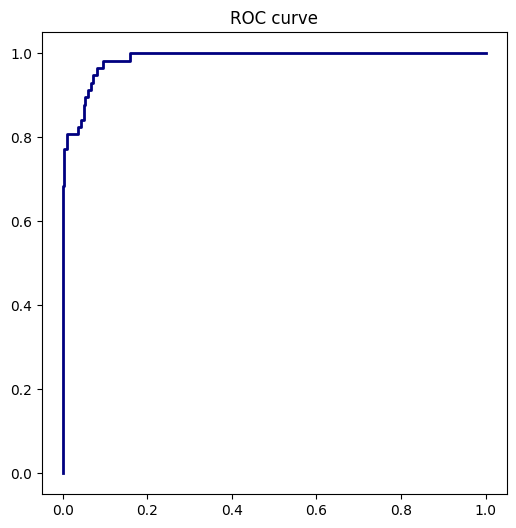

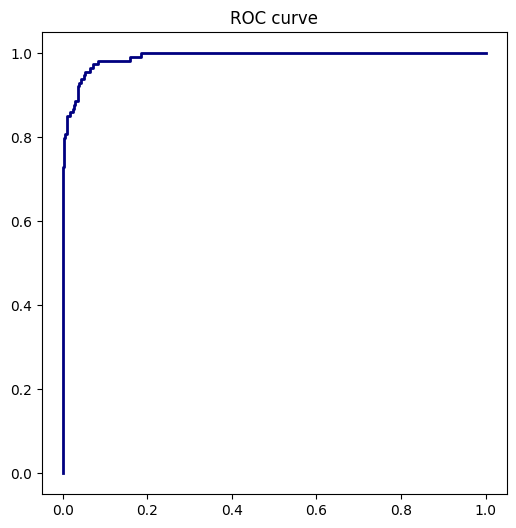

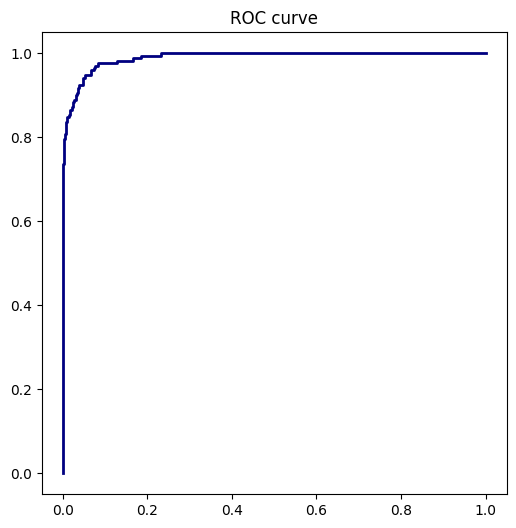

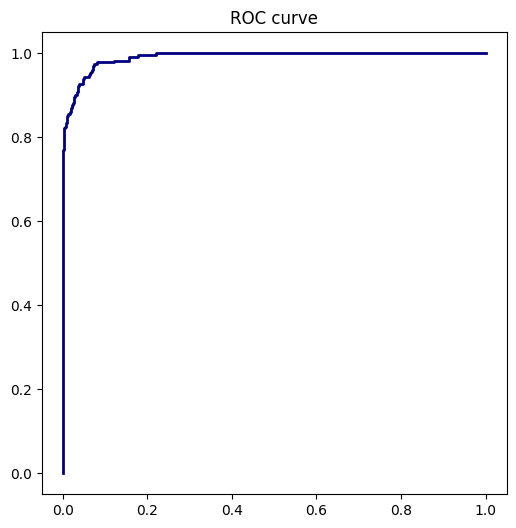

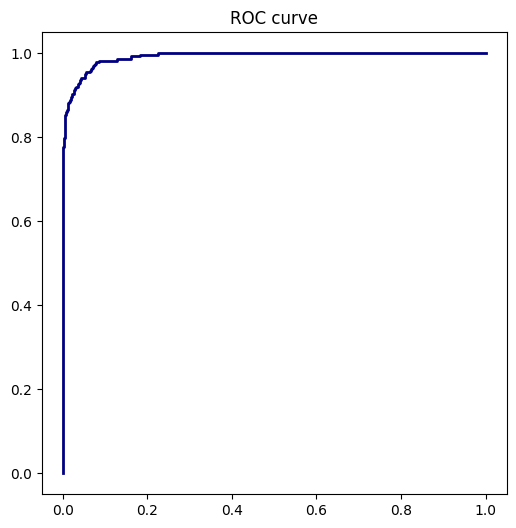

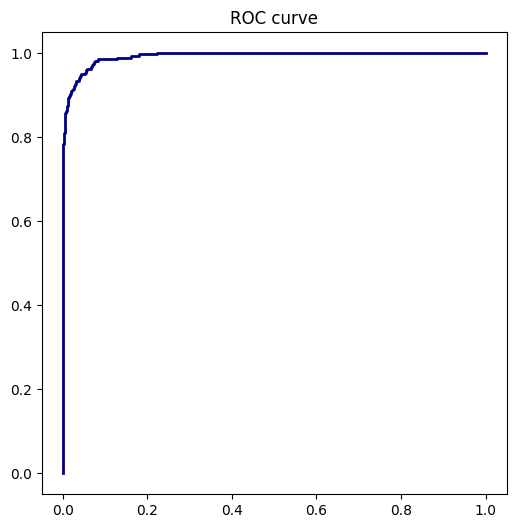

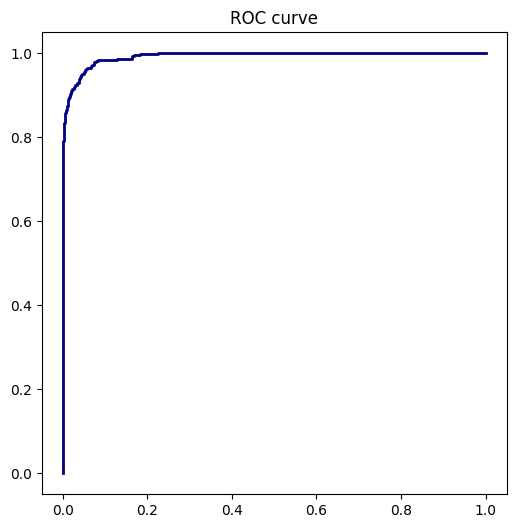

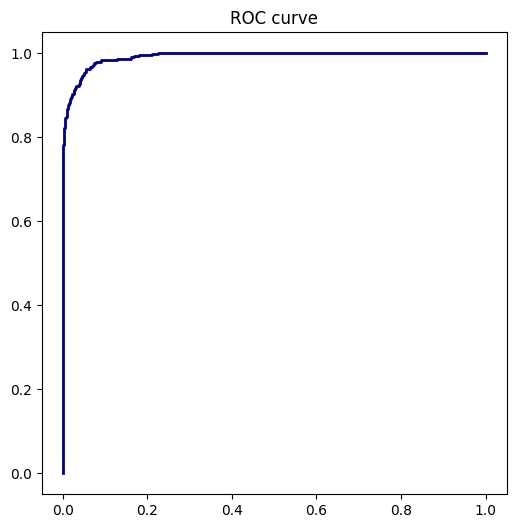

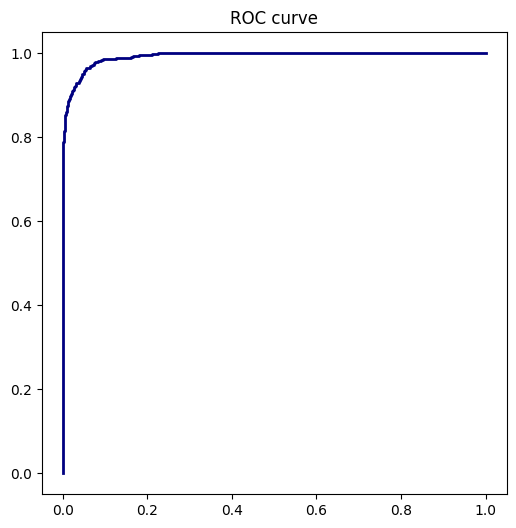

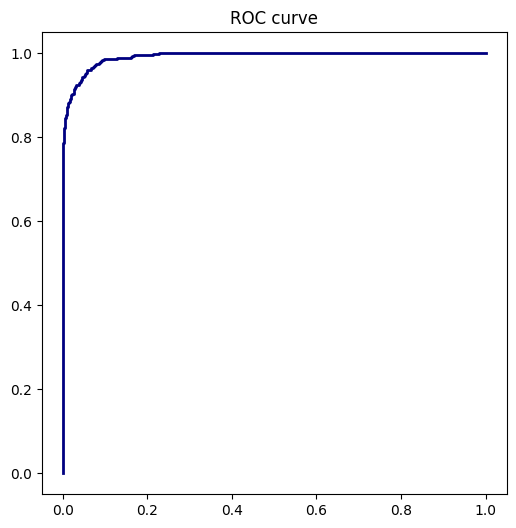

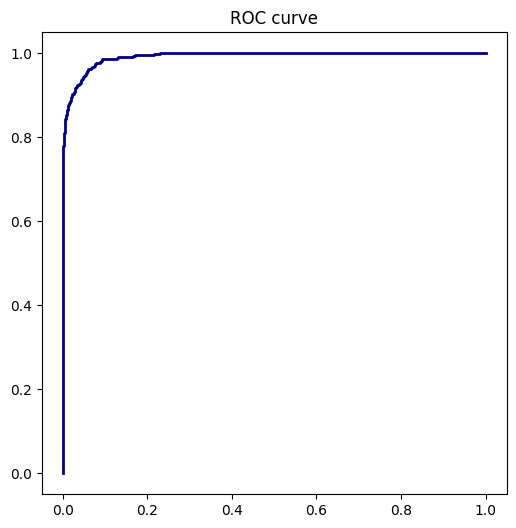

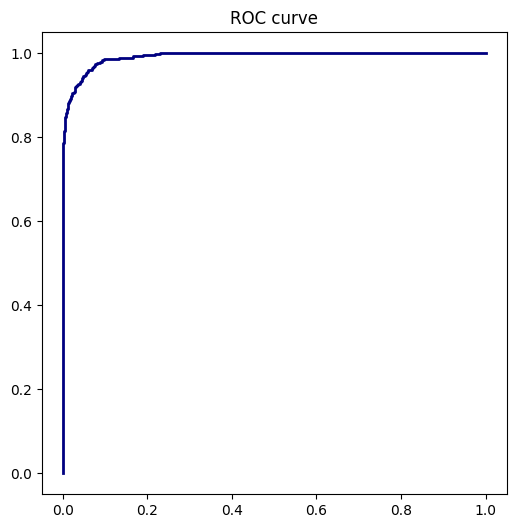

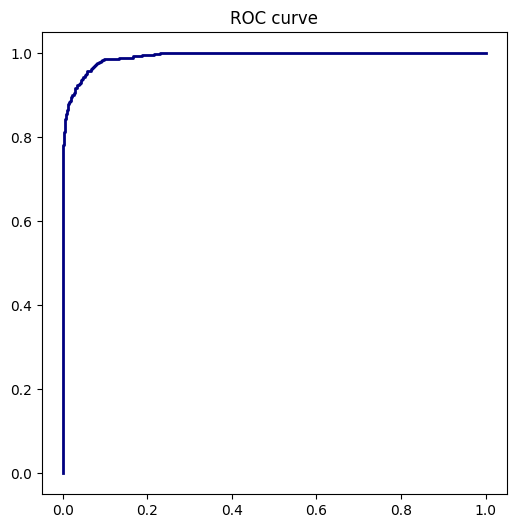

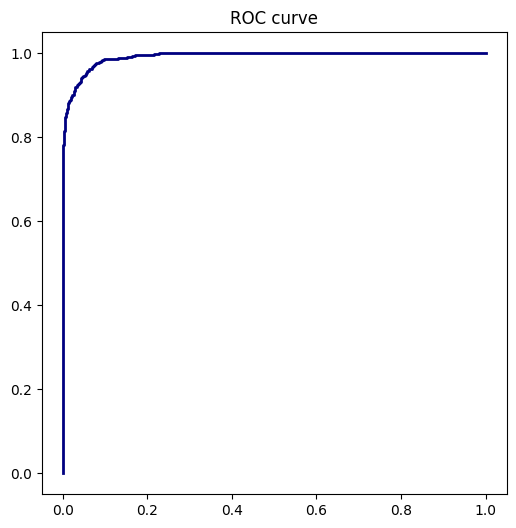

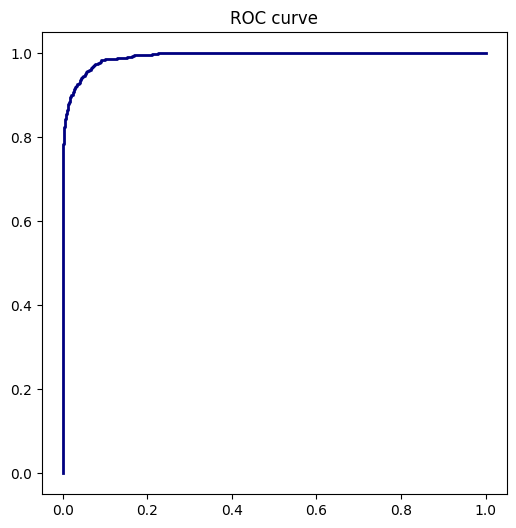

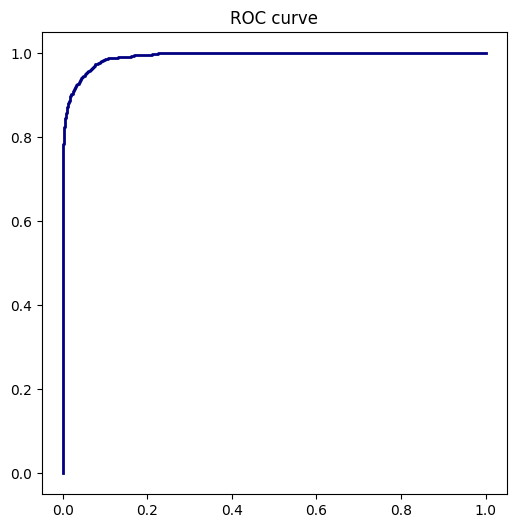

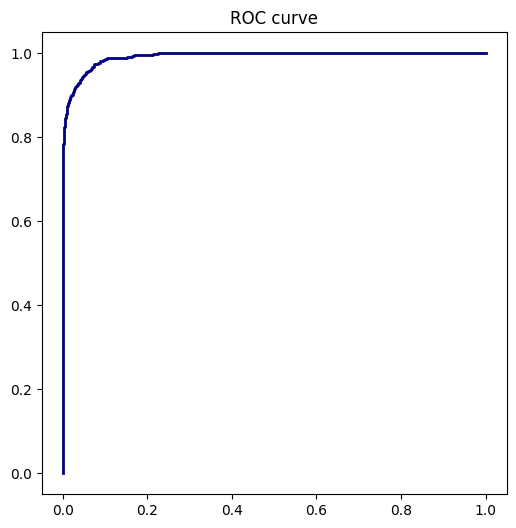

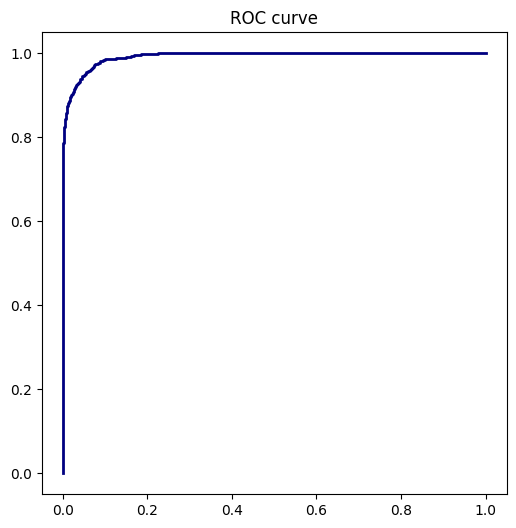

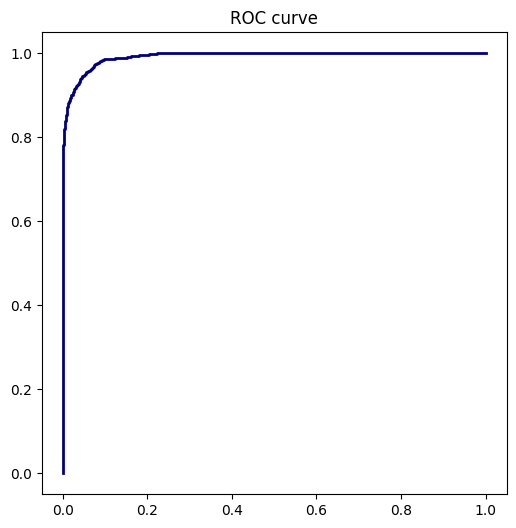

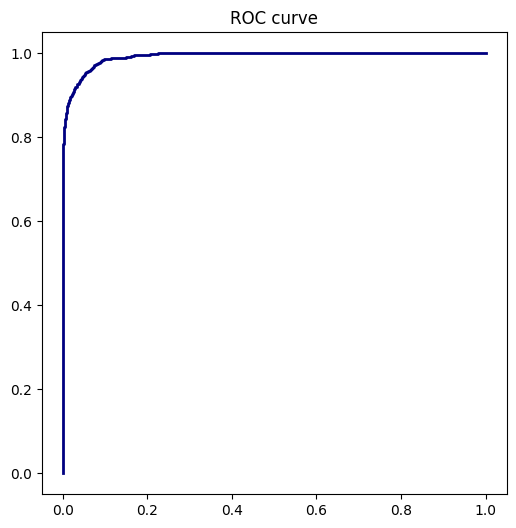

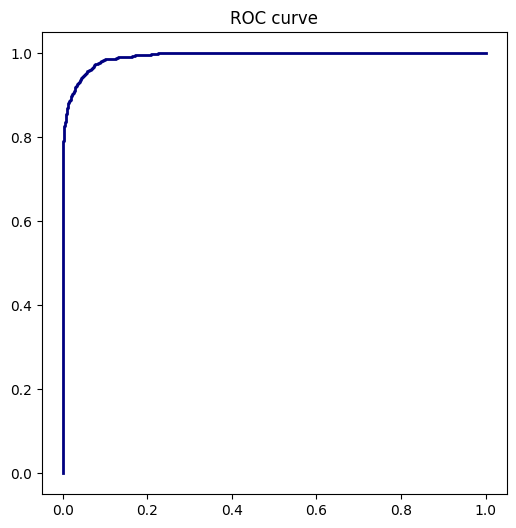

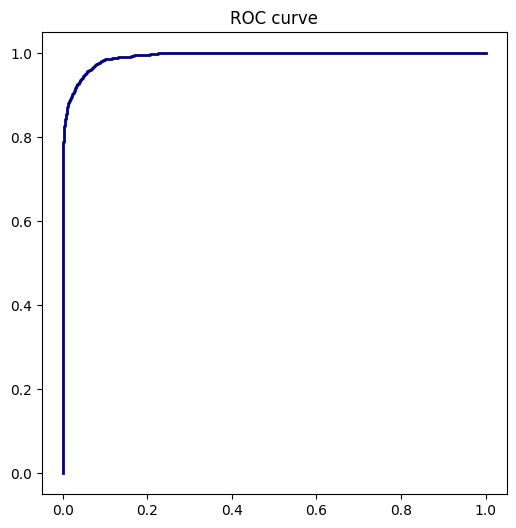

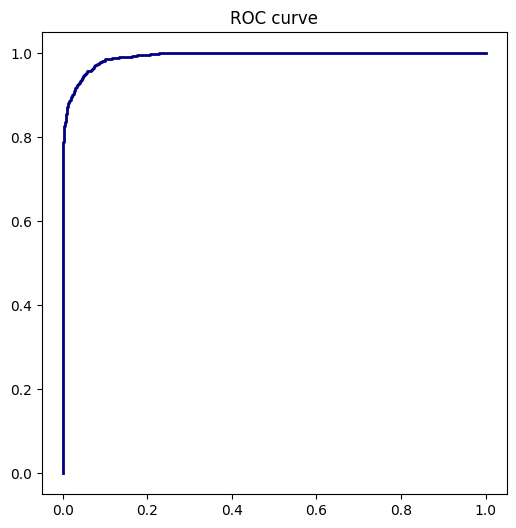

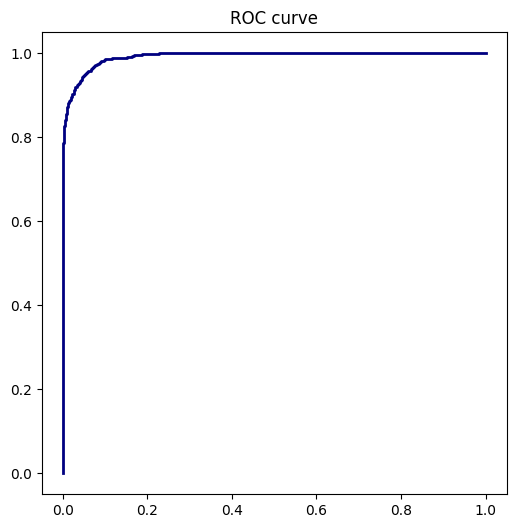

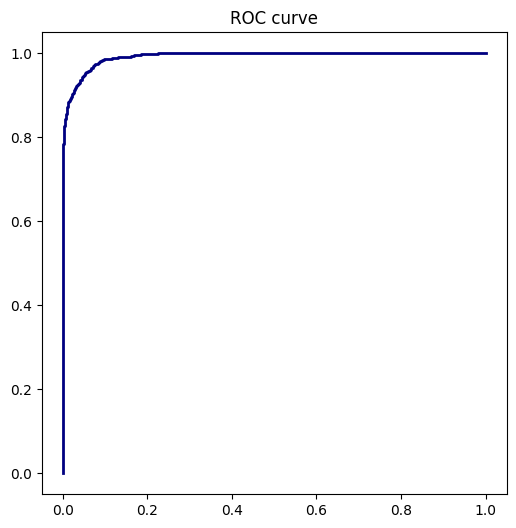

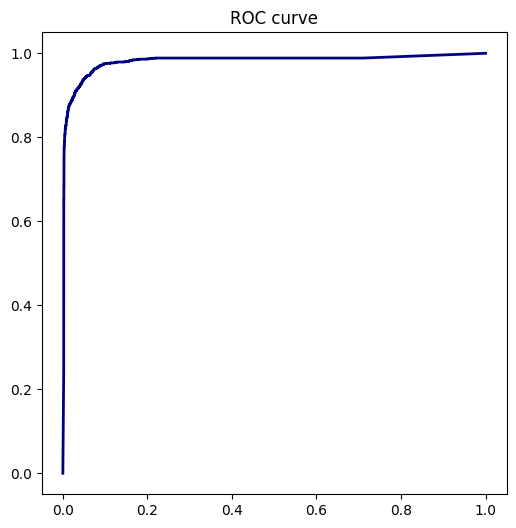

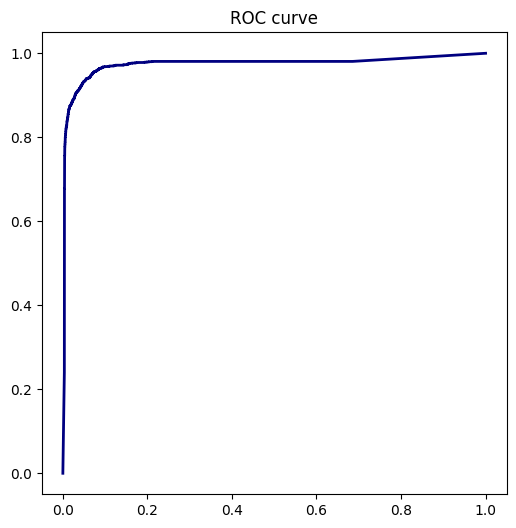

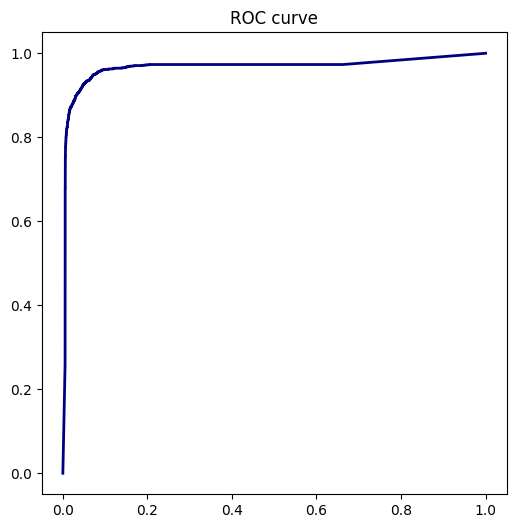

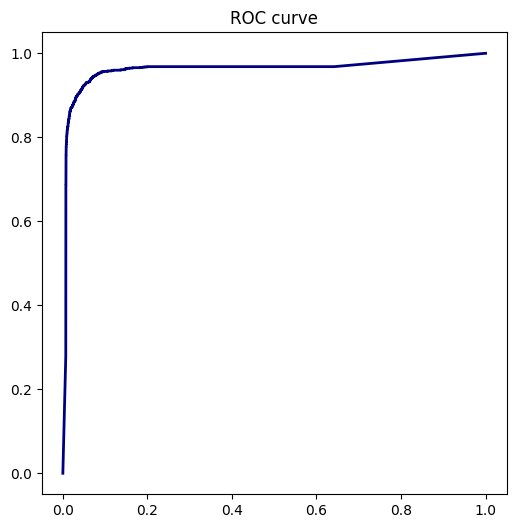

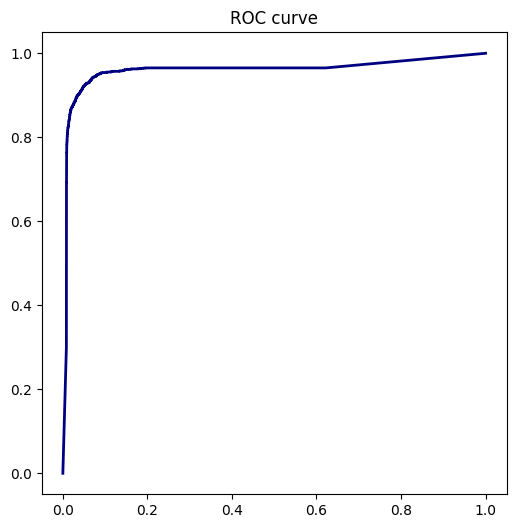

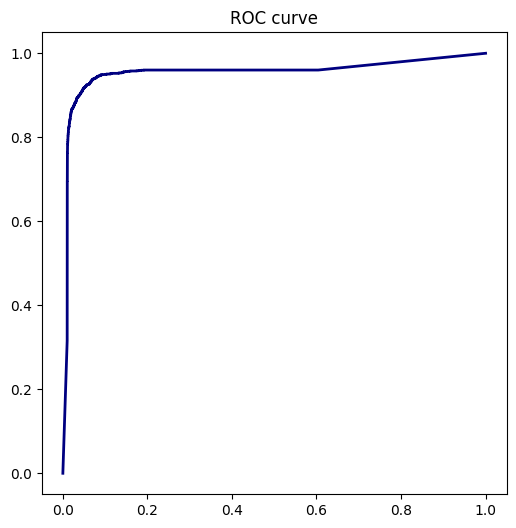

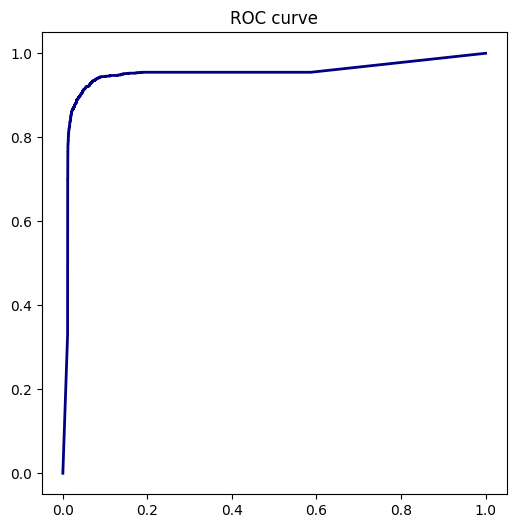

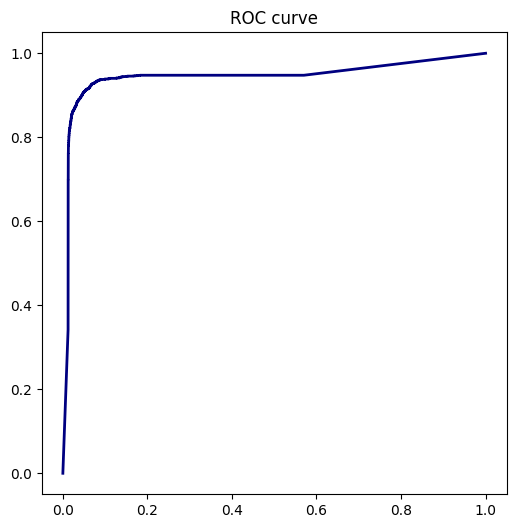

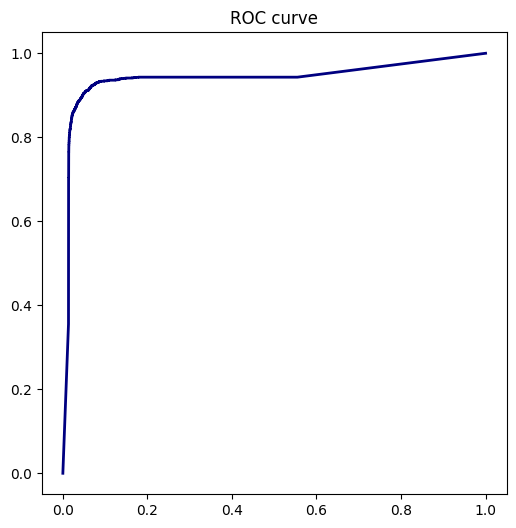

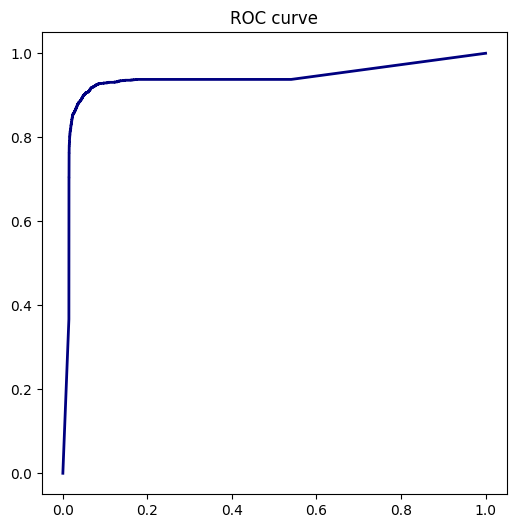

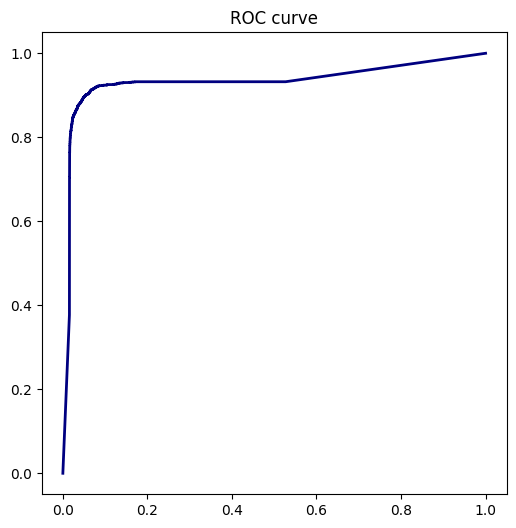

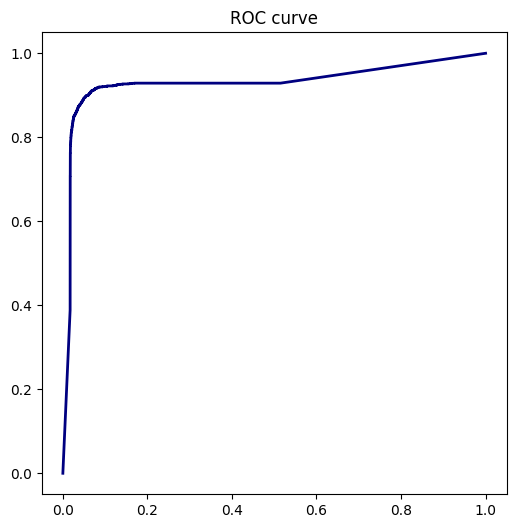

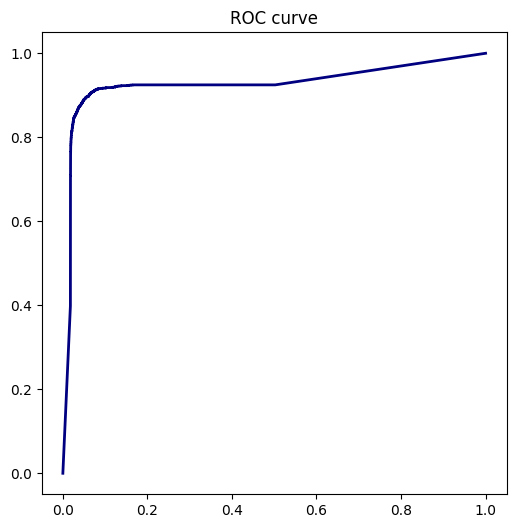

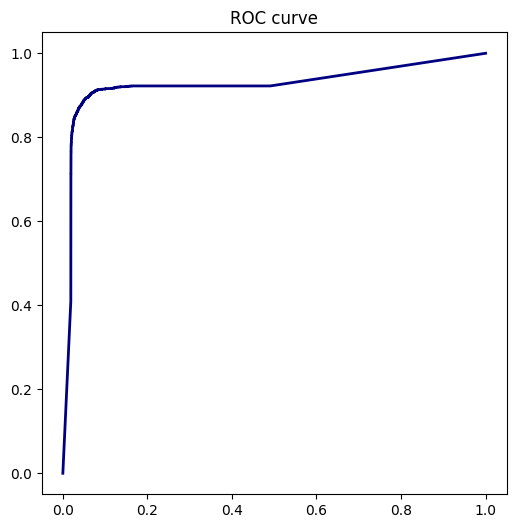

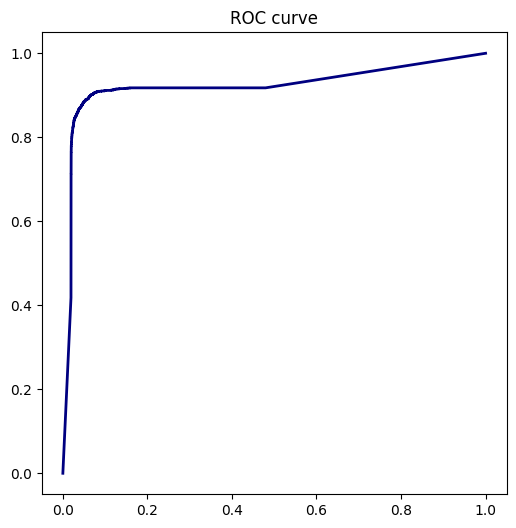

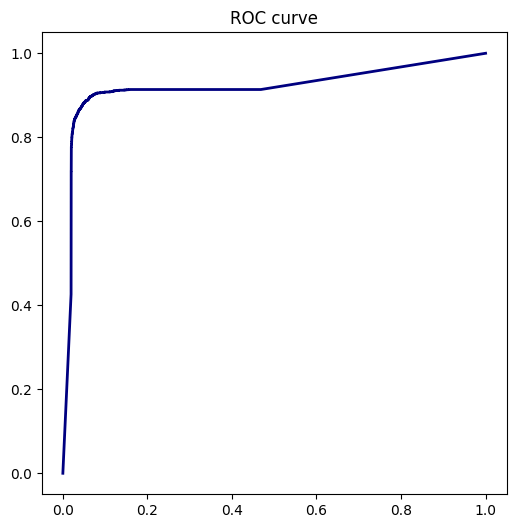

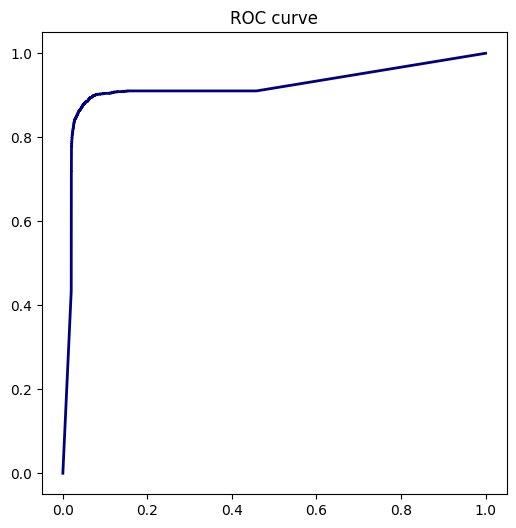

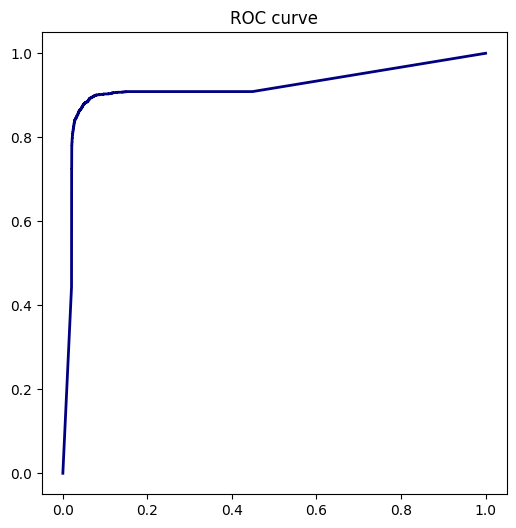

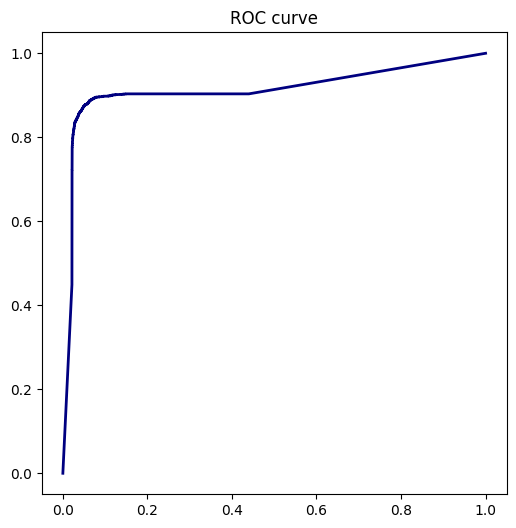

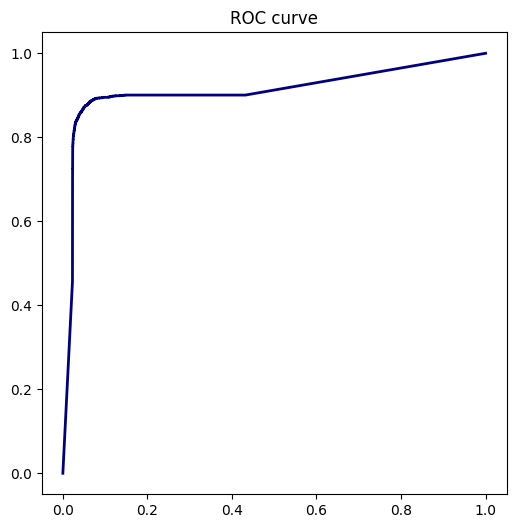

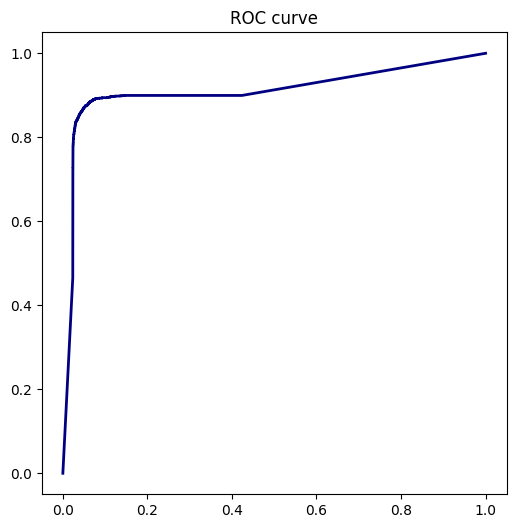

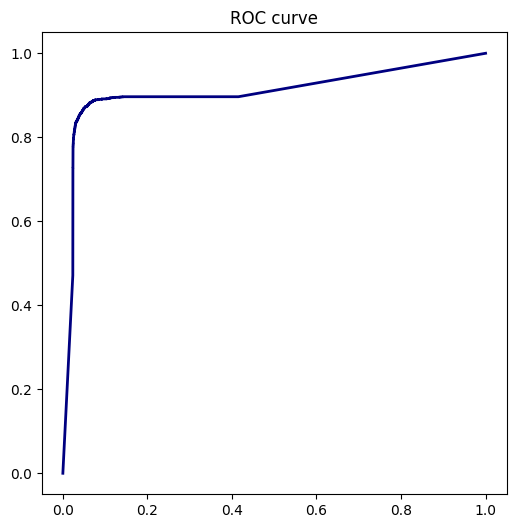

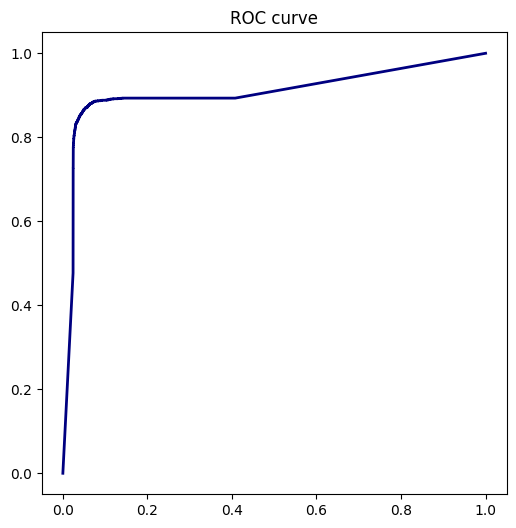

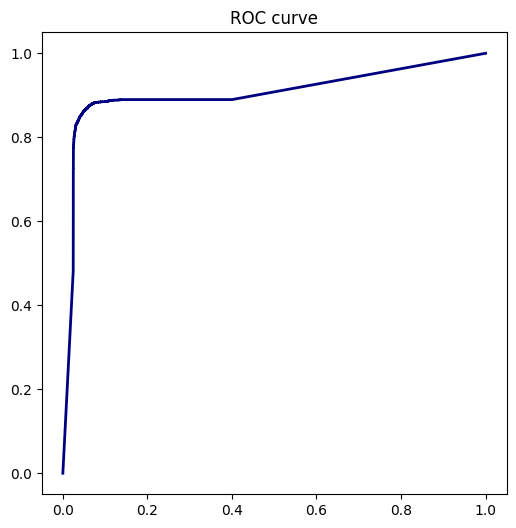

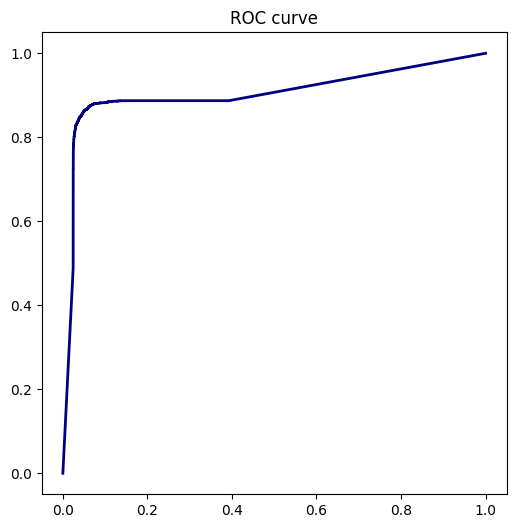

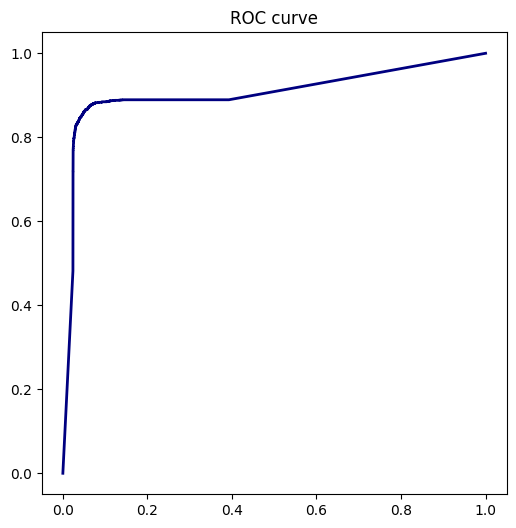

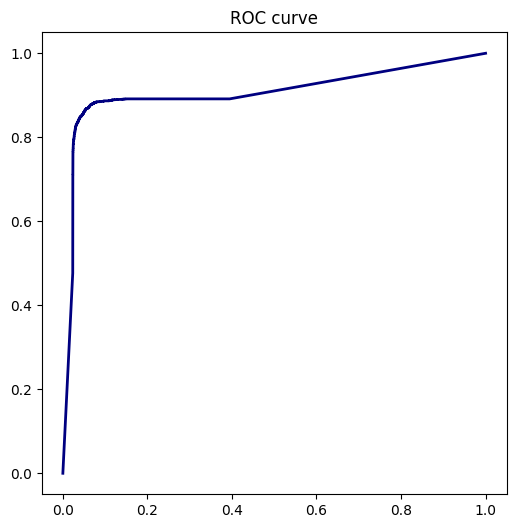

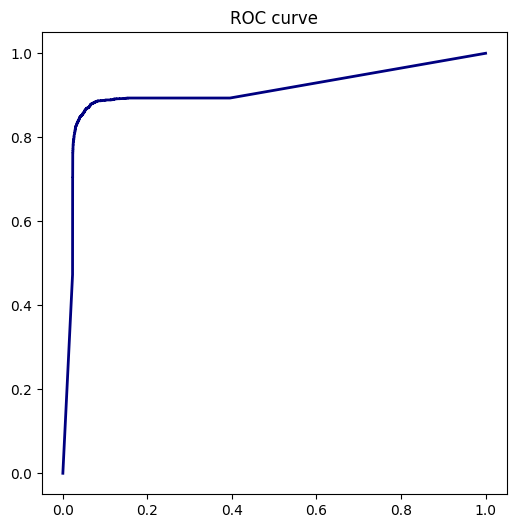

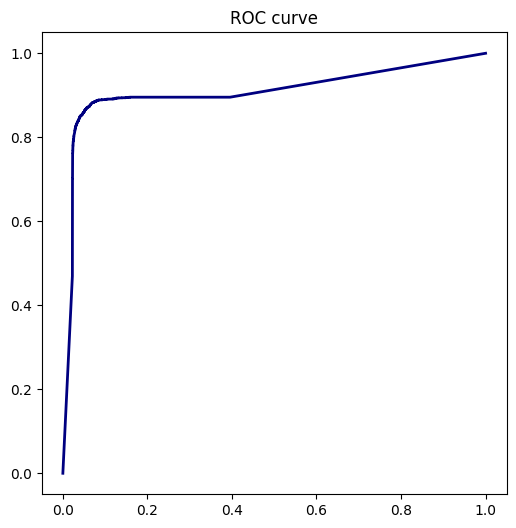

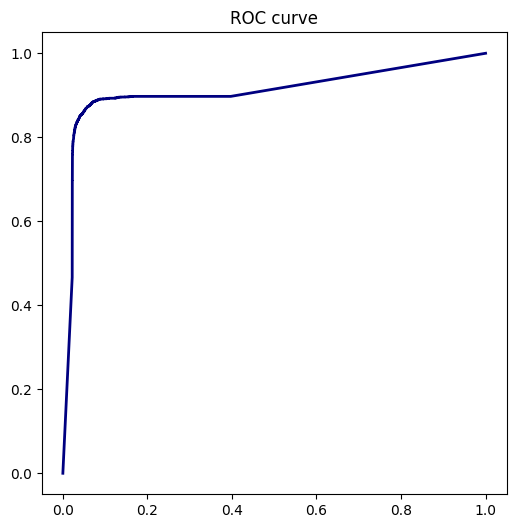

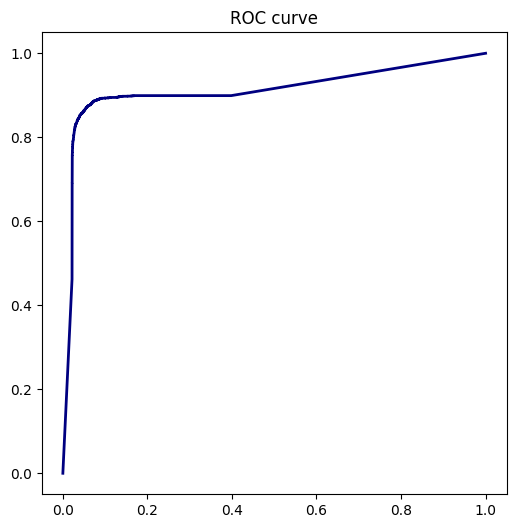

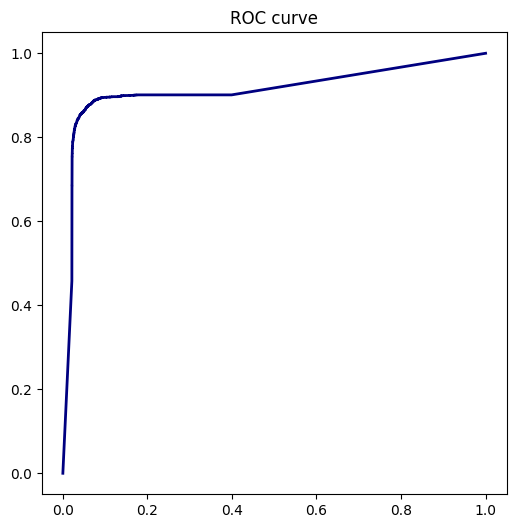

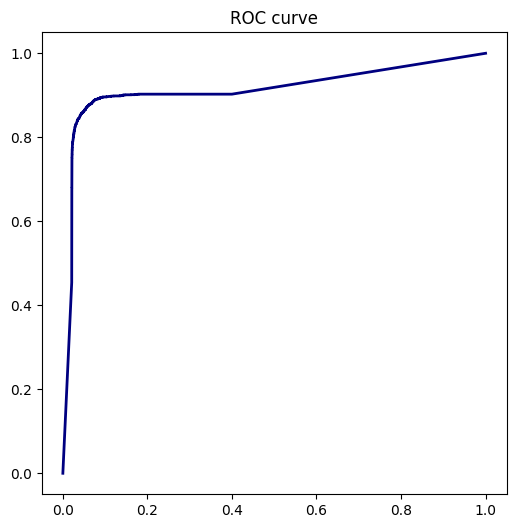

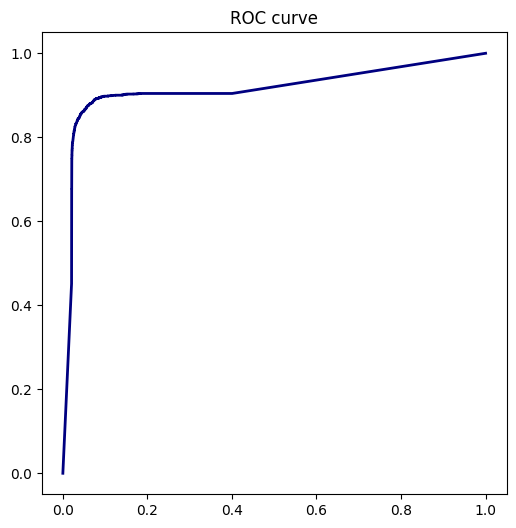

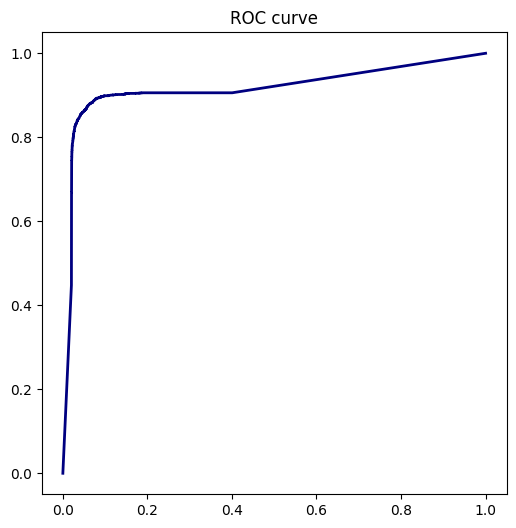

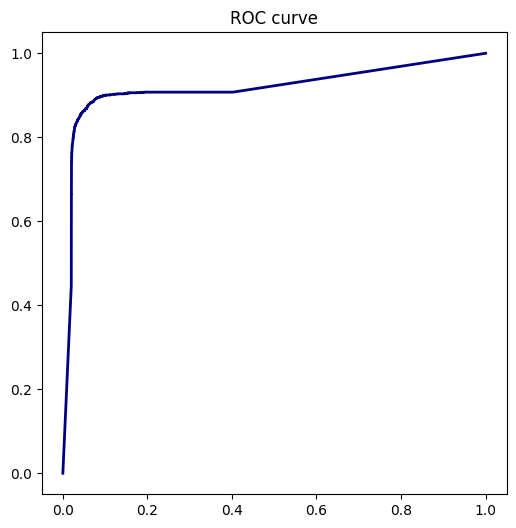

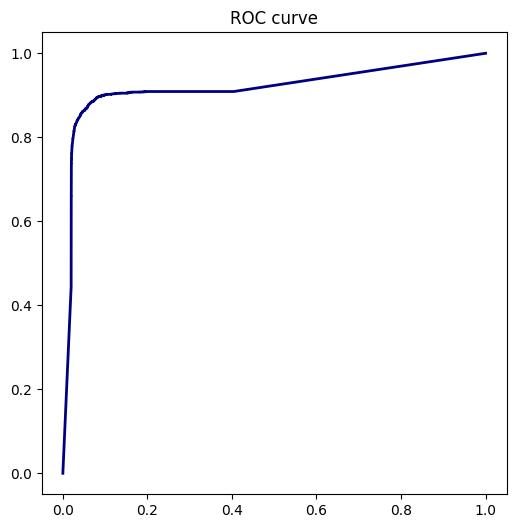

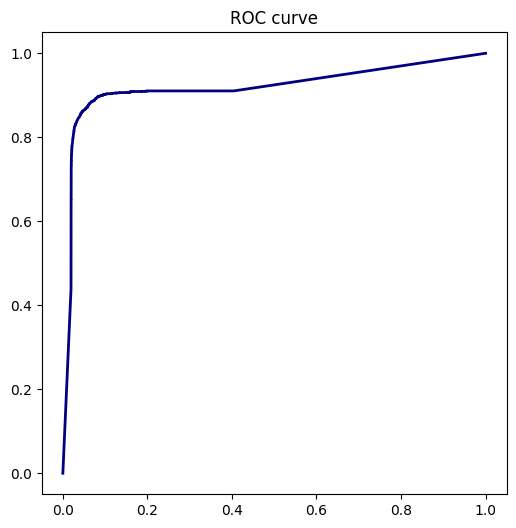

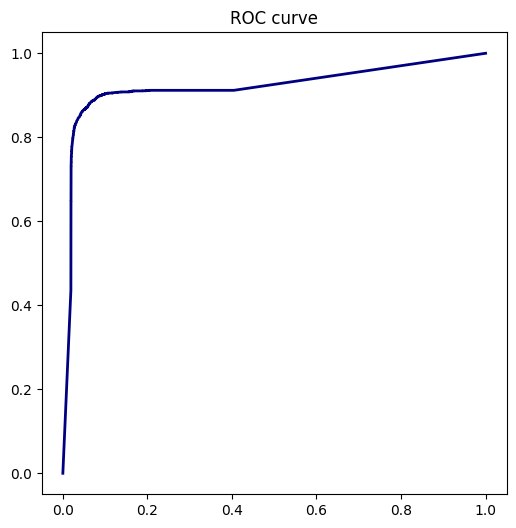

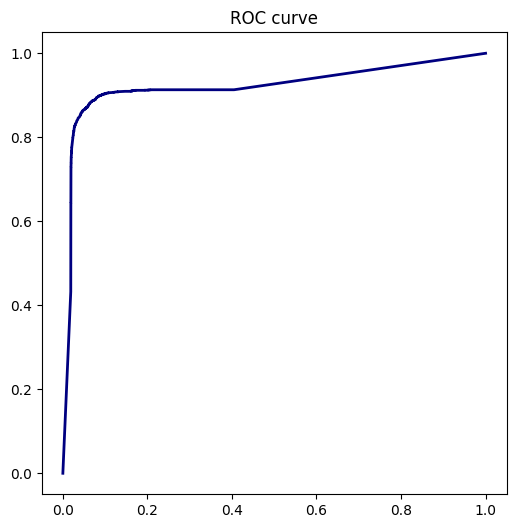

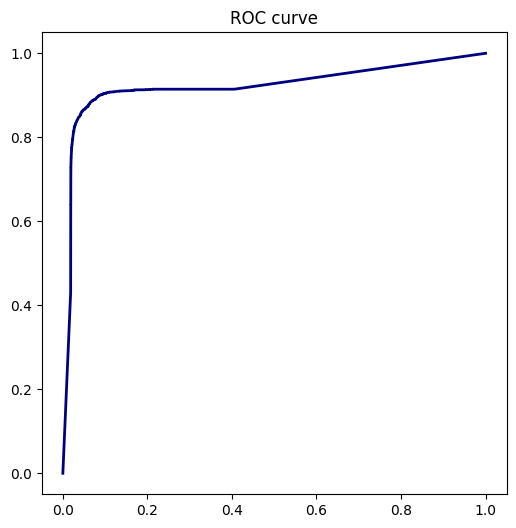

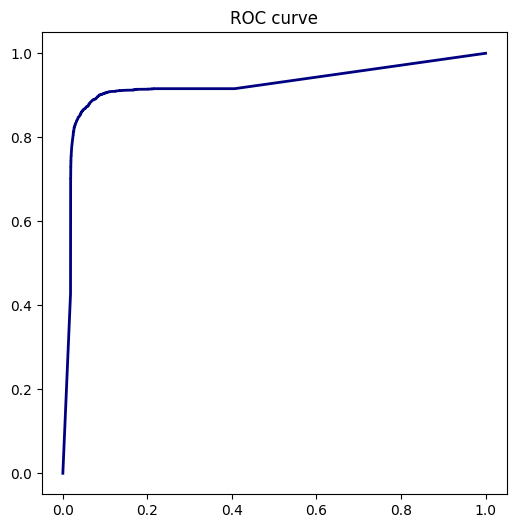

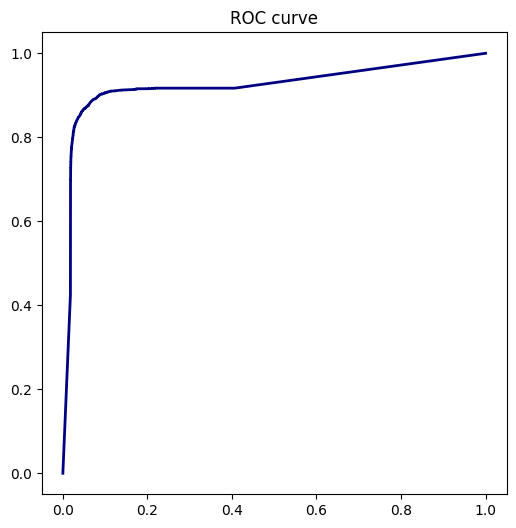

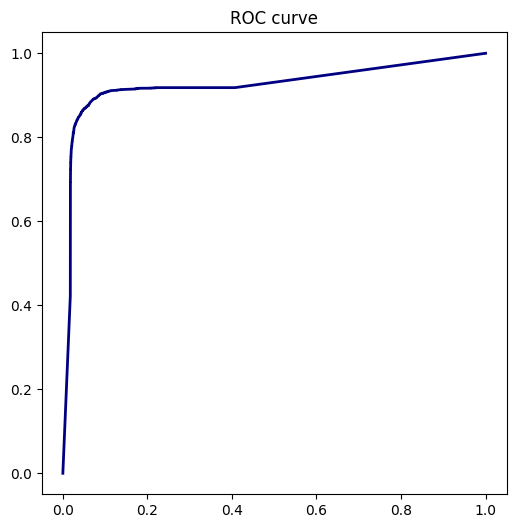

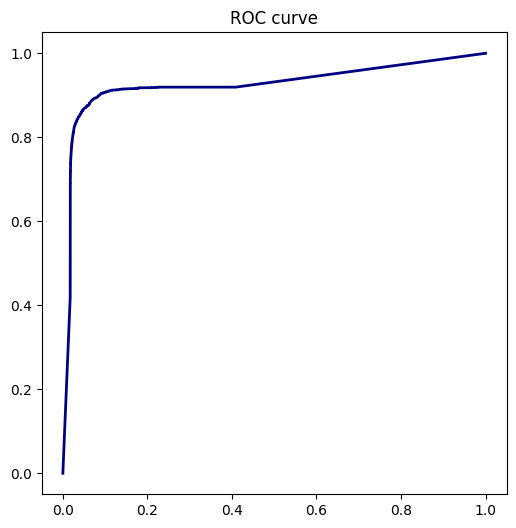

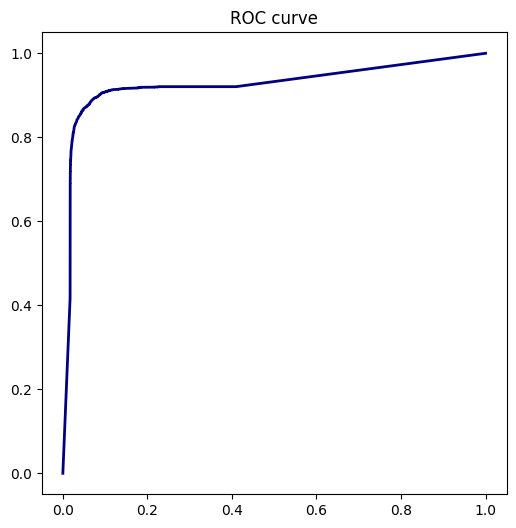

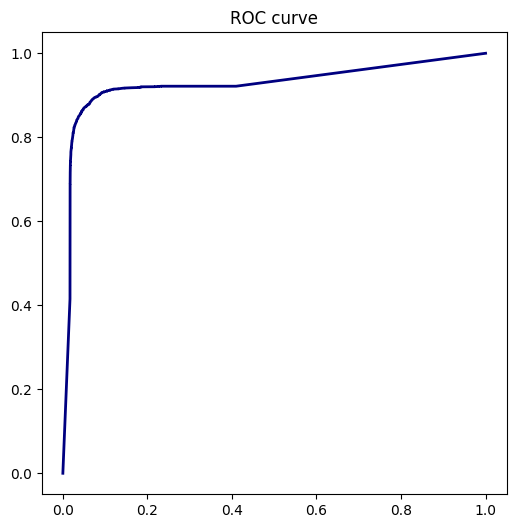

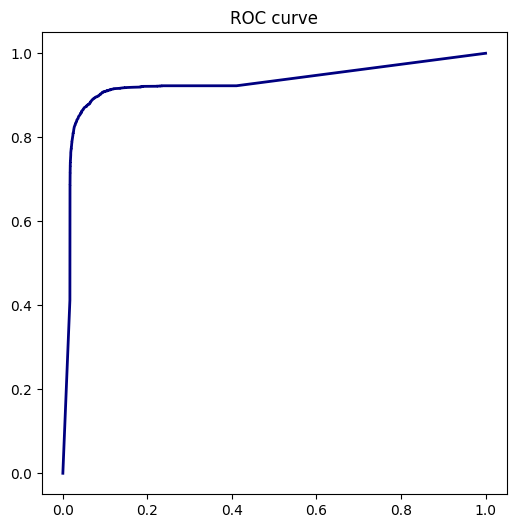

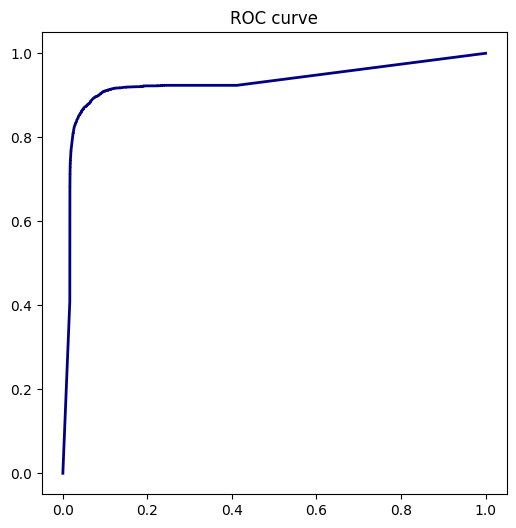

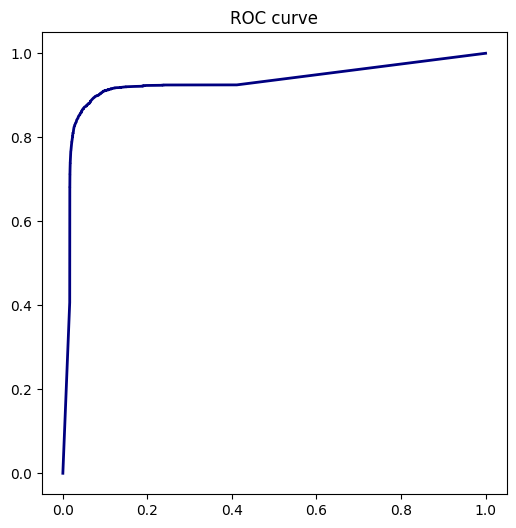

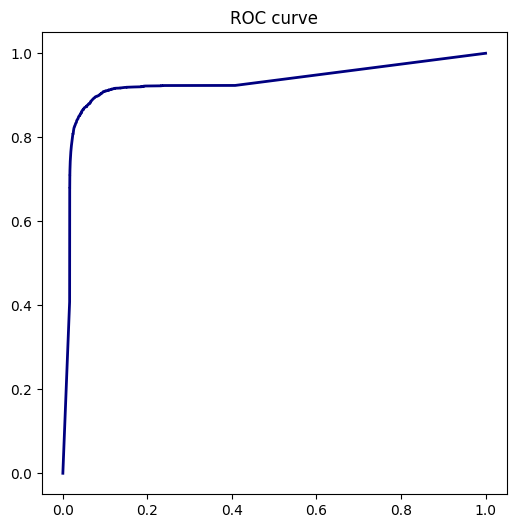

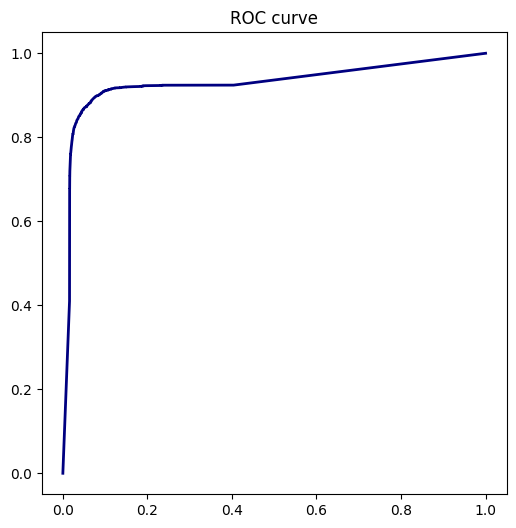

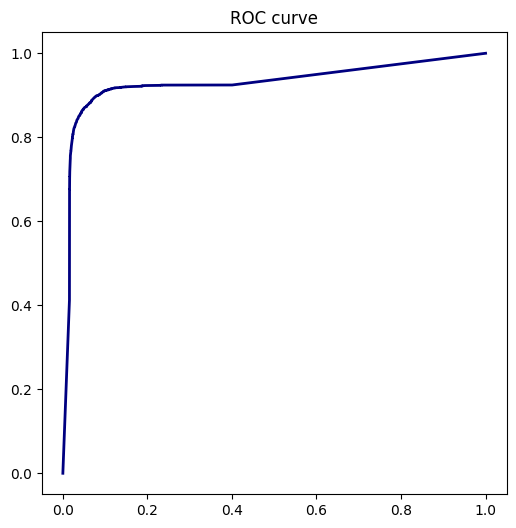

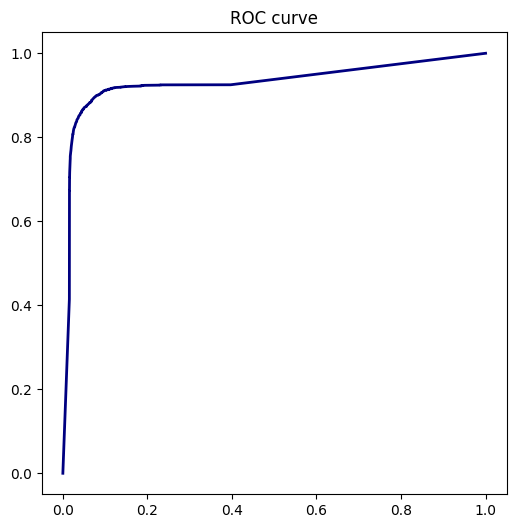

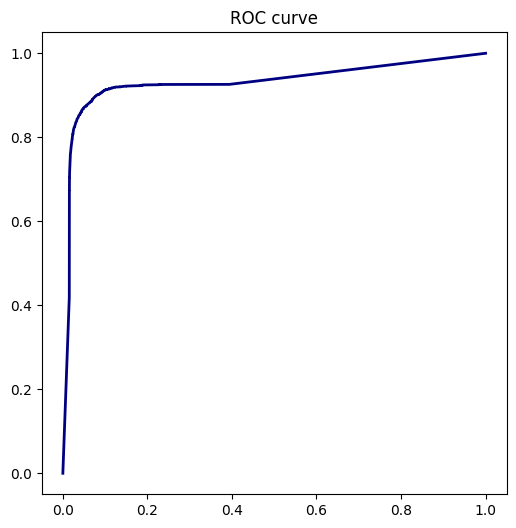

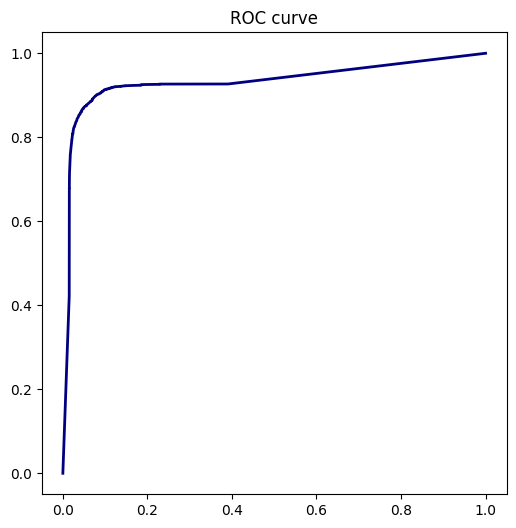

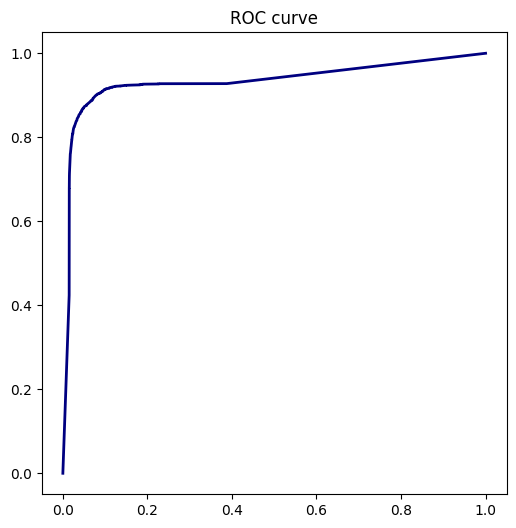

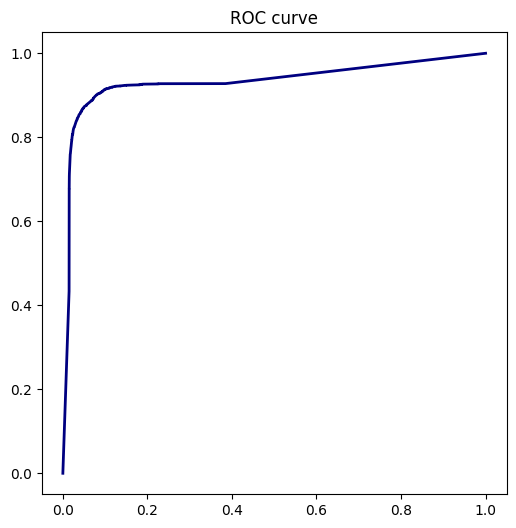

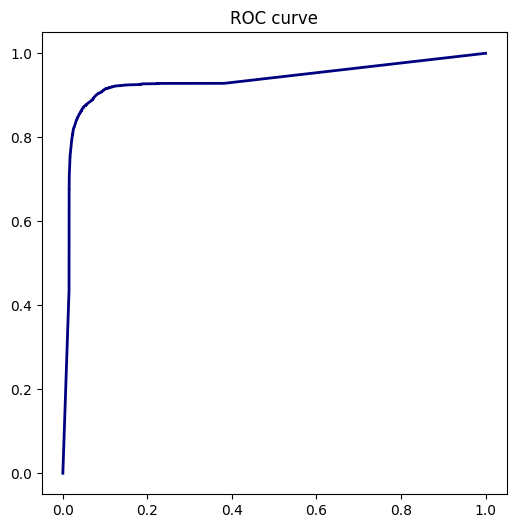

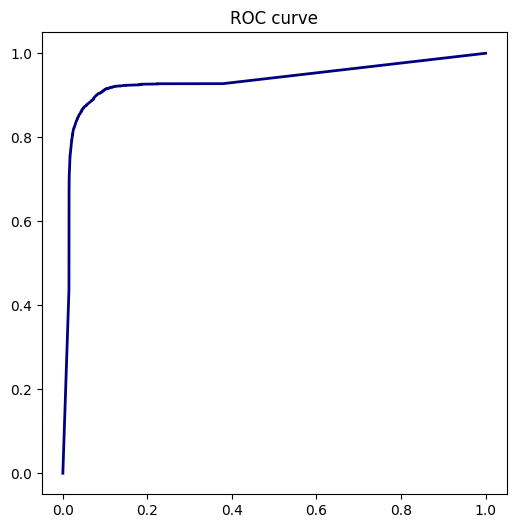

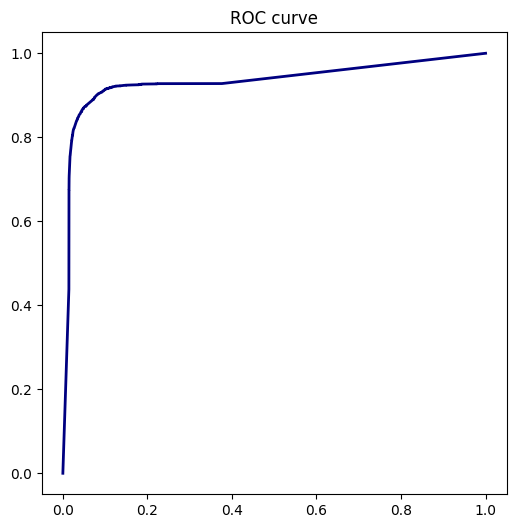

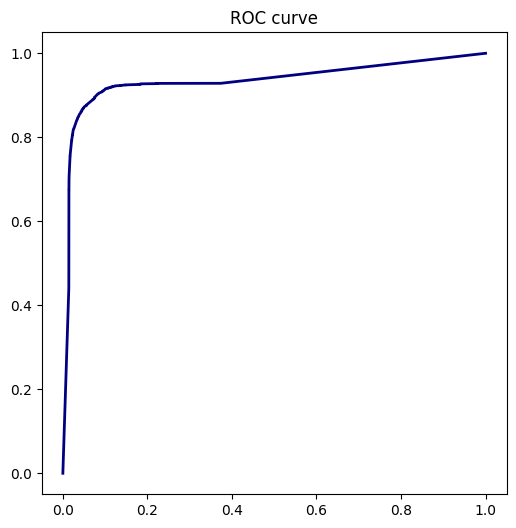

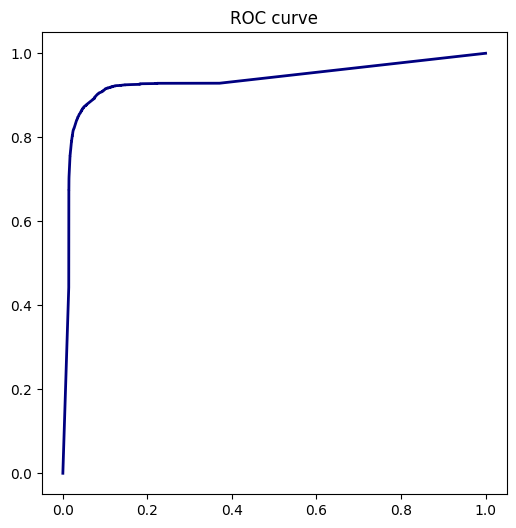

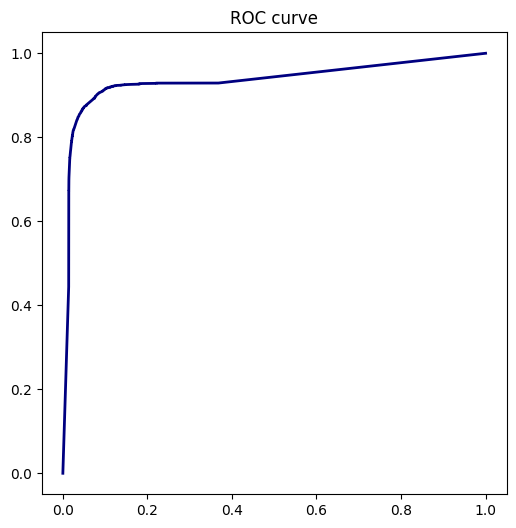

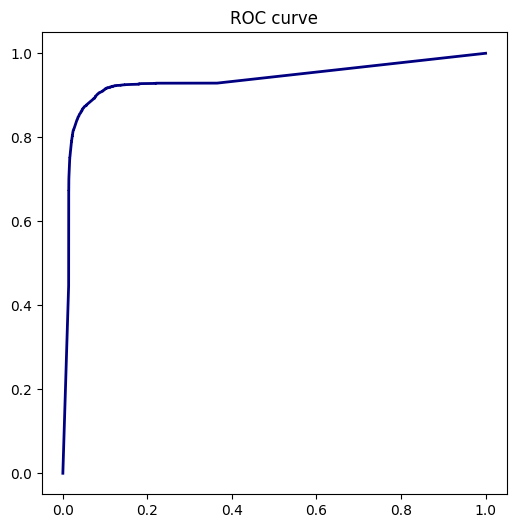

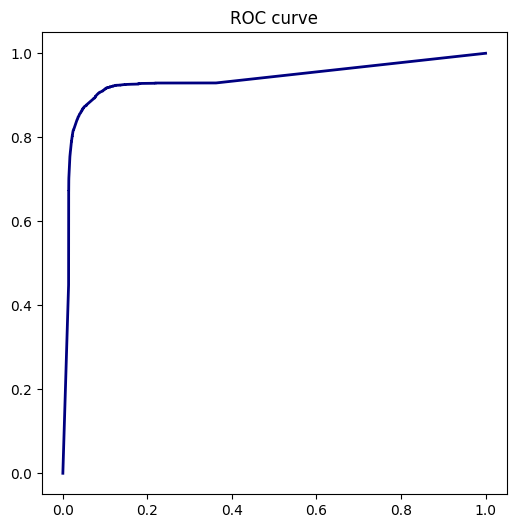

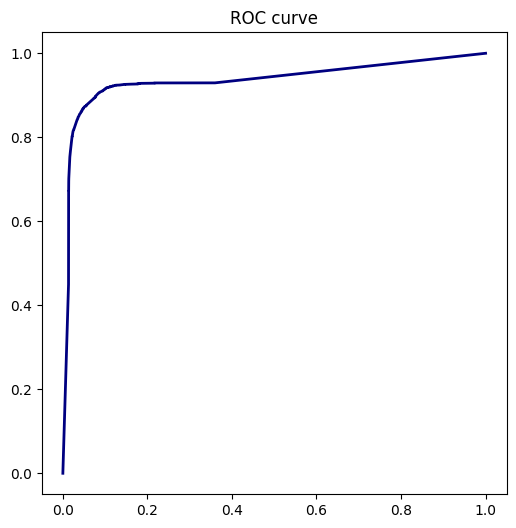

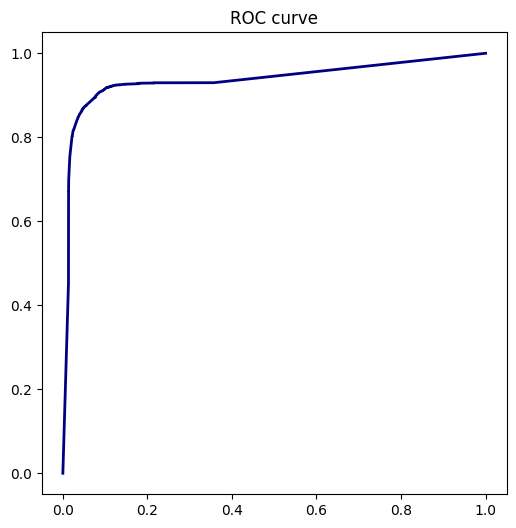

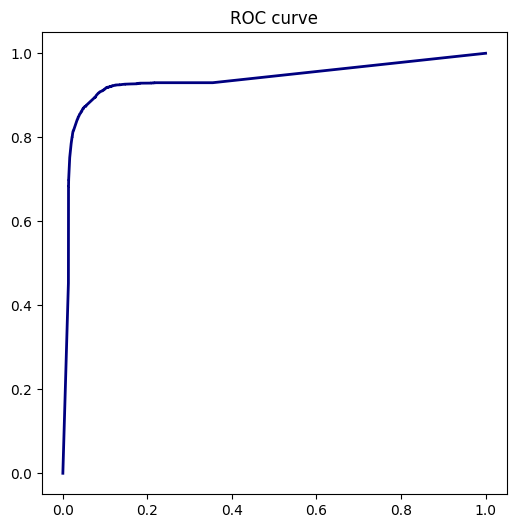

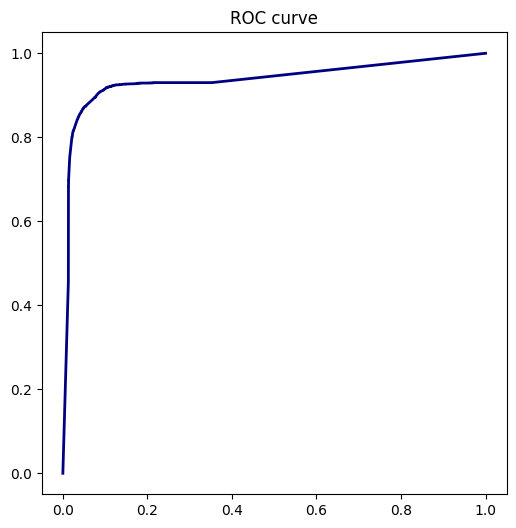

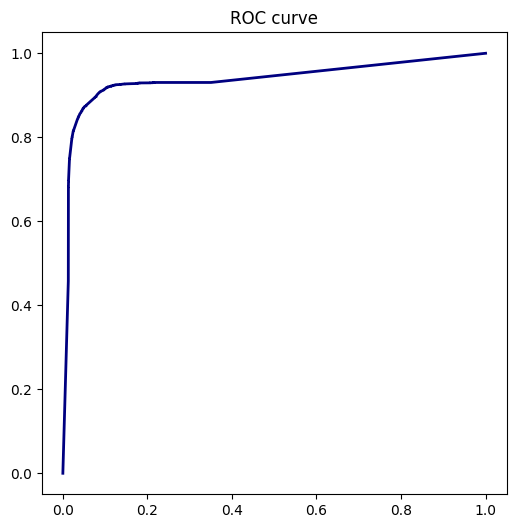

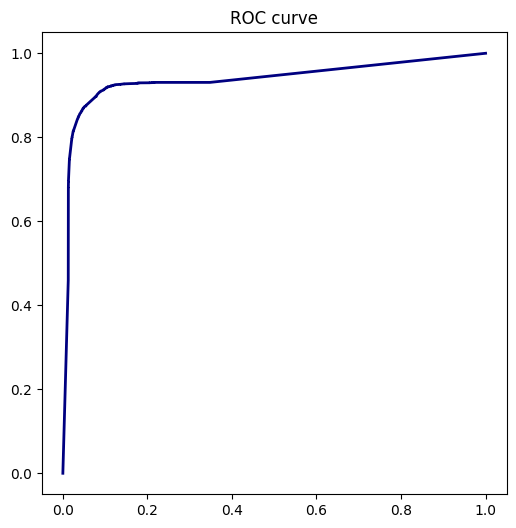

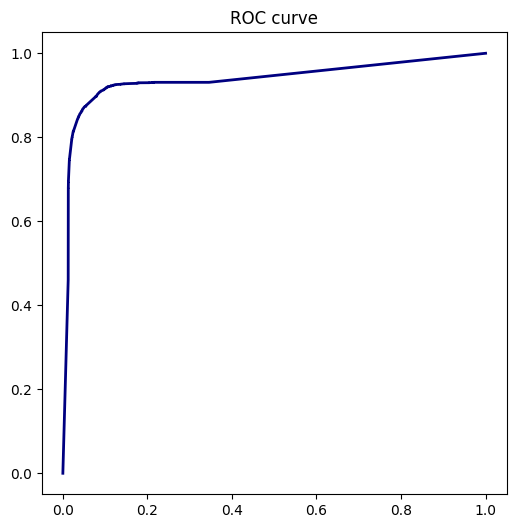

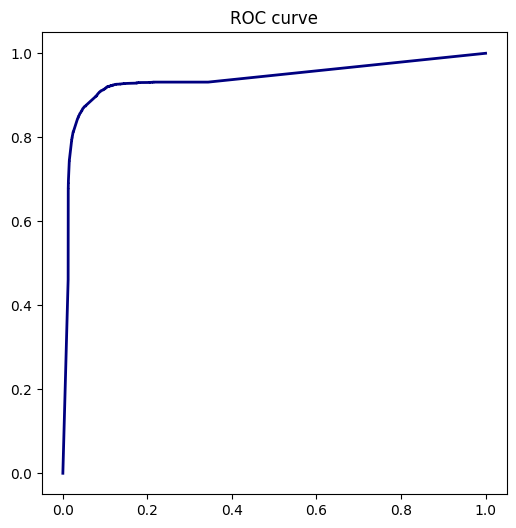

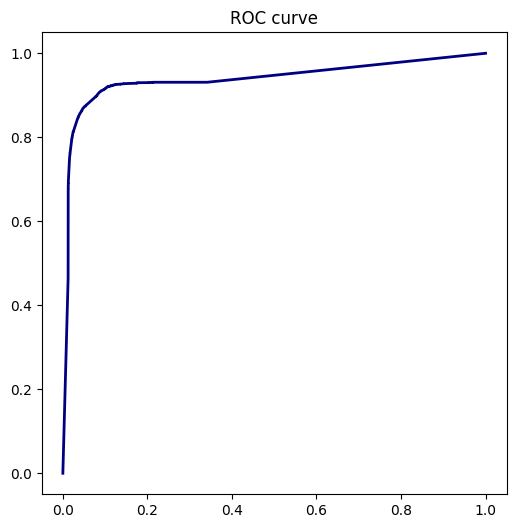

In [14]:
perform_experiments(binary_imbalanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.BINARY)

### Multiclass

In [ ]:
perform_experiments(multiclass_balanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.MULTICLASS)

Preprocessor created with 0 binary, 0 categorical, and 64 numeric columns.
tensor([[9.9720e-01, 6.7122e-05, 2.3863e-04, 2.4991e-03],
        [9.9884e-01, 1.0898e-04, 9.0500e-04, 1.4150e-04],
        [9.9856e-01, 2.1803e-04, 1.0453e-03, 1.8065e-04],
        [9.9864e-01, 3.7129e-04, 3.5715e-04, 6.3275e-04],
        [9.8473e-01, 1.2230e-03, 4.7932e-03, 9.2524e-03],
        [9.9929e-01, 1.4782e-04, 4.7886e-04, 8.3256e-05],
        [9.9889e-01, 6.9707e-04, 2.2942e-04, 1.8288e-04],
        [9.9977e-01, 5.5060e-05, 8.1826e-05, 9.1520e-05],
        [9.9899e-01, 4.8937e-04, 3.2764e-04, 1.9303e-04],
        [9.9869e-01, 1.9141e-05, 5.5843e-04, 7.3074e-04],
        [9.9809e-01, 1.4911e-03, 3.2204e-04, 9.5578e-05],
        [9.9786e-01, 8.0239e-04, 9.7674e-04, 3.5773e-04],
        [9.9772e-01, 6.9990e-04, 5.7435e-04, 1.0074e-03],
        [9.9941e-01, 2.0889e-04, 3.6988e-04, 1.1791e-05],
        [9.9951e-01, 4.0928e-05, 4.0531e-04, 4.3869e-05],
        [9.7942e-01, 7.0505e-04, 1.5316e-02, 4.5640e-03

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


tensor([[9.9761e-01, 2.1891e-04, 1.7290e-03, 4.4434e-04],
        [9.9886e-01, 2.7595e-04, 5.4797e-04, 3.1524e-04],
        [9.9663e-01, 1.3247e-03, 6.9973e-04, 1.3504e-03],
        [9.7814e-01, 2.1209e-03, 9.5965e-04, 1.8776e-02],
        [9.8595e-01, 3.6718e-05, 2.1635e-03, 1.1849e-02],
        [9.9963e-01, 2.6164e-04, 8.6657e-05, 2.3051e-05],
        [9.8035e-01, 1.8955e-03, 3.5799e-03, 1.4176e-02],
        [9.9730e-01, 1.7925e-03, 3.9801e-04, 5.1153e-04],
        [9.9787e-01, 4.3056e-04, 9.9057e-04, 7.0903e-04],
        [9.9907e-01, 4.2257e-04, 4.1957e-04, 8.3250e-05],
        [9.9987e-01, 6.4591e-05, 5.5199e-05, 1.3953e-05],
        [9.9786e-01, 1.5216e-03, 4.7926e-04, 1.4186e-04],
        [9.9826e-01, 1.0832e-03, 5.2196e-04, 1.3199e-04],
        [9.9821e-01, 1.8309e-04, 9.2582e-04, 6.8148e-04],
        [9.9736e-01, 1.2515e-04, 1.1257e-04, 2.4032e-03],
        [9.7073e-01, 2.0509e-03, 4.9391e-03, 2.2275e-02],
        [9.9985e-01, 3.5622e-05, 3.7477e-05, 7.6533e-05],
        [9.962

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\0\fold_2 directory.

tensor([[9.9263e-01, 6.1302e-04, 6.0842e-03, 6.7231e-04],
        [9.9531e-01, 4.0133e-03, 5.1969e-04, 1.5935e-04],
        [9.8499e-01, 1.3747e-03, 6.9152e-03, 6.7197e-03],
        [9.9729e-01, 9.2612e-05, 1.7811e-03, 8.3730e-04],
        [9.9703e-01, 1.6285e-03, 5.5383e-04, 7.8751e-04],
        [9.9738e-01, 1.1728e-03, 1.0868e-04, 1.3386e-03],
        [9.9906e-01, 1.4344e-04, 4.8557e-04, 3.1005e-04],
        [9.9733e-01, 7.3115e-04, 1.8301e-03, 1.0783e-04],
        [9.9752e-01, 5.1616e-04, 1.6102e-03, 3.5646e-04],
        [9.9361e-01, 2.1620e-04, 1.0136e-03, 5.1613e-03],
        [9.9783e-01, 1.8661e-03, 2.1961e-04, 8.7667e-05],
        [9.9975e-01, 1.3534e-04, 6.8073e-05, 4.4537e-05],
        [9.9841e-01, 8.3961e-04, 3.1294e-04, 4.3502e-04],
        [7.4387e-04, 9.9898e-01, 4.8307e-05, 2.3250e-04],
        [9.9904e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\1\fold_0 directory.

tensor([[9.9788e-01, 1.7198e-03, 3.1799e-04, 8.2975e-05],
        [9.9717e-01, 1.3626e-04, 2.1220e-03, 5.7532e-04],
        [9.8722e-01, 9.2666e-03, 2.6545e-03, 8.6053e-04],
        [9.9274e-01, 2.2840e-03, 8.1704e-04, 4.1624e-03],
        [9.9824e-01, 1.0315e-03, 1.4844e-04, 5.7950e-04],
        [9.9374e-01, 4.1245e-05, 2.5023e-03, 3.7207e-03],
        [9.9966e-01, 2.5524e-04, 6.0595e-05, 2.8146e-05],
        [9.7406e-01, 2.4498e-03, 8.7631e-03, 1.4723e-02],
        [9.9771e-01, 2.1330e-03, 1.4132e-04, 1.4670e-05],
        [9.9985e-01, 5.2648e-05, 4.3133e-05, 4.9213e-05],
        [9.9843e-01, 2.6860e-04, 1.1132e-03, 1.8425e-04],
        [9.9763e-01, 1.9579e-03, 2.4123e-04, 1.6718e-04],
        [9.9859e-01, 1.0581e-03, 2.5533e-04, 9.9217e-05],
        [9.9921e-01, 4.9663e-05, 7.0386e-04, 3.3326e-05],
        [9.7805e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\1\fold_2 directory.

tensor([[9.9831e-01, 4.2825e-04, 1.1049e-03, 1.5644e-04],
        [9.9915e-01, 8.5170e-05, 1.0030e-04, 6.6315e-04],
        [9.9472e-01, 3.0202e-04, 1.4909e-03, 3.4916e-03],
        [9.9535e-01, 8.4114e-06, 7.6817e-05, 4.5687e-03],
        [9.9783e-01, 3.1789e-04, 1.0265e-03, 8.2737e-04],
        [9.9853e-01, 3.3580e-04, 3.6245e-04, 7.6920e-04],
        [9.9874e-01, 4.6660e-04, 7.4595e-04, 5.0273e-05],
        [9.2500e-01, 8.6505e-03, 7.0525e-04, 6.5641e-02],
        [9.9829e-01, 1.0098e-03, 2.1805e-04, 4.8711e-04],
        [9.9806e-01, 8.6301e-04, 9.1847e-04, 1.5919e-04],
        [9.9922e-01, 1.7904e-04, 3.3111e-04, 2.7176e-04],
        [9.9982e-01, 4.6759e-05, 5.1179e-05, 8.5131e-05],
        [9.9869e-01, 5.0408e-05, 5.3354e-04, 7.3035e-04],
        [9.9169e-01, 2.4560e-03, 2.2744e-03, 3.5825e-03],
        [9.9882e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\1\fold_4 directory.

tensor([[9.8704e-01, 1.9710e-03, 9.9755e-03, 1.0116e-03],
        [9.9733e-01, 2.1669e-03, 3.6874e-04, 1.3169e-04],
        [9.9466e-01, 4.9717e-04, 2.9311e-04, 4.5491e-03],
        [9.8884e-01, 7.1387e-03, 2.9269e-03, 1.0980e-03],
        [9.9531e-01, 1.6635e-03, 4.8409e-04, 2.5388e-03],
        [9.9772e-01, 8.1912e-04, 6.2178e-05, 1.3983e-03],
        [9.9496e-01, 3.2257e-04, 1.3784e-03, 3.3343e-03],
        [9.8481e-01, 1.2172e-03, 2.4836e-03, 1.1492e-02],
        [9.9740e-01, 4.4627e-04, 1.7051e-03, 4.5233e-04],
        [9.9927e-01, 3.9739e-04, 2.8933e-04, 4.4885e-05],
        [9.9977e-01, 7.2401e-05, 1.0710e-04, 4.9091e-05],
        [9.9982e-01, 6.9518e-05, 8.1063e-05, 2.4481e-05],
        [9.9970e-01, 1.3279e-04, 5.7273e-05, 1.0730e-04],
        [9.9535e-01, 1.7655e-03, 2.5774e-03, 3.1062e-04],
        [9.9866e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metric_processing\metric_display.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\2\fold_1 directory.

tensor([[9.9773e-01, 8.9695e-05, 1.4681e-03, 7.1612e-04],
        [9.9757e-01, 5.6527e-05, 9.8566e-04, 1.3895e-03],
        [9.9952e-01, 1.5592e-04, 5.2055e-05, 2.6786e-04],
        [9.9706e-01, 1.5111e-03, 3.1238e-04, 1.1210e-03],
        [9.9423e-01, 1.1685e-03, 4.3814e-03, 2.1732e-04],
        [9.9846e-01, 2.5866e-04, 6.8429e-04, 6.0060e-04],
        [9.7417e-01, 2.6393e-03, 7.2791e-03, 1.5915e-02],
        [9.9893e-01, 6.2256e-04, 2.0245e-04, 2.4806e-04],
        [9.9830e-01, 1.0170e-03, 5.7021e-04, 1.1700e-04],
        [9.9922e-01, 1.3853e-04, 6.2529e-04, 2.1130e-05],
        [9.9942e-01, 1.9598e-04, 2.2482e-04, 1.6251e-04],
        [9.9925e-01, 2.5773e-04, 3.4776e-04, 1.4330e-04],
        [9.8504e-01, 1.0253e-02, 1.8732e-03, 2.8356e-03],
        [9.9992e-01, 2.7237e-05, 4.7322e-05, 8.0783e-06],
        [9.9207e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


tensor([[9.9809e-01, 1.4974e-03, 5.5678e-05, 3.5304e-04],
        [9.9805e-01, 1.7649e-04, 1.3705e-03, 4.0560e-04],
        [9.1205e-01, 2.9744e-03, 3.9115e-03, 8.1063e-02],
        [9.9968e-01, 2.2475e-04, 6.6050e-05, 2.9704e-05],
        [9.9893e-01, 5.9122e-04, 4.1099e-04, 6.4381e-05],
        [9.9878e-01, 3.2945e-04, 8.1161e-04, 7.5911e-05],
        [9.9314e-01, 1.8848e-03, 4.5954e-03, 3.7816e-04],
        [9.9938e-01, 2.7453e-05, 2.1888e-04, 3.7751e-04],
        [9.9838e-01, 2.0228e-04, 1.3763e-03, 4.6273e-05],
        [9.9441e-01, 2.2019e-04, 1.0851e-04, 5.2614e-03],
        [9.9824e-01, 1.0592e-04, 7.3063e-04, 9.1935e-04],
        [9.9834e-01, 6.9388e-04, 1.9940e-04, 7.6696e-04],
        [9.9264e-01, 4.5585e-03, 6.9398e-04, 2.1099e-03],
        [9.9914e-01, 1.0691e-04, 5.8516e-04, 1.6302e-04],
        [9.9939e-01, 2.3442e-04, 1.3474e-04, 2.3896e-04],
        [9.9977e-01, 1.4765e-04, 5.0890e-05, 3.1080e-05],
        [9.8447e-01, 5.3525e-04, 3.8594e-03, 1.1138e-02],
        [9.910

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\3\fold_0 directory.

tensor([[9.9708e-01, 1.6600e-04, 1.9428e-03, 8.1449e-04],
        [9.9714e-01, 1.8756e-03, 7.5705e-04, 2.2495e-04],
        [9.9836e-01, 7.1531e-05, 1.3574e-03, 2.1423e-04],
        [9.9870e-01, 1.8576e-04, 4.8554e-04, 6.2378e-04],
        [9.9631e-01, 1.7560e-04, 1.0990e-03, 2.4162e-03],
        [9.9578e-01, 1.6679e-03, 2.7349e-04, 2.2786e-03],
        [9.9778e-01, 2.0552e-04, 7.8104e-04, 1.2381e-03],
        [9.9911e-01, 7.9924e-04, 6.2198e-05, 3.2993e-05],
        [9.9923e-01, 2.0098e-04, 2.2635e-04, 3.3951e-04],
        [9.9723e-01, 2.3590e-04, 1.5718e-03, 9.6498e-04],
        [9.9775e-01, 1.2708e-03, 4.3947e-04, 5.3540e-04],
        [9.9628e-01, 3.1993e-03, 3.6515e-04, 1.5924e-04],
        [9.9856e-01, 1.5147e-04, 9.8120e-04, 3.0615e-04],
        [9.8739e-01, 9.7635e-03, 9.5648e-04, 1.8880e-03],
        [9.9976e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       dtype=torch.int32)
torch.int32
4
Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\3\fold_2 directory.

tensor([[9.9727e-01, 6.0191e-05, 5.0880e-05, 2.6214e-03],
        [9.7456e-01, 2.9180e-03, 2.9659e-04, 2.2224e-02],
        [9.8616e-01, 5.4138e-05, 1.5465e-03, 1.2238e-02],
        [9.9890e-01, 5.6051e-04, 4.9227e-04, 4.5880e-05],
        [9.9820e-01, 6.4014e-04, 9.7079e-04, 1.8659e-04],
        [9.9919e-01, 4.2467e-04, 2.3266e-04, 1.5309e-04],
        [9.9835e-01, 9.2778e-04, 5.9743e-04, 1.1980e-04],
        [9.9169e-01, 2.9432e-03, 5.6120e-04, 4.8103e-03],
     

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\3\fold_4 directory.

tensor([[9.9331e-01, 1.5717e-03, 4.6230e-03, 5.0036e-04],
        [9.9877e-01, 9.4359e-04, 2.4838e-05, 2.6072e-04],
        [9.9814e-01, 7.7612e-05, 9.8145e-04, 8.0157e-04],
        [9.9991e-01, 6.2773e-05, 1.8052e-05, 7.5174e-06],
        [8.5034e-01, 7.9779e-03, 2.9886e-03, 1.3869e-01],
        [9.9917e-01, 2.9493e-04, 7.4260e-05, 4.6511e-04],
        [9.9491e-01, 1.8275e-03, 5.2103e-04, 2.7428e-03],
        [9.9621e-01, 2.2727e-03, 4.3657e-04, 1.0784e-03],
        [9.9697e-01, 3.1363e-05, 1.1416e-04, 2.8869e-03],
        [9.8867e-01, 2.8564e-05, 1.2933e-03, 1.0003e-02],
        [9.9971e-01, 2.3570e-04, 3.5134e-05, 1.6205e-05],
        [9.9381e-01, 1.0433e-03, 4.7546e-03, 3.9239e-04],
        [9.9899e-01, 1.5114e-04, 4.1744e-04, 4.4426e-04],
        [9.9765e-01, 2.2470e-03, 5.6848e-05, 4.5242e-05],
        [9.9916e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\4\fold_1 directory.

tensor([[9.9867e-01, 1.2900e-04, 8.0708e-04, 3.9114e-04],
        [9.9883e-01, 1.3752e-04, 9.5934e-04, 7.1723e-05],
        [9.9841e-01, 4.5465e-04, 4.5340e-04, 6.7911e-04],
        [9.7736e-01, 1.5678e-03, 6.6932e-03, 1.4375e-02],
        [9.9763e-01, 8.3958e-04, 1.2995e-03, 2.2730e-04],
        [9.8911e-01, 2.1731e-03, 8.1475e-03, 5.7329e-04],
        [9.9986e-01, 4.9383e-05, 5.3368e-05, 3.5356e-05],
        [9.9942e-01, 2.0154e-05, 2.1769e-04, 3.4391e-04],
        [9.9257e-01, 2.0050e-04, 5.1397e-03, 2.0935e-03],
        [9.9155e-01, 3.3622e-03, 2.1673e-03, 2.9173e-03],
        [9.9364e-01, 3.4165e-03, 1.4904e-03, 1.4566e-03],
        [9.9908e-01, 4.6873e-04, 4.4015e-04, 9.5828e-06],
        [9.9882e-01, 7.8841e-05, 8.5809e-04, 2.4548e-04],
        [9.9973e-01, 7.5320e-05, 7.9778e-05, 1.1076e-04],
        [9.8432e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\logistic_regression\4\fold_3 directory.

tensor([[9.9324e-01, 5.8099e-03, 7.6610e-04, 1.8083e-04],
        [9.7945e-01, 6.9864e-04, 1.1626e-02, 8.2257e-03],
        [9.9863e-01, 5.2831e-04, 5.7020e-05, 7.8679e-04],
        [9.7983e-01, 3.1051e-03, 3.5981e-03, 1.3466e-02],
        [9.9751e-01, 3.8246e-04, 1.4625e-03, 6.4306e-04],
        [9.6375e-01, 3.6068e-03, 2.0242e-04, 3.2439e-02],
        [9.9767e-01, 4.0900e-04, 9.4416e-04, 9.7438e-04],
        [9.9972e-01, 1.6896e-04, 2.7518e-05, 8.4293e-05],
        [9.9394e-01, 4.3052e-03, 7.3066e-04, 1.0232e-03],
        [9.8900e-01, 6.8376e-03, 8.8861e-04, 3.2732e-03],
        [1.8510e-04, 9.9961e-01, 4.1783e-05, 1.6593e-04],
        [9.6594e-01, 2.3209e-03, 4.7079e-03, 2.7028e-02],
        [9.9782e-01, 1.0210e-03, 4.0850e-04, 7.5420e-04],
        [9.9950e-01, 2.7082e-04, 2.2270e-04, 1.1076e-05],
        [9.9804e-0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\0\fold_1 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\0\fold_4 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\1\fold_1 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\1\fold_3 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\2\fold_1 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\2\fold_4 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\3\fold_0 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\3\fold_2 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\3\fold_4 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\4\fold_2 directory.

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\decision_tree\4\fold_4 directory.

Preprocessor created with 0 binary, 0 categorical, and 64 numeric columns.
tensor([[0.8400, 0.0400, 0.0300, 0.0900],
        [0.9600, 0.0000, 0.0300, 0.0100],
        [0.8400, 0.0400, 0.0700, 0.0500],
        [0.9200, 0.0200, 0.0300, 0.0300],
        [0.7900, 0.0500, 0.0400, 0.1200],
        [0.9400, 0.0100, 0.0400, 0.0100],
        [0.9400, 0.0100, 0.0200, 0.0300],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.8100, 0.0500, 0.0700, 0.0700],
        [0.8700, 0.0200, 0.0400, 0.0700],
        [0.9300, 0.0200, 0.0300, 0.0200],
        [0.8800, 0.0400, 0.0300, 0.0500],
        [0.7300, 0.0800, 0.0900, 0.1000],
        [0.8300, 0.0900, 0.0300, 0.0500],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.7700, 0.0300, 0.1500, 0.0500],
        [0.6000, 0.1400, 0.1700, 0.0900],
        [0.9500, 0.0000, 0.0000, 0.0500],
     

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\0\fold_0 directory.

tensor([[0.9400, 0.0100, 0.0200, 0.0300],
        [0.9400, 0.0100, 0.0100, 0.0400],
        [0.9300, 0.0200, 0.0200, 0.0300],
        [0.8200, 0.0400, 0.0100, 0.1300],
        [0.8000, 0.0200, 0.0500, 0.1300],
        [0.9400, 0.0400, 0.0000, 0.0200],
        [0.6900, 0.0700, 0.0900, 0.1500],
        [0.9000, 0.0400, 0.0400, 0.0200],
        [0.9500, 0.0100, 0.0100, 0.0300],
        [0.9500, 0.0200, 0.0200, 0.0100],
        [0.9600, 0.0200, 0.0200, 0.0000],
        [0.9500, 0.0000, 0.0400, 0.0100],
        [0.7900, 0.0500, 0.1100, 0.0500],
        [0.8700, 0.0200, 0.0400, 0.0700],
        [0.7300, 0.1000, 0.0400, 0.1300],
        [0.8400, 0.0300, 0.0600, 0.0700],
        [0.9300, 0.0200, 0.0200, 0.0300],
        [0.9100, 0.0800, 0.0100, 0.0000],
        [0.9400, 0.0100, 0.0400, 0.0100],
        [0.8800, 0.0300, 0.0800, 0.010

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\0\fold_1 directory.

tensor([[0.8600, 0.0700, 0.0300, 0.0400],
        [0.9300, 0.0200, 0.0300, 0.0200],
        [0.8800, 0.0200, 0.0900, 0.0100],
        [0.8400, 0.0200, 0.0800, 0.0600],
        [0.6600, 0.1100, 0.0300, 0.2000],
        [0.9800, 0.0100, 0.0000, 0.0100],
        [0.4000, 0.1500, 0.0500, 0.4000],
        [0.9800, 0.0100, 0.0100, 0.0000],
        [0.8400, 0.0600, 0.0700, 0.0300],
        [0.8800, 0.0500, 0.0200, 0.0500],
        [0.8000, 0.0400, 0.1300, 0.0300],
        [0.7800, 0.0500, 0.0400, 0.1300],
        [0.2400, 0.2700, 0.2300, 0.2600],
        [0.9300, 0.0200, 0.0400, 0.0100],
        [0.9700, 0.0000, 0.0300, 0.0000],
        [0.9000, 0.0400, 0.0300, 0.0300],
        [0.6200, 0.0700, 0.1500, 0.1600],
        [0.6500, 0.1500, 0.0800, 0.1200],
        [0.9900, 0.0000, 0.0100, 0.0000],
        [0.7600, 0.0800, 0.1200, 0.040

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\0\fold_2 directory.

tensor([[0.8800, 0.0100, 0.0900, 0.0200],
        [0.6400, 0.1800, 0.0800, 0.1000],
        [0.7900, 0.0200, 0.1400, 0.0500],
        [0.8900, 0.0200, 0.0800, 0.0100],
        [0.9300, 0.0400, 0.0300, 0.0000],
        [0.8600, 0.0700, 0.0100, 0.0600],
        [0.9700, 0.0000, 0.0100, 0.0200],
        [0.8500, 0.0400, 0.0700, 0.0400],
        [0.9300, 0.0400, 0.0200, 0.0100],
        [0.8700, 0.0200, 0.0700, 0.0400],
        [0.7900, 0.1700, 0.0200, 0.0200],
        [0.9600, 0.0300, 0.0000, 0.0100],
        [0.9800, 0.0100, 0.0000, 0.0100],
        [0.2200, 0.4800, 0.0900, 0.2100],
        [0.9800, 0.0100, 0.0100, 0.0000],
        [0.9600, 0.0200, 0.0000, 0.0200],
        [0.7300, 0.0800, 0.1200, 0.0700],
        [0.9600, 0.0300, 0.0100, 0.0000],
        [0.9400, 0.0100, 0.0400, 0.0100],
        [0.9700, 0.0000, 0.0200, 0.010

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\0\fold_3 directory.

tensor([[0.9600, 0.0400, 0.0000, 0.0000],
        [0.7900, 0.0400, 0.1500, 0.0200],
        [0.9400, 0.0400, 0.0200, 0.0000],
        [0.9600, 0.0300, 0.0000, 0.0100],
        [0.7300, 0.1000, 0.1500, 0.0200],
        [0.7600, 0.0600, 0.1400, 0.0400],
        [0.9000, 0.0500, 0.0100, 0.0400],
        [0.9500, 0.0200, 0.0300, 0.0000],
        [0.9600, 0.0000, 0.0300, 0.0100],
        [0.7600, 0.0500, 0.1100, 0.0800],
        [0.9100, 0.0200, 0.0200, 0.0500],
        [0.6400, 0.1100, 0.1200, 0.1300],
        [0.9600, 0.0200, 0.0100, 0.0100],
        [0.9800, 0.0000, 0.0100, 0.0100],
        [0.8200, 0.1000, 0.0400, 0.0400],
        [0.8000, 0.0700, 0.0800, 0.0500],
        [0.7400, 0.0800, 0.1200, 0.0600],
        [0.9200, 0.0000, 0.0300, 0.0500],
        [0.9600, 0.0200, 0.0200, 0.0000],
        [0.9200, 0.0200, 0.0100, 0.050

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\0\fold_4 directory.

tensor([[0.9300, 0.0000, 0.0600, 0.0100],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.7100, 0.0500, 0.1500, 0.0900],
        [0.9300, 0.0500, 0.0100, 0.0100],
        [0.9400, 0.0200, 0.0300, 0.0100],
        [0.9100, 0.0600, 0.0100, 0.0200],
        [0.7700, 0.0400, 0.1300, 0.0600],
        [0.8300, 0.0400, 0.0800, 0.0500],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.9900, 0.0000, 0.0100, 0.0000],
        [0.9200, 0.0300, 0.0100, 0.0400],
        [0.8900, 0.0300, 0.0300, 0.0500],
        [0.6400, 0.1200, 0.1100, 0.1300],
        [0.8600, 0.0300, 0.0400, 0.0700],
        [0.9100, 0.0300, 0.0300, 0.0300],
        [0.8200, 0.0800, 0.0600, 0.0400],
        [0.8600, 0.0200, 0.0800, 0.0400],
        [0.7900, 0.0200, 0.1000, 0.0900],
        [0.6200, 0.0600, 0.2300, 0.0900],
        [0.9500, 0.0100, 0.0300, 0.010

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\1\fold_0 directory.

tensor([[0.8000, 0.1100, 0.0500, 0.0400],
        [0.8100, 0.0000, 0.1500, 0.0400],
        [0.8800, 0.0200, 0.0600, 0.0400],
        [0.8500, 0.0600, 0.0100, 0.0800],
        [0.8500, 0.0200, 0.0700, 0.0600],
        [0.7900, 0.0000, 0.1000, 0.1100],
        [0.9400, 0.0300, 0.0000, 0.0300],
        [0.8100, 0.0500, 0.0500, 0.0900],
        [0.9400, 0.0000, 0.0300, 0.0300],
        [0.9800, 0.0100, 0.0000, 0.0100],
        [0.9400, 0.0000, 0.0400, 0.0200],
        [0.8200, 0.1200, 0.0300, 0.0300],
        [0.9100, 0.0200, 0.0400, 0.0300],
        [0.8400, 0.1000, 0.0500, 0.0100],
        [0.8500, 0.0200, 0.0100, 0.1200],
        [0.9000, 0.0400, 0.0300, 0.0300],
        [0.9000, 0.0000, 0.0300, 0.0700],
        [0.9200, 0.0600, 0.0000, 0.0200],
        [0.7300, 0.0600, 0.0600, 0.1500],
        [0.9400, 0.0000, 0.0200, 0.040

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\1\fold_1 directory.

tensor([[0.9000, 0.0300, 0.0300, 0.0400],
        [0.9500, 0.0000, 0.0400, 0.0100],
        [0.7700, 0.0600, 0.1100, 0.0600],
        [0.7800, 0.0800, 0.0500, 0.0900],
        [0.8900, 0.0300, 0.0600, 0.0200],
        [0.9700, 0.0300, 0.0000, 0.0000],
        [0.9700, 0.0100, 0.0200, 0.0000],
        [0.6800, 0.0600, 0.0900, 0.1700],
        [0.8600, 0.0500, 0.0700, 0.0200],
        [0.9600, 0.0100, 0.0200, 0.0100],
        [0.8100, 0.0300, 0.1100, 0.0500],
        [0.8300, 0.0400, 0.0900, 0.0400],
        [0.8200, 0.0400, 0.1000, 0.0400],
        [0.8900, 0.0900, 0.0100, 0.0100],
        [0.7900, 0.0200, 0.1400, 0.0500],
        [0.9900, 0.0000, 0.0100, 0.0000],
        [0.9600, 0.0200, 0.0200, 0.0000],
        [0.8300, 0.0200, 0.0300, 0.1200],
        [0.7600, 0.0200, 0.1700, 0.0500],
        [0.6000, 0.0900, 0.1600, 0.150

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\1\fold_2 directory.

tensor([[0.8800, 0.0400, 0.0700, 0.0100],
        [0.9400, 0.0100, 0.0200, 0.0300],
        [0.9500, 0.0100, 0.0100, 0.0300],
        [0.7800, 0.0400, 0.0300, 0.1500],
        [0.8000, 0.0500, 0.1200, 0.0300],
        [0.9100, 0.0100, 0.0700, 0.0100],
        [0.9500, 0.0100, 0.0200, 0.0200],
        [0.2700, 0.1800, 0.0800, 0.4700],
        [0.8400, 0.0300, 0.1300, 0.0000],
        [0.8200, 0.1000, 0.0500, 0.0300],
        [0.9800, 0.0100, 0.0000, 0.0100],
        [0.9600, 0.0100, 0.0100, 0.0200],
        [0.9400, 0.0000, 0.0600, 0.0000],
        [0.8200, 0.0400, 0.0500, 0.0900],
        [0.9100, 0.0500, 0.0300, 0.0100],
        [0.8900, 0.0300, 0.0500, 0.0300],
        [0.9100, 0.0400, 0.0300, 0.0200],
        [0.8300, 0.0700, 0.0800, 0.0200],
        [0.9200, 0.0300, 0.0300, 0.0200],
        [0.9400, 0.0100, 0.0400, 0.010

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\1\fold_3 directory.

tensor([[0.7200, 0.1000, 0.0500, 0.1300],
        [0.9500, 0.0000, 0.0300, 0.0200],
        [0.9700, 0.0100, 0.0100, 0.0100],
        [0.9700, 0.0100, 0.0200, 0.0000],
        [0.9800, 0.0100, 0.0100, 0.0000],
        [0.9700, 0.0000, 0.0200, 0.0100],
        [0.9100, 0.0200, 0.0500, 0.0200],
        [0.9700, 0.0200, 0.0100, 0.0000],
        [0.7500, 0.1200, 0.0400, 0.0900],
        [0.9700, 0.0100, 0.0200, 0.0000],
        [0.3200, 0.3400, 0.1000, 0.2400],
        [0.2100, 0.3400, 0.2500, 0.2000],
        [0.5800, 0.0800, 0.2300, 0.1100],
        [0.9900, 0.0000, 0.0100, 0.0000],
        [0.9700, 0.0100, 0.0200, 0.0000],
        [0.9400, 0.0000, 0.0500, 0.0100],
        [0.8000, 0.0800, 0.0800, 0.0400],
        [0.3200, 0.3200, 0.1900, 0.1700],
        [0.9200, 0.0500, 0.0200, 0.0100],
        [0.9700, 0.0100, 0.0000, 0.020

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\1\fold_4 directory.

tensor([[0.9000, 0.0300, 0.0500, 0.0200],
        [0.7400, 0.1200, 0.0900, 0.0500],
        [0.8400, 0.0300, 0.0300, 0.1000],
        [0.8500, 0.0500, 0.0500, 0.0500],
        [0.9300, 0.0300, 0.0100, 0.0300],
        [0.8400, 0.0500, 0.0300, 0.0800],
        [0.9500, 0.0200, 0.0100, 0.0200],
        [0.5900, 0.1000, 0.1400, 0.1700],
        [0.8800, 0.0600, 0.0200, 0.0400],
        [0.9600, 0.0100, 0.0300, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.9700, 0.0100, 0.0200, 0.0000],
        [0.9400, 0.0300, 0.0200, 0.0100],
        [0.7800, 0.0700, 0.0700, 0.0800],
        [0.9300, 0.0100, 0.0300, 0.0300],
        [0.8200, 0.0300, 0.0400, 0.1100],
        [0.9200, 0.0200, 0.0600, 0.0000],
        [0.9600, 0.0300, 0.0100, 0.0000],
        [0.9700, 0.0000, 0.0000, 0.0300],
        [0.9600, 0.0000, 0.0200, 0.020

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\2\fold_0 directory.

tensor([[0.8900, 0.0400, 0.0100, 0.0600],
        [0.9700, 0.0100, 0.0100, 0.0100],
        [0.6300, 0.0800, 0.0800, 0.2100],
        [0.7200, 0.0600, 0.0600, 0.1600],
        [0.8300, 0.0100, 0.1000, 0.0600],
        [0.8900, 0.0300, 0.0600, 0.0200],
        [0.9900, 0.0100, 0.0000, 0.0000],
        [0.8100, 0.1500, 0.0100, 0.0300],
        [0.9300, 0.0300, 0.0300, 0.0100],
        [0.2800, 0.4100, 0.1300, 0.1800],
        [0.8700, 0.0400, 0.0300, 0.0600],
        [0.7600, 0.1000, 0.0400, 0.1000],
        [0.8500, 0.0200, 0.0600, 0.0700],
        [0.9700, 0.0000, 0.0200, 0.0100],
        [0.9800, 0.0100, 0.0000, 0.0100],
        [0.7700, 0.0500, 0.1200, 0.0600],
        [0.9600, 0.0100, 0.0100, 0.0200],
        [0.9200, 0.0300, 0.0400, 0.0100],
        [0.9100, 0.0500, 0.0200, 0.0200],
        [0.4000, 0.3000, 0.0600, 0.240

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\2\fold_1 directory.

tensor([[0.8700, 0.0100, 0.0700, 0.0500],
        [0.8500, 0.0300, 0.0800, 0.0400],
        [0.9600, 0.0200, 0.0000, 0.0200],
        [0.9000, 0.0400, 0.0200, 0.0400],
        [0.7500, 0.0800, 0.0900, 0.0800],
        [0.9400, 0.0200, 0.0300, 0.0100],
        [0.8000, 0.0300, 0.0500, 0.1200],
        [0.9300, 0.0100, 0.0500, 0.0100],
        [0.8200, 0.1100, 0.0200, 0.0500],
        [0.9300, 0.0100, 0.0500, 0.0100],
        [0.9300, 0.0300, 0.0100, 0.0300],
        [0.8800, 0.0100, 0.0400, 0.0700],
        [0.7900, 0.0500, 0.0800, 0.0800],
        [0.8900, 0.0400, 0.0100, 0.0600],
        [0.9600, 0.0200, 0.0000, 0.0200],
        [0.8500, 0.0600, 0.0500, 0.0400],
        [0.8900, 0.0300, 0.0600, 0.0200],
        [0.7100, 0.0400, 0.1600, 0.0900],
        [0.5700, 0.1000, 0.2300, 0.1000],
        [0.9600, 0.0200, 0.0200, 0.000

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\2\fold_2 directory.

tensor([[0.9500, 0.0300, 0.0100, 0.0100],
        [0.9000, 0.0200, 0.0300, 0.0500],
        [0.9100, 0.0200, 0.0600, 0.0100],
        [0.9100, 0.0400, 0.0300, 0.0200],
        [0.9200, 0.0200, 0.0400, 0.0200],
        [0.9200, 0.0400, 0.0400, 0.0000],
        [0.8100, 0.0100, 0.0900, 0.0900],
        [0.8900, 0.0300, 0.0600, 0.0200],
        [0.9100, 0.0100, 0.0700, 0.0100],
        [0.7600, 0.1100, 0.0500, 0.0800],
        [0.9500, 0.0100, 0.0200, 0.0200],
        [0.9700, 0.0000, 0.0300, 0.0000],
        [0.9000, 0.0100, 0.0500, 0.0400],
        [0.7300, 0.0400, 0.2100, 0.0200],
        [0.9500, 0.0000, 0.0100, 0.0400],
        [0.9700, 0.0100, 0.0100, 0.0100],
        [0.9000, 0.0500, 0.0400, 0.0100],
        [0.9800, 0.0200, 0.0000, 0.0000],
        [0.9500, 0.0000, 0.0400, 0.0100],
        [0.7000, 0.0700, 0.1400, 0.090

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\2\fold_3 directory.

tensor([[0.8100, 0.0200, 0.1400, 0.0300],
        [0.9400, 0.0200, 0.0200, 0.0200],
        [0.9100, 0.0300, 0.0400, 0.0200],
        [0.9200, 0.0200, 0.0400, 0.0200],
        [0.9600, 0.0100, 0.0200, 0.0100],
        [0.7700, 0.0400, 0.1700, 0.0200],
        [0.9300, 0.0200, 0.0100, 0.0400],
        [0.9400, 0.0500, 0.0100, 0.0000],
        [0.4100, 0.2000, 0.0300, 0.3600],
        [0.9300, 0.0300, 0.0300, 0.0100],
        [0.9800, 0.0000, 0.0100, 0.0100],
        [0.9100, 0.0600, 0.0000, 0.0300],
        [0.9200, 0.0200, 0.0100, 0.0500],
        [0.9300, 0.0400, 0.0100, 0.0200],
        [0.8800, 0.0600, 0.0100, 0.0500],
        [0.6000, 0.0900, 0.1500, 0.1600],
        [0.3800, 0.2600, 0.1600, 0.2000],
        [0.7300, 0.0800, 0.0900, 0.1000],
        [0.9200, 0.0600, 0.0000, 0.0200],
        [0.6900, 0.1200, 0.0900, 0.100

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\2\fold_4 directory.

tensor([[0.9900, 0.0100, 0.0000, 0.0000],
        [0.9300, 0.0100, 0.0300, 0.0300],
        [0.7900, 0.0500, 0.0800, 0.0800],
        [0.8700, 0.0500, 0.0200, 0.0600],
        [0.9600, 0.0200, 0.0100, 0.0100],
        [0.9500, 0.0100, 0.0400, 0.0000],
        [0.9100, 0.0600, 0.0000, 0.0300],
        [0.9000, 0.0400, 0.0300, 0.0300],
        [0.8000, 0.0500, 0.0700, 0.0800],
        [0.3600, 0.1500, 0.0300, 0.4600],
        [0.9400, 0.0600, 0.0000, 0.0000],
        [0.9600, 0.0100, 0.0300, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.7700, 0.1500, 0.0500, 0.0300],
        [0.9600, 0.0000, 0.0200, 0.0200],
        [0.9000, 0.0300, 0.0200, 0.0500],
        [0.8200, 0.0600, 0.0500, 0.0700],
        [0.8300, 0.0500, 0.0400, 0.0800],
        [0.7700, 0.0800, 0.0900, 0.0600],
        [0.9700, 0.0000, 0.0300, 0.000

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\3\fold_0 directory.

tensor([[0.9200, 0.0100, 0.0400, 0.0300],
        [0.8500, 0.0200, 0.0900, 0.0400],
        [0.9400, 0.0100, 0.0200, 0.0300],
        [0.9300, 0.0000, 0.0200, 0.0500],
        [0.9800, 0.0000, 0.0100, 0.0100],
        [0.8800, 0.0500, 0.0300, 0.0400],
        [0.9500, 0.0200, 0.0000, 0.0300],
        [0.9300, 0.0200, 0.0100, 0.0400],
        [0.9100, 0.0300, 0.0300, 0.0300],
        [0.8600, 0.0700, 0.0700, 0.0000],
        [0.9100, 0.0100, 0.0200, 0.0600],
        [0.8900, 0.0300, 0.0200, 0.0600],
        [0.8800, 0.0300, 0.0600, 0.0300],
        [0.8000, 0.0800, 0.0500, 0.0700],
        [0.9900, 0.0000, 0.0000, 0.0100],
        [0.9000, 0.0500, 0.0200, 0.0300],
        [0.9600, 0.0000, 0.0300, 0.0100],
        [0.7100, 0.0800, 0.1300, 0.0800],
        [0.6400, 0.1000, 0.0800, 0.1800],
        [0.9400, 0.0100, 0.0200, 0.030

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\3\fold_1 directory.

tensor([[0.8800, 0.0300, 0.0600, 0.0300],
        [0.8800, 0.0300, 0.0600, 0.0300],
        [0.8800, 0.0400, 0.0600, 0.0200],
        [0.6300, 0.0900, 0.0600, 0.2200],
        [0.8000, 0.0400, 0.1200, 0.0400],
        [0.9100, 0.0200, 0.0500, 0.0200],
        [0.9300, 0.0100, 0.0400, 0.0200],
        [0.7100, 0.1000, 0.0800, 0.1100],
        [0.8000, 0.0400, 0.1000, 0.0600],
        [0.8700, 0.0400, 0.0400, 0.0500],
        [0.7600, 0.0700, 0.0900, 0.0800],
        [0.6700, 0.1600, 0.0300, 0.1400],
        [0.2600, 0.4300, 0.1100, 0.2000],
        [0.3100, 0.2800, 0.2200, 0.1900],
        [0.9100, 0.0500, 0.0100, 0.0300],
        [0.9600, 0.0200, 0.0000, 0.0200],
        [0.9100, 0.0500, 0.0200, 0.0200],
        [0.8900, 0.0300, 0.0400, 0.0400],
        [0.9200, 0.0100, 0.0200, 0.0500],
        [0.7600, 0.0500, 0.1700, 0.020

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\3\fold_2 directory.

tensor([[0.8200, 0.0000, 0.0300, 0.1500],
        [0.7400, 0.0700, 0.0200, 0.1700],
        [0.8600, 0.0200, 0.0600, 0.0600],
        [0.9200, 0.0400, 0.0200, 0.0200],
        [0.9600, 0.0000, 0.0200, 0.0200],
        [0.9000, 0.0300, 0.0300, 0.0400],
        [0.7500, 0.0900, 0.0700, 0.0900],
        [0.9200, 0.0100, 0.0300, 0.0400],
        [0.8900, 0.0500, 0.0400, 0.0200],
        [0.9600, 0.0100, 0.0300, 0.0000],
        [0.7100, 0.0500, 0.1700, 0.0700],
        [0.9600, 0.0000, 0.0000, 0.0400],
        [0.9200, 0.0500, 0.0000, 0.0300],
        [0.8000, 0.1000, 0.0300, 0.0700],
        [0.9100, 0.0400, 0.0000, 0.0500],
        [0.8900, 0.0200, 0.0800, 0.0100],
        [0.8600, 0.0200, 0.0700, 0.0500],
        [0.5900, 0.0900, 0.2200, 0.1000],
        [0.9700, 0.0200, 0.0000, 0.0100],
        [0.8900, 0.0200, 0.0700, 0.020

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\3\fold_3 directory.

tensor([[0.7300, 0.1600, 0.0500, 0.0600],
        [0.7600, 0.0200, 0.1700, 0.0500],
        [0.9400, 0.0500, 0.0000, 0.0100],
        [0.8900, 0.0400, 0.0500, 0.0200],
        [0.8200, 0.0600, 0.0900, 0.0300],
        [0.9500, 0.0200, 0.0100, 0.0200],
        [0.8500, 0.0300, 0.0200, 0.1000],
        [0.9800, 0.0100, 0.0000, 0.0100],
        [0.7500, 0.0900, 0.1200, 0.0400],
        [0.8700, 0.0600, 0.0300, 0.0400],
        [0.9000, 0.0300, 0.0400, 0.0300],
        [0.9700, 0.0000, 0.0200, 0.0100],
        [0.9700, 0.0000, 0.0100, 0.0200],
        [0.7800, 0.0600, 0.0700, 0.0900],
        [0.8900, 0.0000, 0.0900, 0.0200],
        [0.9600, 0.0100, 0.0100, 0.0200],
        [0.9900, 0.0000, 0.0000, 0.0100],
        [0.9500, 0.0000, 0.0400, 0.0100],
        [0.9500, 0.0300, 0.0000, 0.0200],
        [0.9900, 0.0000, 0.0000, 0.010

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\3\fold_4 directory.

tensor([[0.9100, 0.0200, 0.0500, 0.0200],
        [0.9100, 0.0500, 0.0100, 0.0300],
        [0.8500, 0.0100, 0.0800, 0.0600],
        [0.8900, 0.0400, 0.0400, 0.0300],
        [0.8600, 0.0400, 0.0300, 0.0700],
        [0.9500, 0.0300, 0.0000, 0.0200],
        [0.9000, 0.0200, 0.0400, 0.0400],
        [0.9300, 0.0500, 0.0200, 0.0000],
        [0.7400, 0.0700, 0.0200, 0.1700],
        [0.8100, 0.0100, 0.0700, 0.1100],
        [0.9600, 0.0300, 0.0100, 0.0000],
        [0.8000, 0.0700, 0.0600, 0.0700],
        [0.9400, 0.0000, 0.0400, 0.0200],
        [0.9100, 0.0300, 0.0300, 0.0300],
        [0.9700, 0.0000, 0.0300, 0.0000],
        [0.8400, 0.0300, 0.1200, 0.0100],
        [0.8600, 0.0300, 0.0600, 0.0500],
        [0.8500, 0.0200, 0.0700, 0.0600],
        [0.9400, 0.0000, 0.0500, 0.0100],
        [0.8900, 0.0800, 0.0200, 0.010

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\4\fold_0 directory.

tensor([[0.9100, 0.0300, 0.0400, 0.0200],
        [0.8300, 0.0700, 0.0900, 0.0100],
        [0.9400, 0.0100, 0.0300, 0.0200],
        [0.9900, 0.0100, 0.0000, 0.0000],
        [0.8900, 0.0400, 0.0400, 0.0300],
        [0.9600, 0.0100, 0.0000, 0.0300],
        [0.8200, 0.0300, 0.1000, 0.0500],
        [0.9300, 0.0200, 0.0500, 0.0000],
        [0.9100, 0.0400, 0.0300, 0.0200],
        [0.8700, 0.0200, 0.0700, 0.0400],
        [0.7100, 0.1400, 0.0100, 0.1400],
        [0.8300, 0.0400, 0.0000, 0.1300],
        [0.9100, 0.0300, 0.0400, 0.0200],
        [0.7500, 0.0700, 0.0600, 0.1200],
        [0.9500, 0.0000, 0.0000, 0.0500],
        [0.9500, 0.0100, 0.0300, 0.0100],
        [0.9900, 0.0000, 0.0000, 0.0100],
        [0.5500, 0.0700, 0.2500, 0.1300],
        [0.9600, 0.0000, 0.0100, 0.0300],
        [0.9800, 0.0000, 0.0000, 0.020

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\4\fold_1 directory.

tensor([[0.9400, 0.0300, 0.0100, 0.0200],
        [0.9100, 0.0400, 0.0200, 0.0300],
        [0.8700, 0.0600, 0.0500, 0.0200],
        [0.7200, 0.0500, 0.0900, 0.1400],
        [0.7000, 0.1100, 0.1000, 0.0900],
        [0.7500, 0.0400, 0.1100, 0.1000],
        [0.9500, 0.0100, 0.0400, 0.0000],
        [0.9200, 0.0100, 0.0200, 0.0500],
        [0.5900, 0.0800, 0.1700, 0.1600],
        [0.8000, 0.0300, 0.0500, 0.1200],
        [0.8300, 0.0400, 0.0700, 0.0600],
        [0.6500, 0.1100, 0.1300, 0.1100],
        [0.6900, 0.0400, 0.1500, 0.1200],
        [0.9300, 0.0300, 0.0300, 0.0100],
        [0.6600, 0.0800, 0.0900, 0.1700],
        [0.4900, 0.0900, 0.2700, 0.1500],
        [0.7200, 0.1000, 0.0700, 0.1100],
        [0.9800, 0.0000, 0.0200, 0.0000],
        [0.9700, 0.0000, 0.0200, 0.0100],
        [0.8900, 0.0300, 0.0800, 0.000

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\random_forest\4\fold_2 directory.

tensor([[0.8700, 0.0300, 0.0300, 0.0700],
        [0.8300, 0.0300, 0.1000, 0.0400],
        [0.9500, 0.0000, 0.0400, 0.0100],
        [0.7300, 0.1200, 0.0400, 0.1100],
        [0.9400, 0.0200, 0.0100, 0.0300],
        [0.9400, 0.0200, 0.0200, 0.0200],
        [0.9800, 0.0100, 0.0000, 0.0100],
        [0.8800, 0.0400, 0.0400, 0.0400],
        [0.9700, 0.0000, 0.0100, 0.0200],
        [0.8300, 0.0500, 0.0700, 0.0500],
        [0.9900, 0.0000, 0.0000, 0.0100],
        [0.8300, 0.1000, 0.0200, 0.0500],
        [0.9700, 0.0000, 0.0200, 0.0100],
        [0.9500, 0.0100, 0.0200, 0.0200],
        [0.2300, 0.3600, 0.2400, 0.1700],
        [0.9800, 0.0100, 0.0100, 0.0000],
        [0.8200, 0.1000, 0.0300, 0.0500],
        [0.9500, 0.0100, 0.0300, 0.0100],
        [0.9400, 0.0000, 0.0200, 0.0400],
        [0.9500, 0.0100, 0.0400, 0.000

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


tensor([[0.7000, 0.2000, 0.0300, 0.0700],
        [0.8400, 0.0600, 0.0500, 0.0500],
        [0.8600, 0.0500, 0.0400, 0.0500],
        [0.5900, 0.0900, 0.1100, 0.2100],
        [0.7900, 0.0400, 0.1500, 0.0200],
        [0.3500, 0.1900, 0.0400, 0.4200],
        [0.8900, 0.0400, 0.0500, 0.0200],
        [0.9800, 0.0000, 0.0000, 0.0200],
        [0.9700, 0.0200, 0.0000, 0.0100],
        [0.9400, 0.0200, 0.0000, 0.0400],
        [0.1900, 0.4900, 0.1200, 0.2000],
        [0.8900, 0.0200, 0.0500, 0.0400],
        [0.9500, 0.0200, 0.0100, 0.0200],
        [0.9200, 0.0300, 0.0300, 0.0200],
        [0.9200, 0.0500, 0.0000, 0.0300],
        [0.9800, 0.0000, 0.0200, 0.0000],
        [0.8700, 0.0100, 0.0600, 0.0600],
        [0.9900, 0.0000, 0.0000, 0.0100],
        [0.8800, 0.0100, 0.1000, 0.0100],
        [0.8100, 0.0900, 0.0800, 0.0200],
        [0.8600, 0.0300, 0.1000, 0.0100],
        [0.5600, 0.1500, 0.1000, 0.1900],
        [0.9600, 0.0000, 0.0300, 0.0100],
        [0.8500, 0.0500, 0.0600, 0

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Preprocessor created with 0 binary, 0 categorical, and 64 numeric columns.
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
 

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\0\fold_0 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\0\fold_1 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.4000, 0.6000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\0\fold_2 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\0\fold_3 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\0\fold_4 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.8000, 0.0000, 0.0000, 0.2000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\1\fold_0 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\1\fold_1 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.8000, 0.0000, 0.2000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\1\fold_2 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\1\fold_3 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.2000, 0.8000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.6000, 0.2000, 0.2000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\1\fold_4 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\2\fold_0 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.8000, 0.2000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\2\fold_1 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\2\fold_2 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\2\fold_3 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.8000, 0.0000, 0.0000, 0.2000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.4000, 0.6000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\2\fold_4 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\3\fold_0 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\3\fold_1 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.2000, 0.4000, 0.0000, 0.4000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\3\fold_2 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\3\fold_3 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\3\fold_4 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\4\fold_0 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\4\fold_1 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\4\fold_2 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.8000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\4\fold_3 directory.

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
      

c:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\src\experiment\metrics\qualitative\kappas.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)


Results written to C:\VisualStudioRepositories\MUSIC_DATA\metric_analysis\output\multiclass\imbalanced\mfeat-karhunen_imbalanced\knn\4\fold_4 directory.



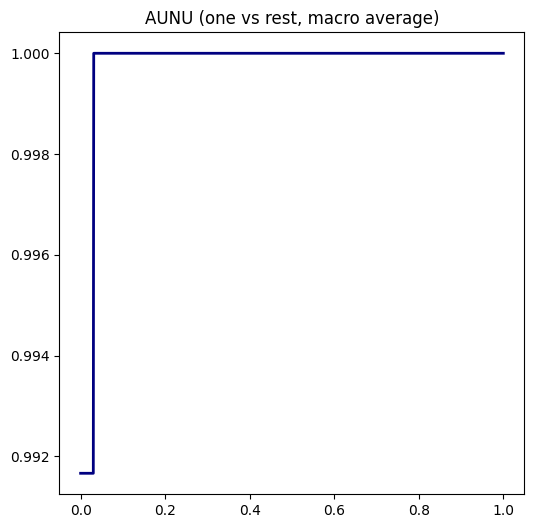

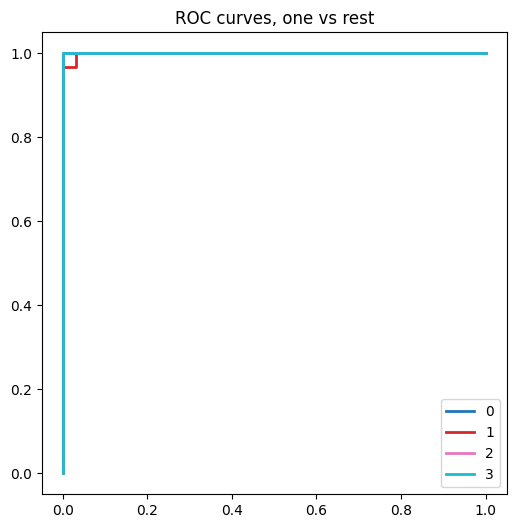

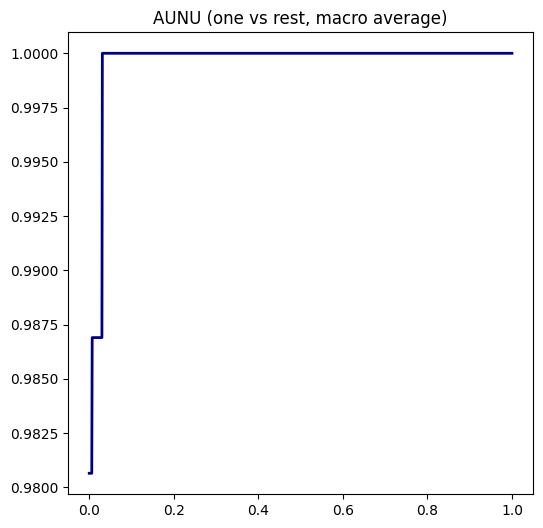

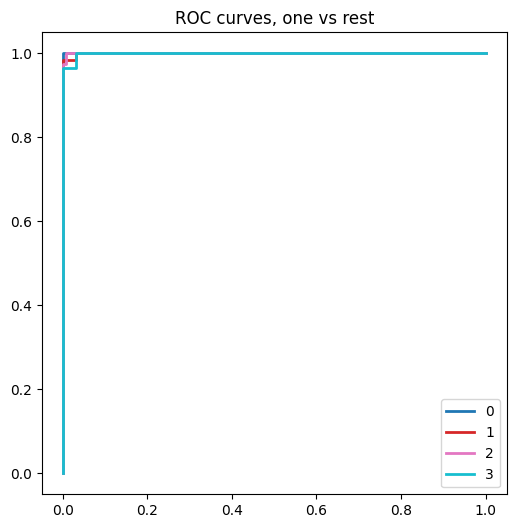

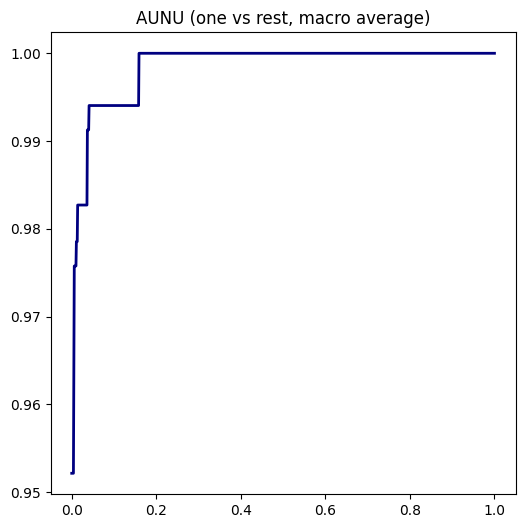

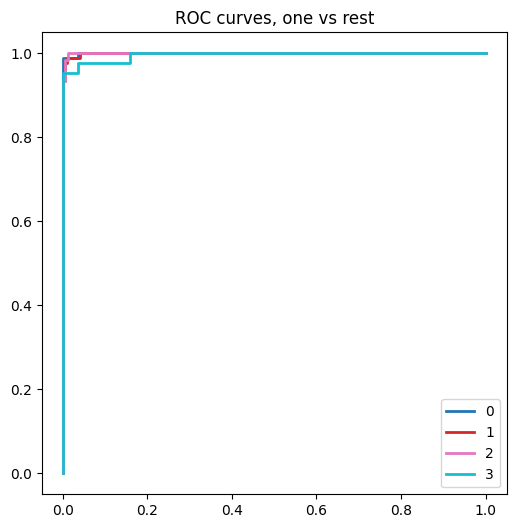

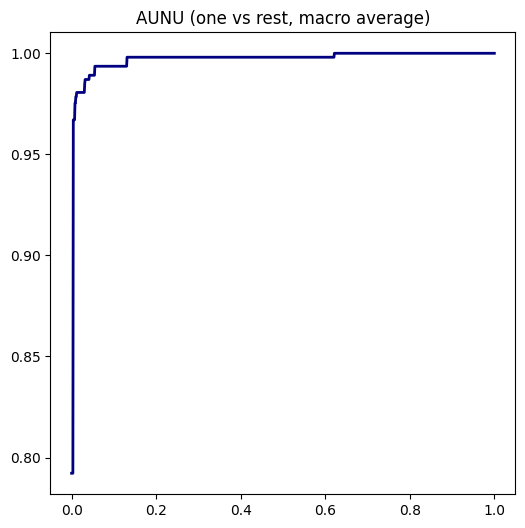

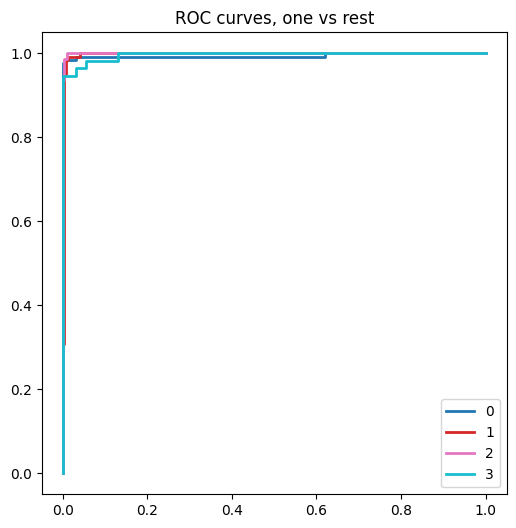

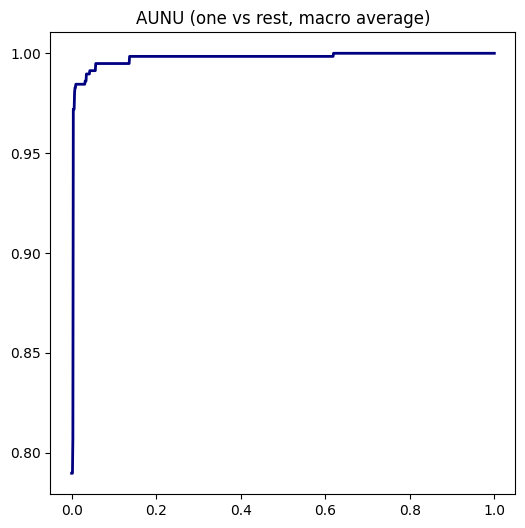

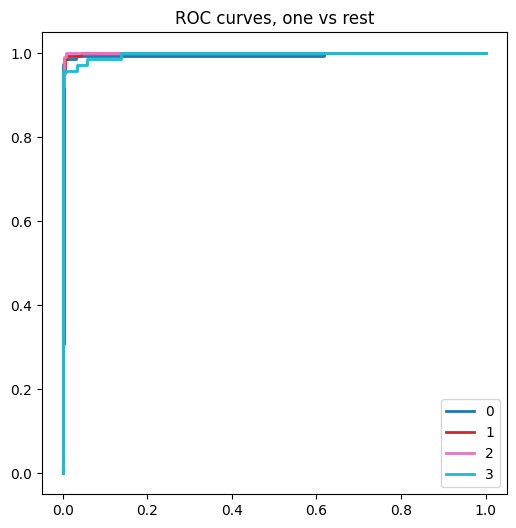

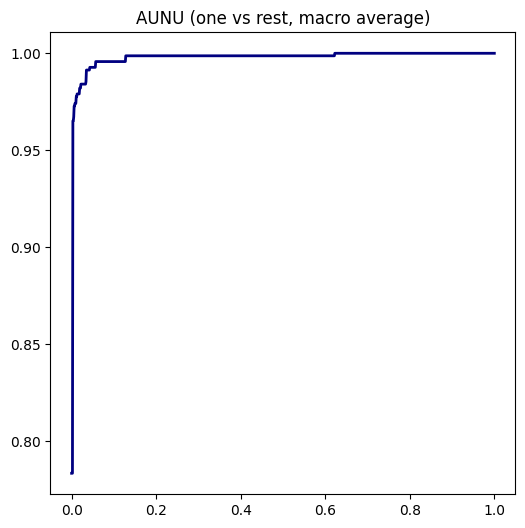

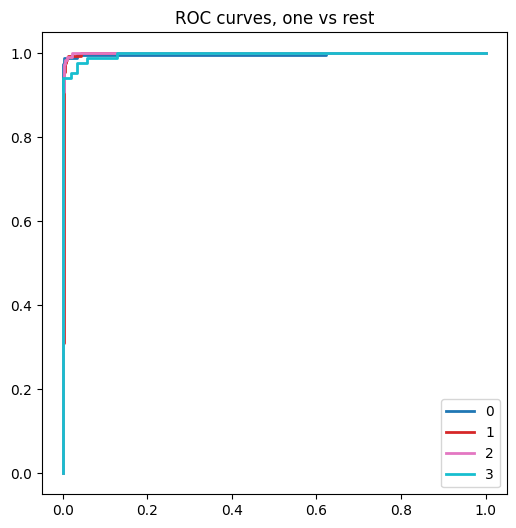

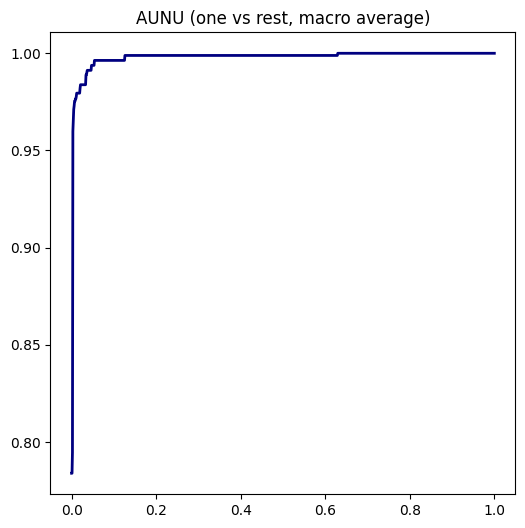

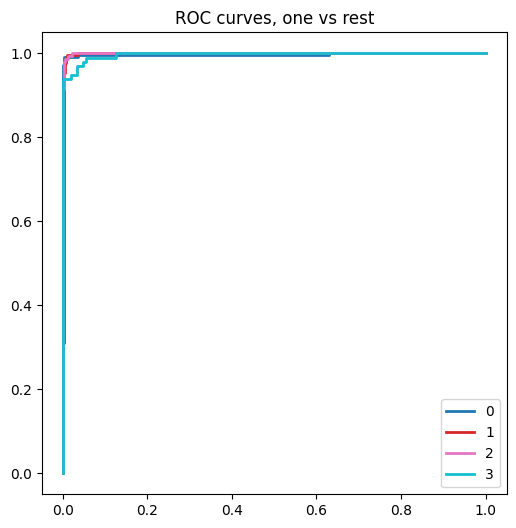

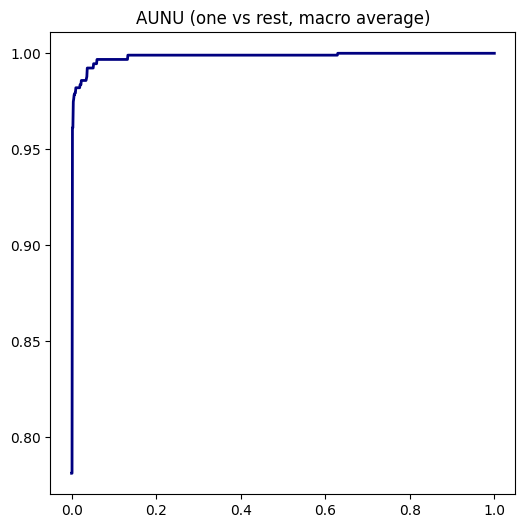

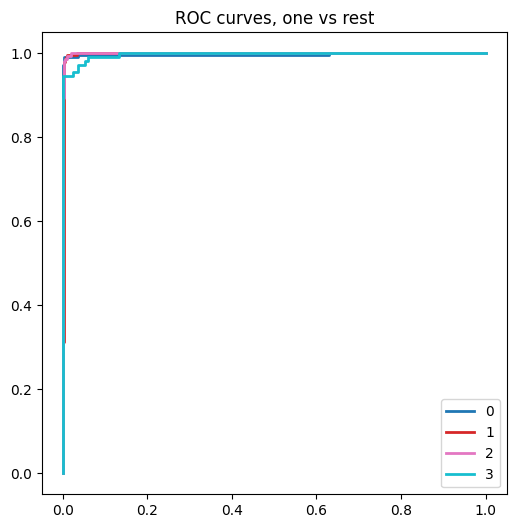

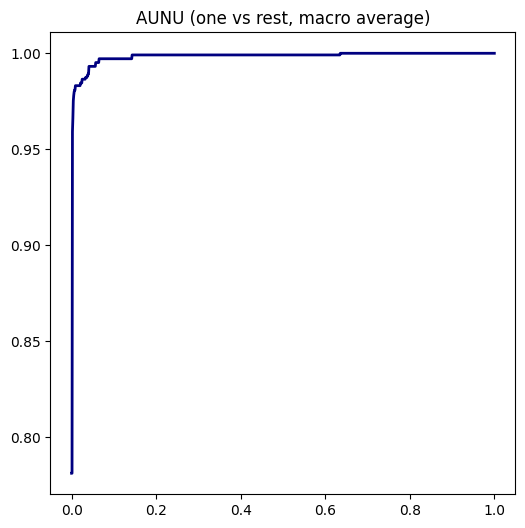

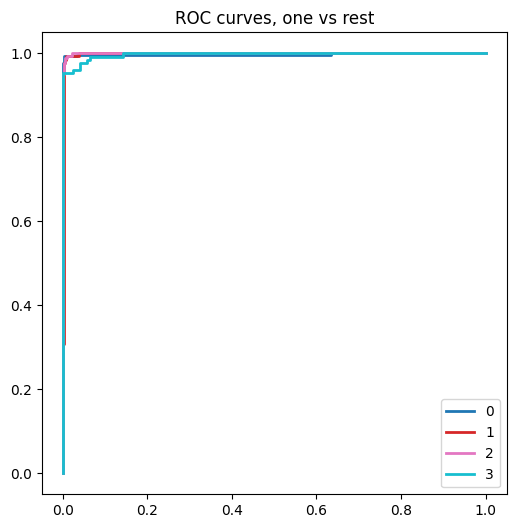

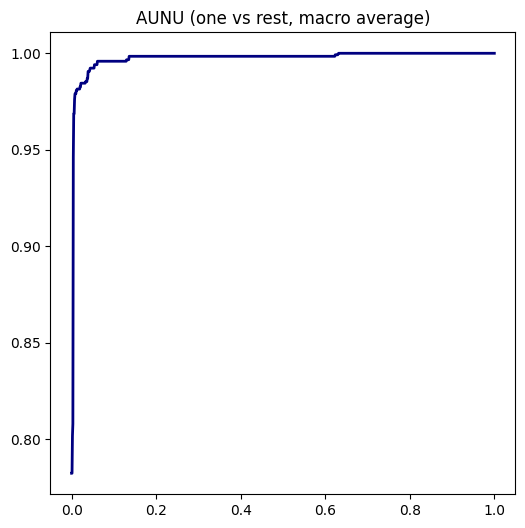

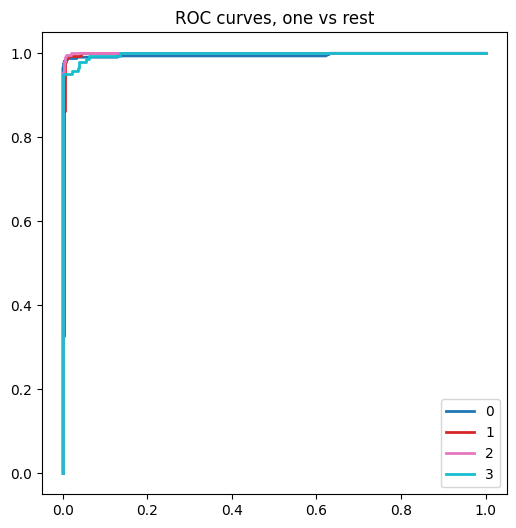

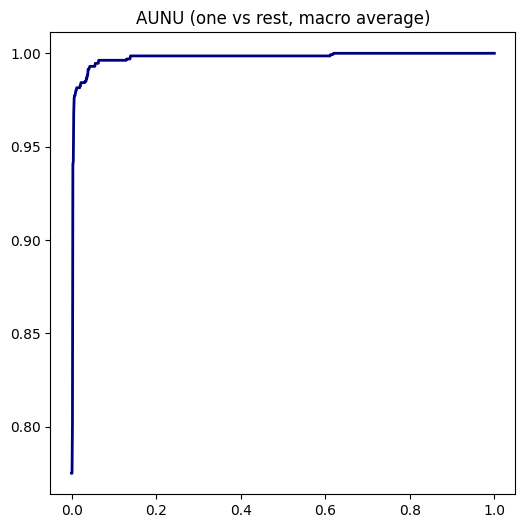

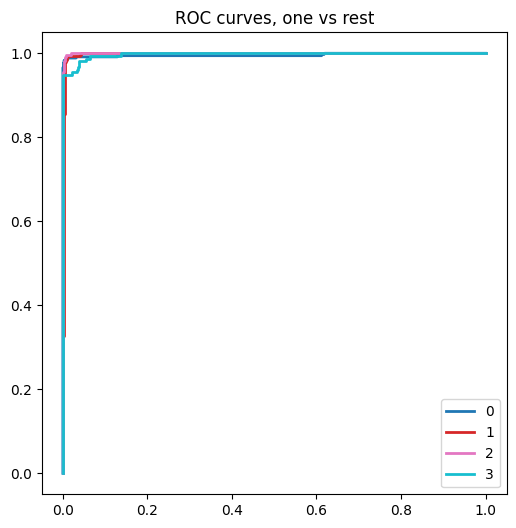

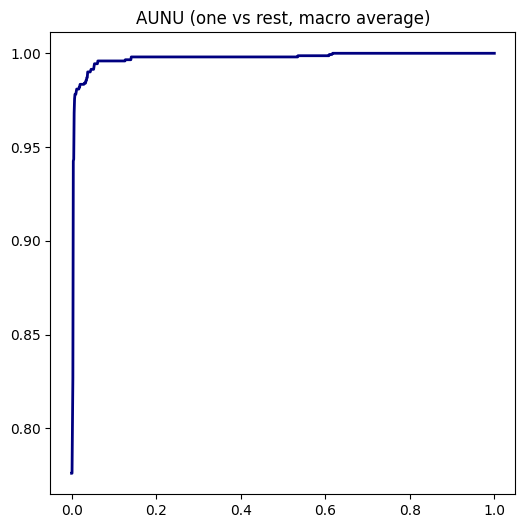

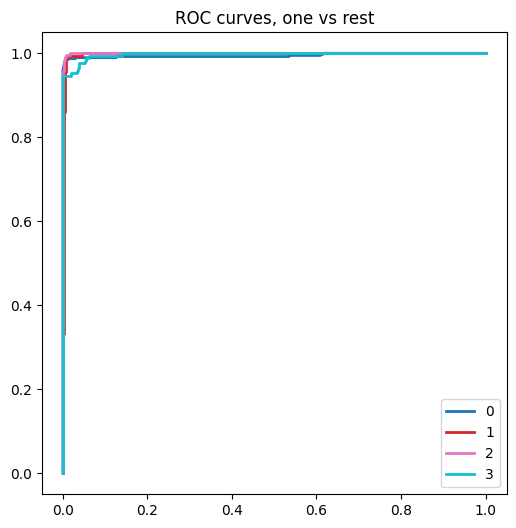

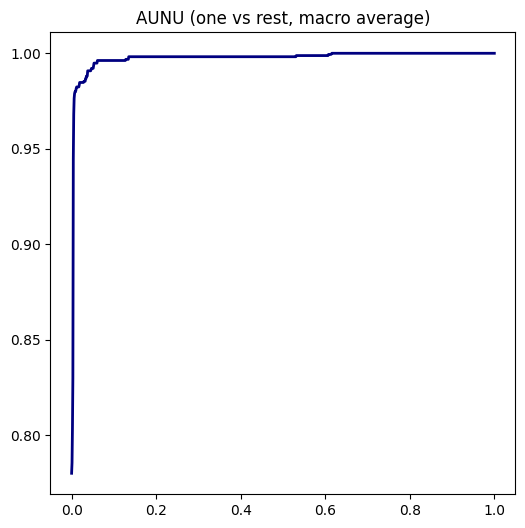

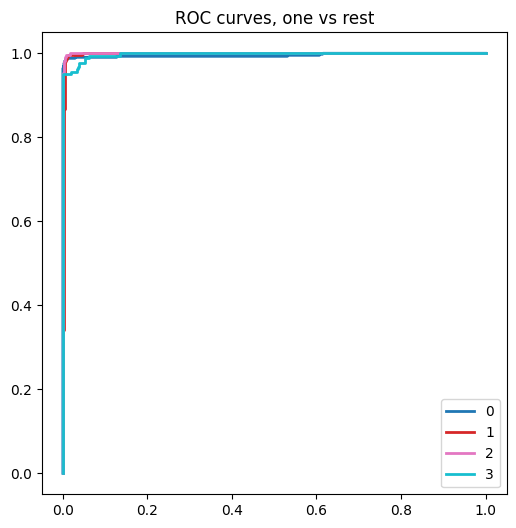

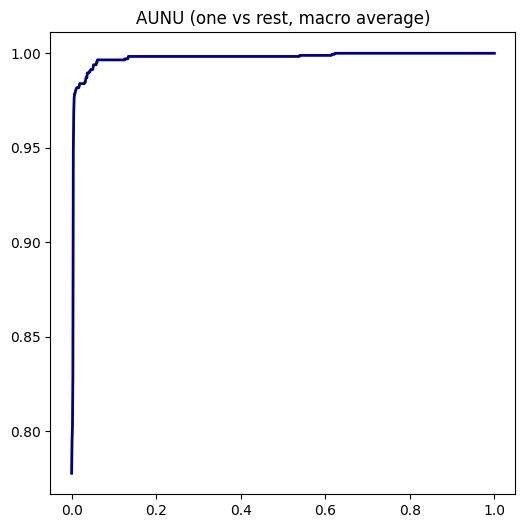

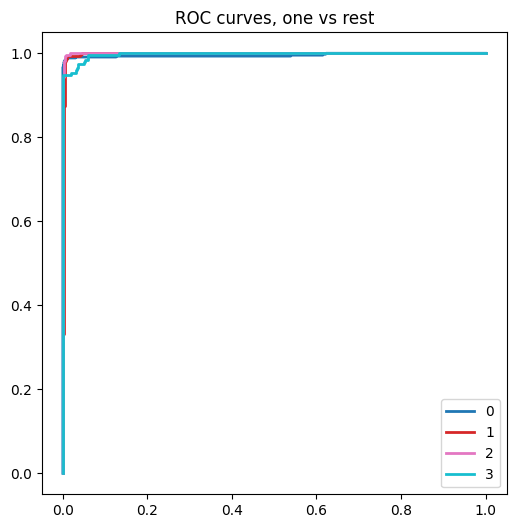

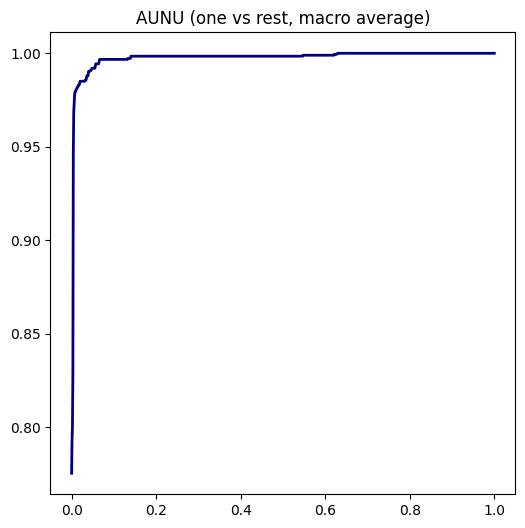

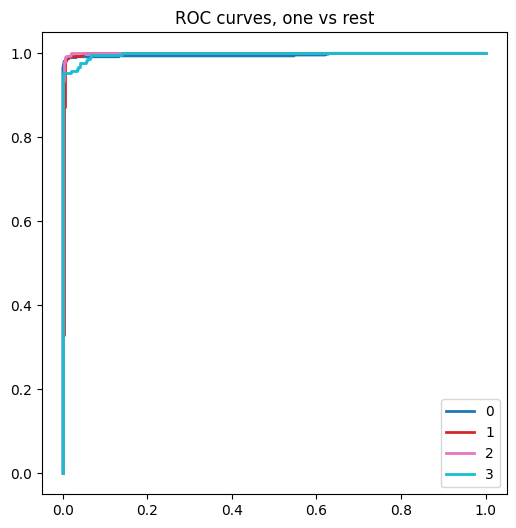

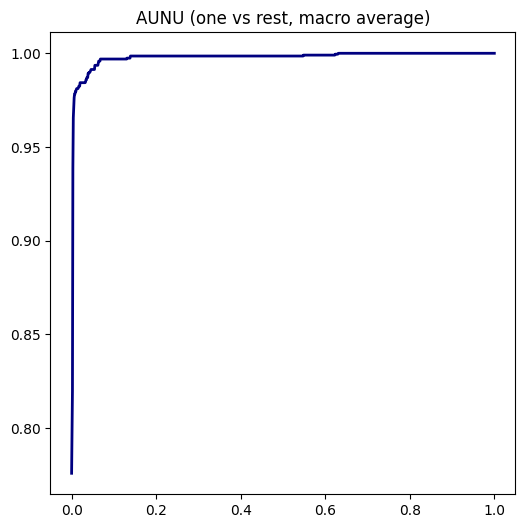

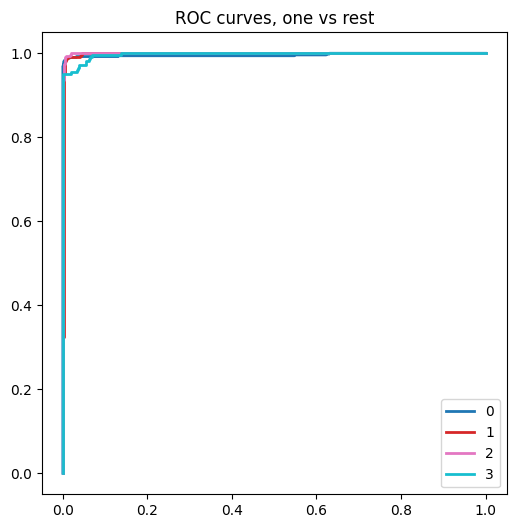

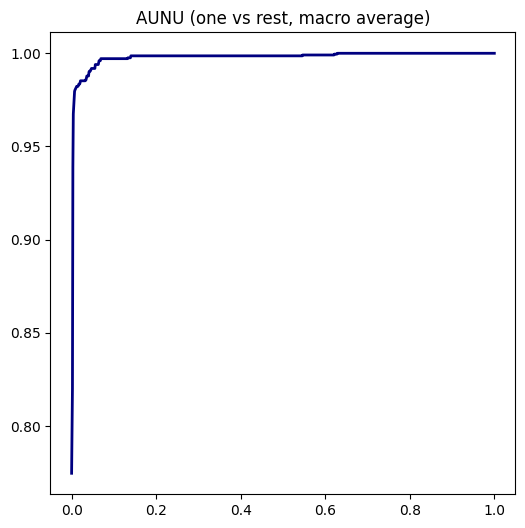

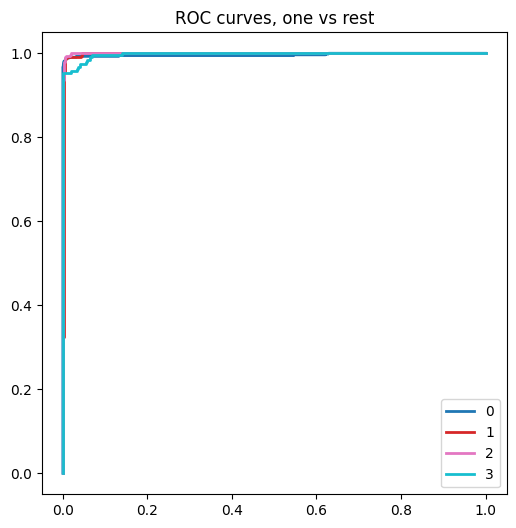

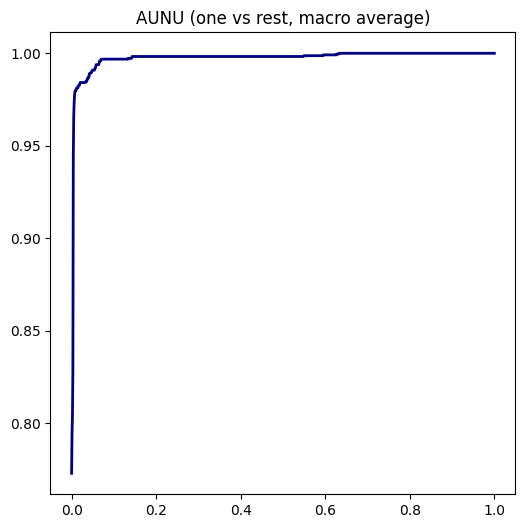

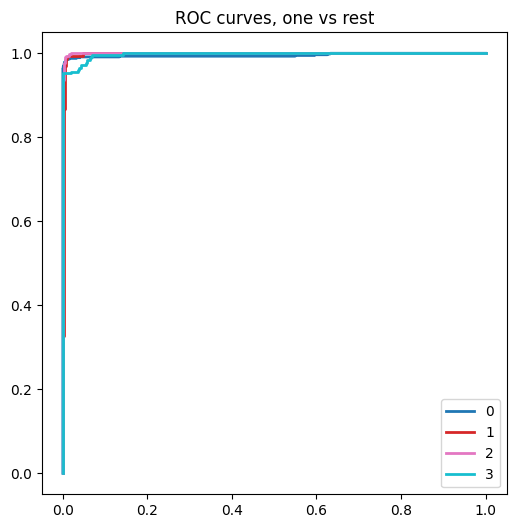

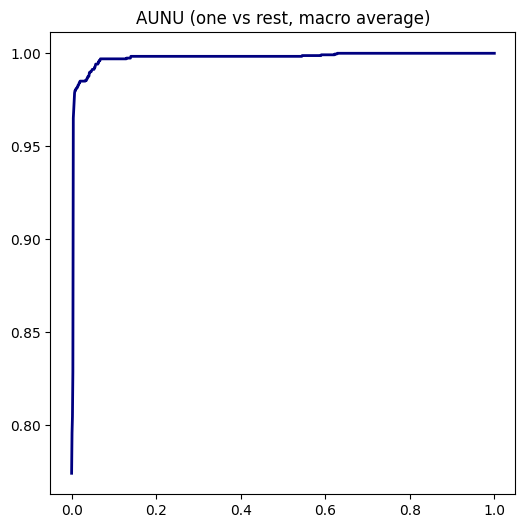

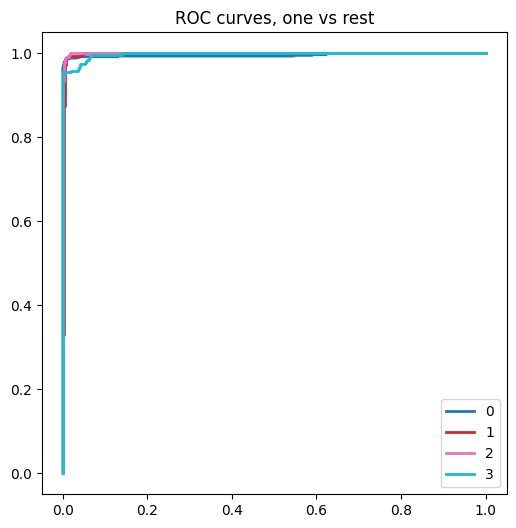

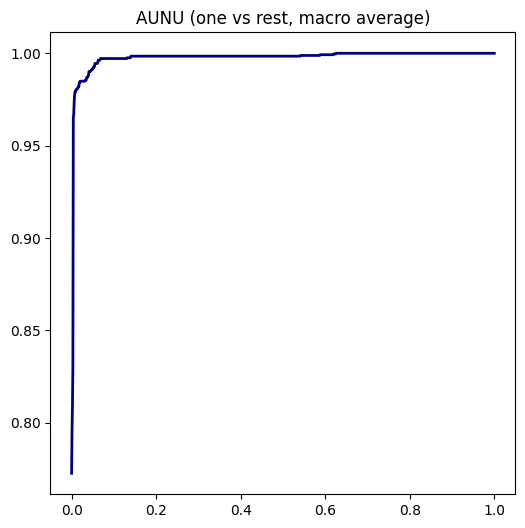

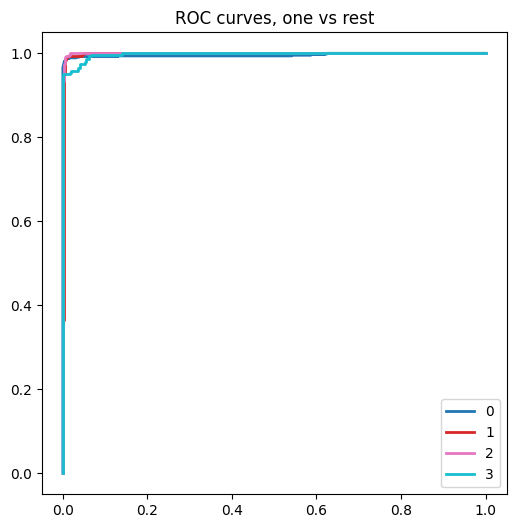

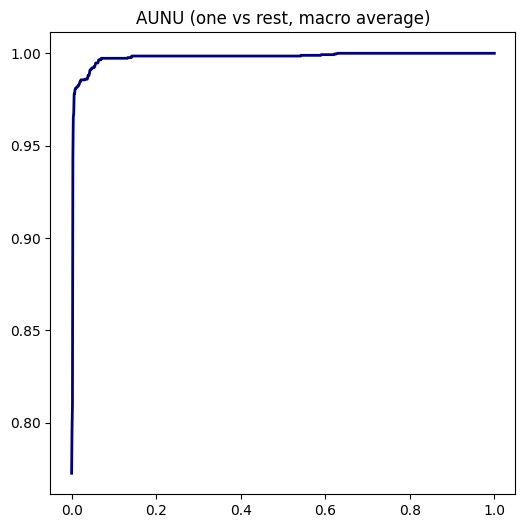

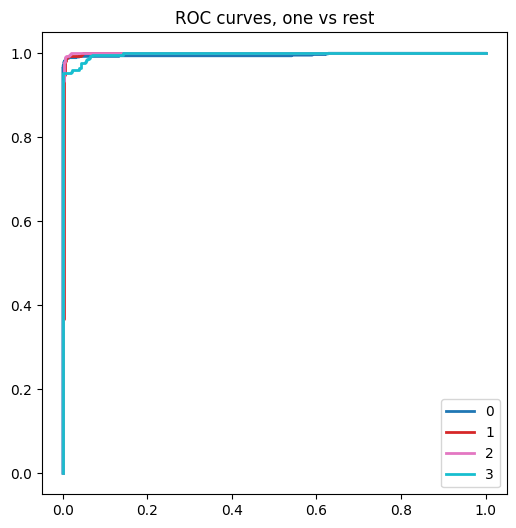

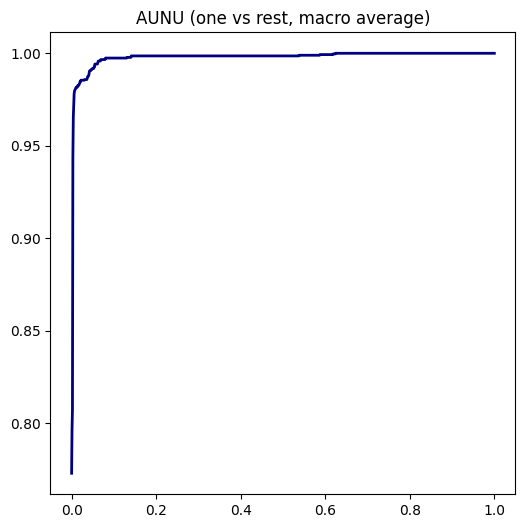

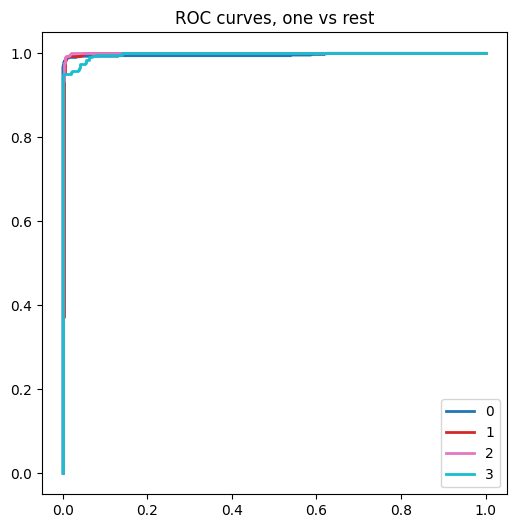

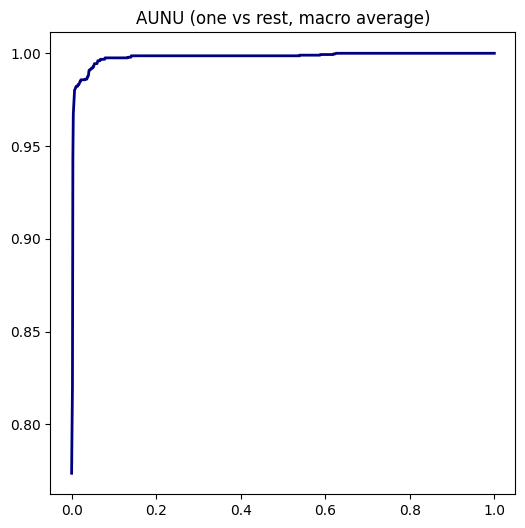

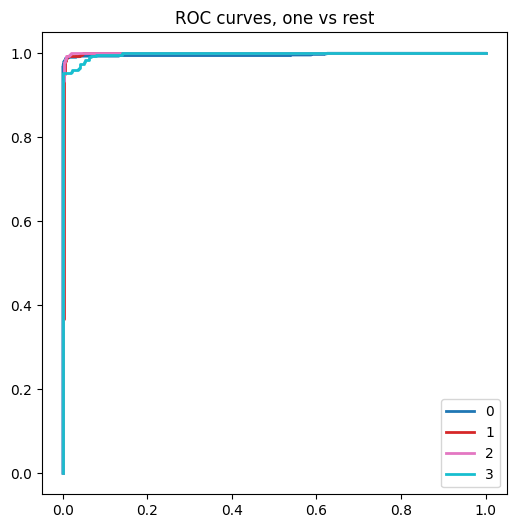

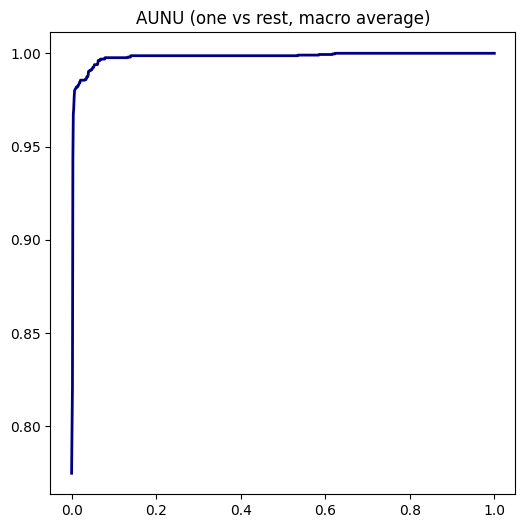

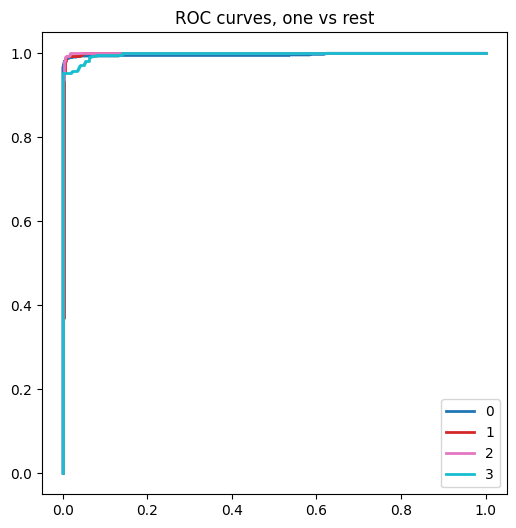

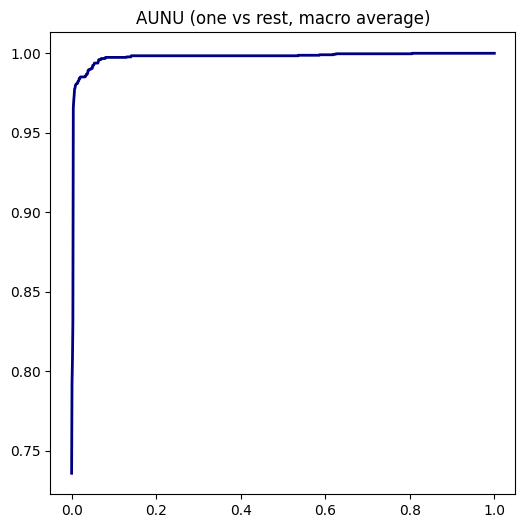

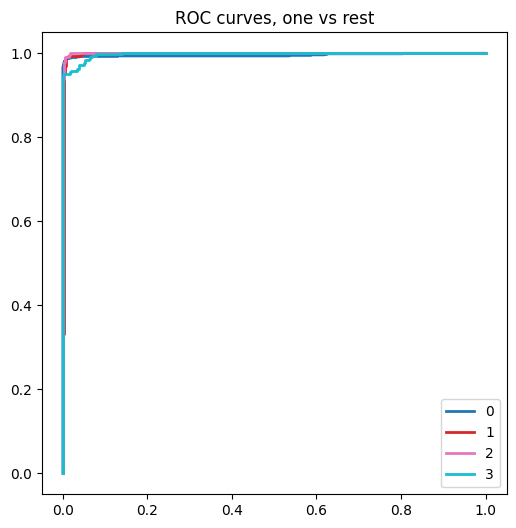

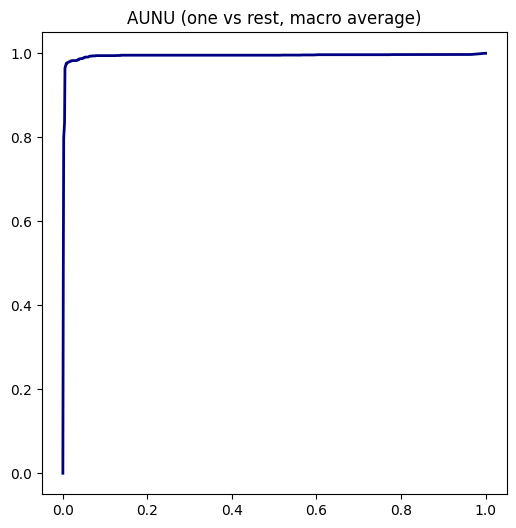

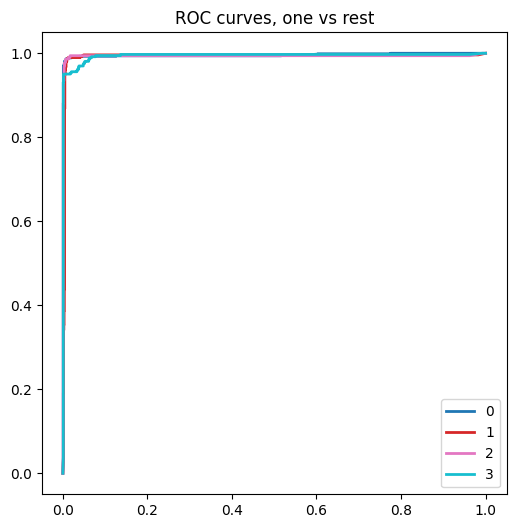

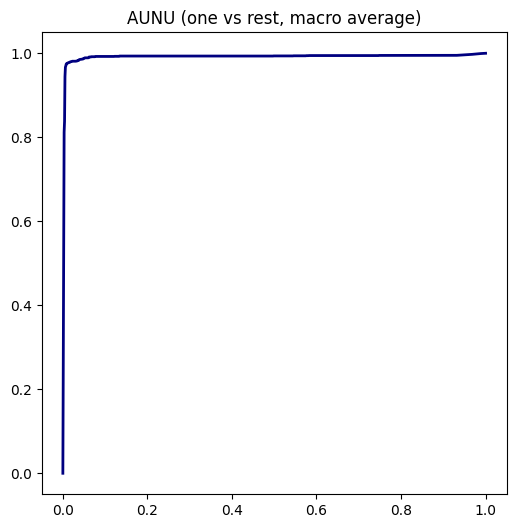

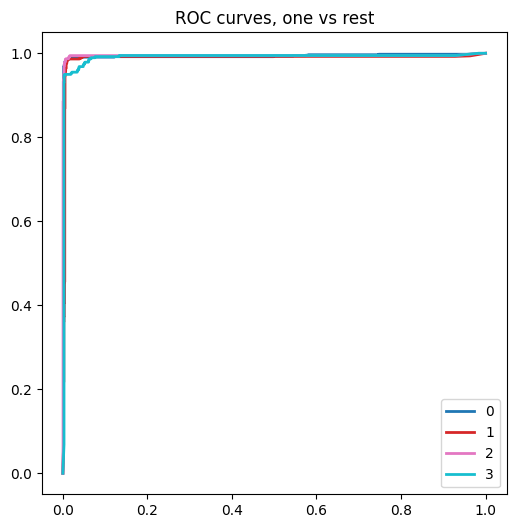

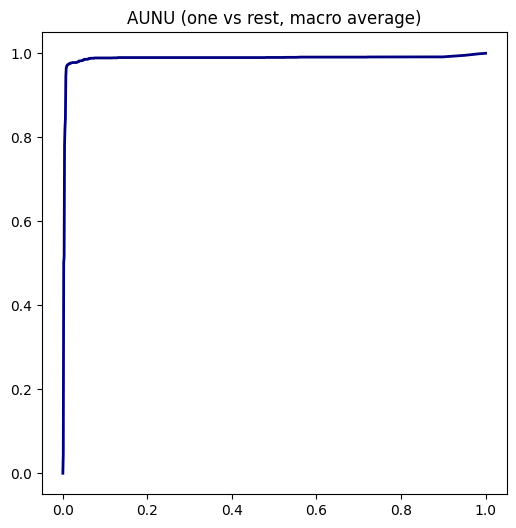

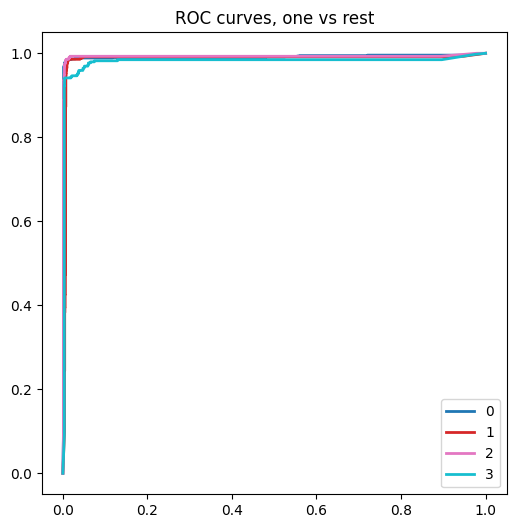

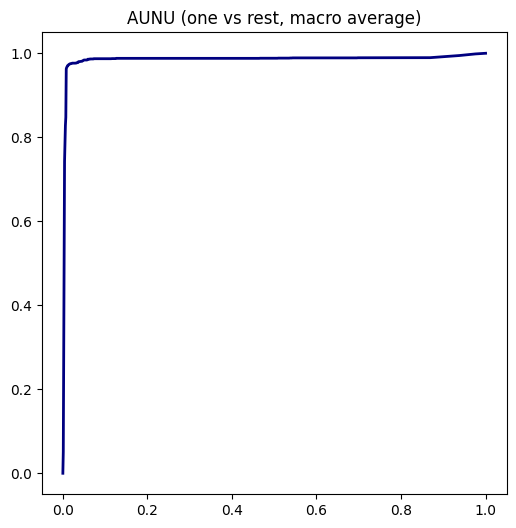

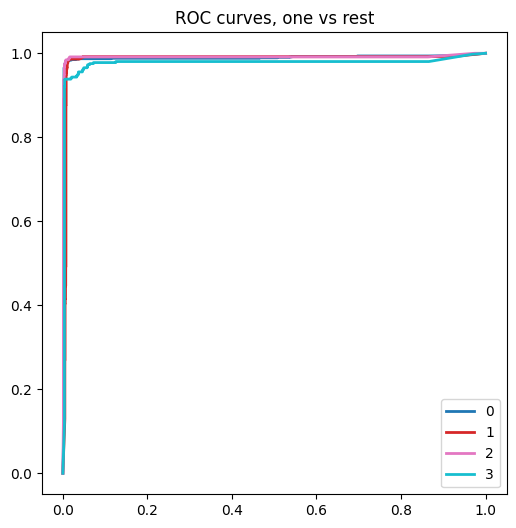

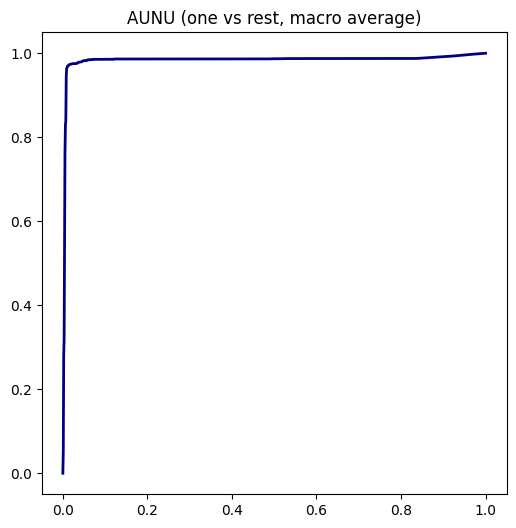

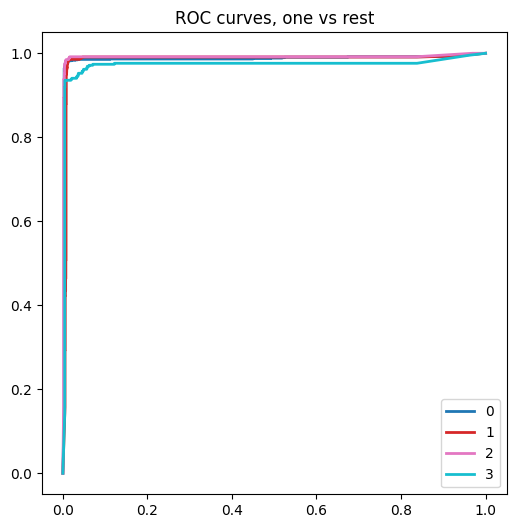

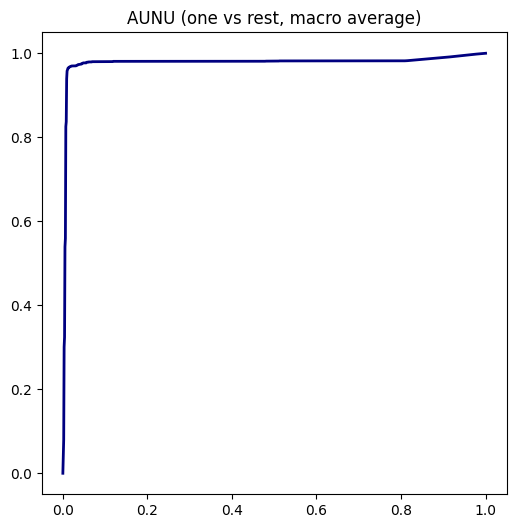

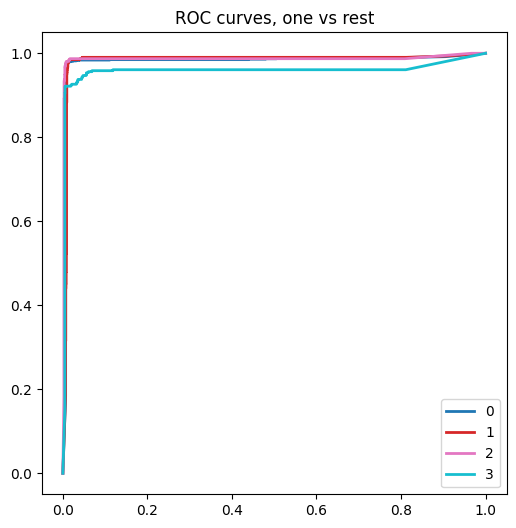

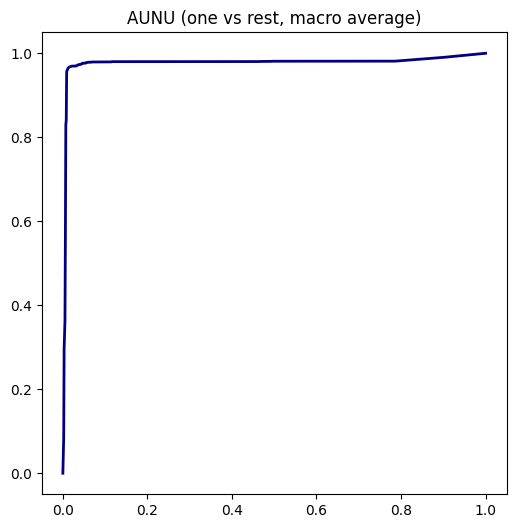

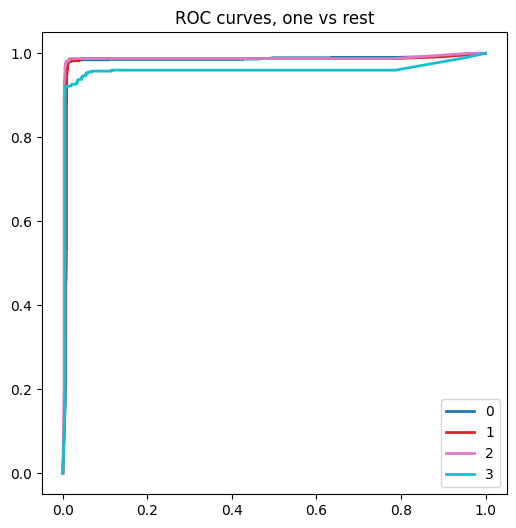

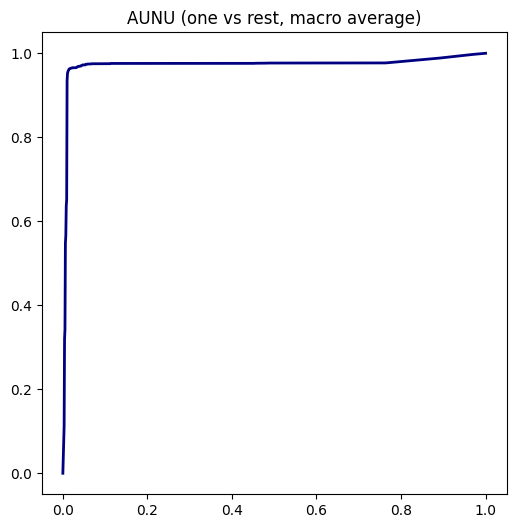

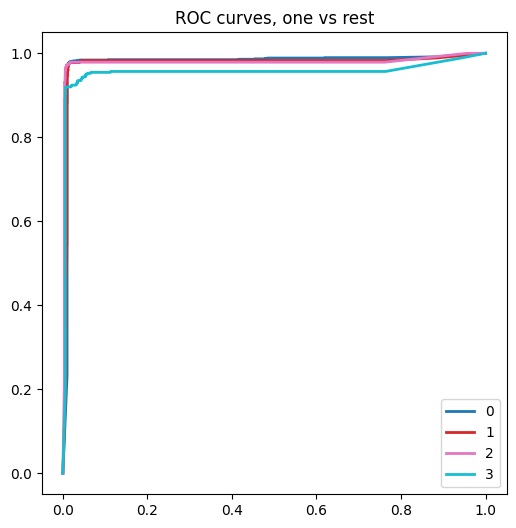

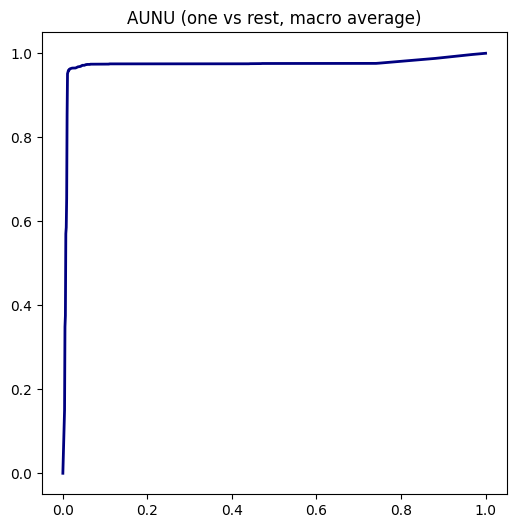

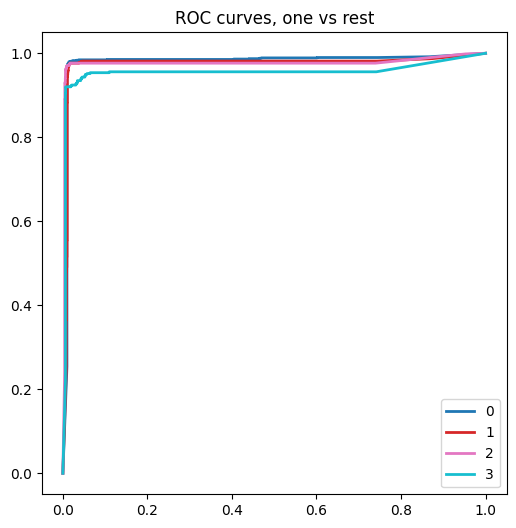

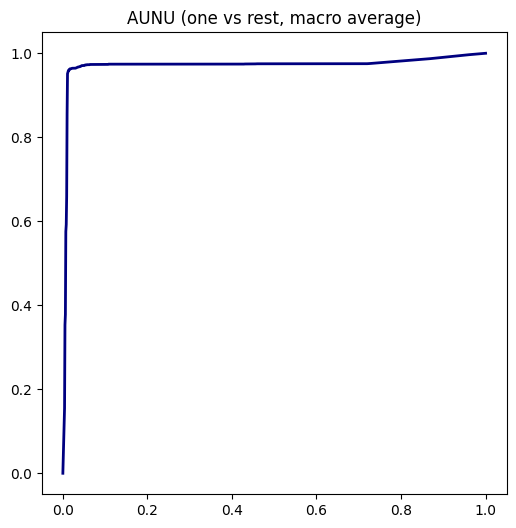

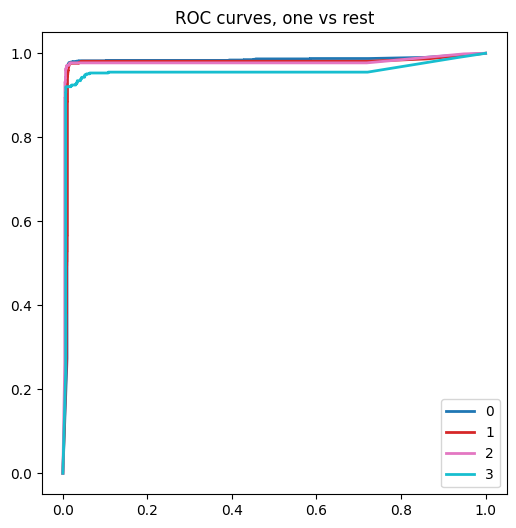

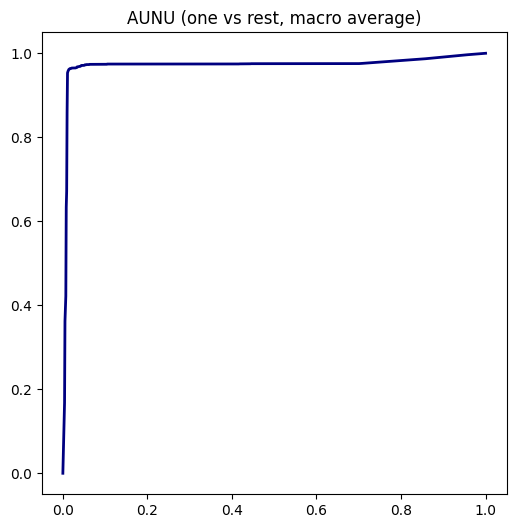

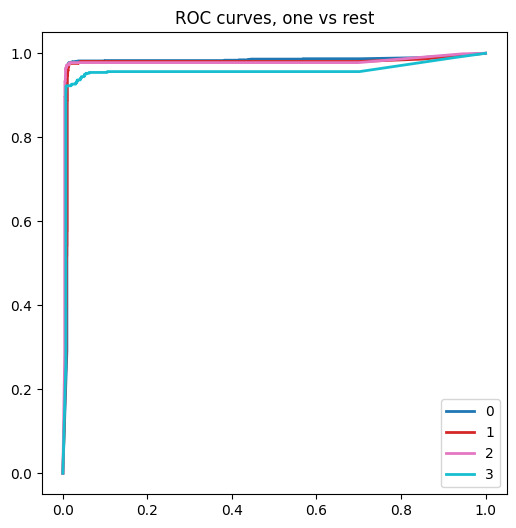

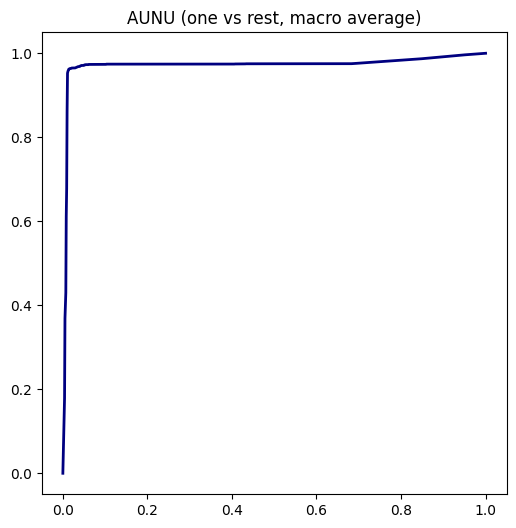

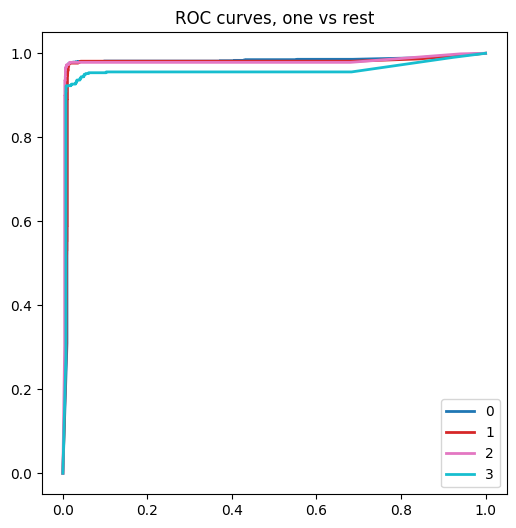

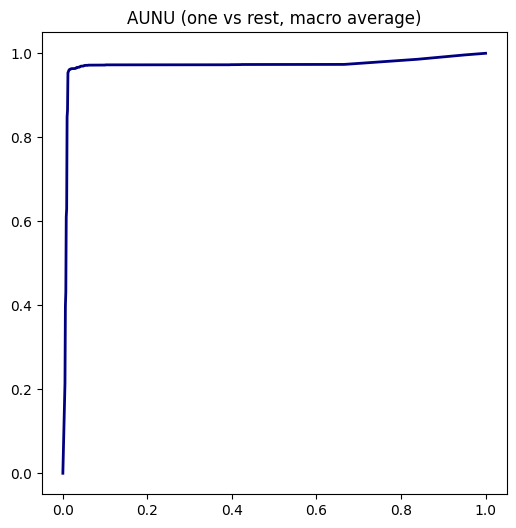

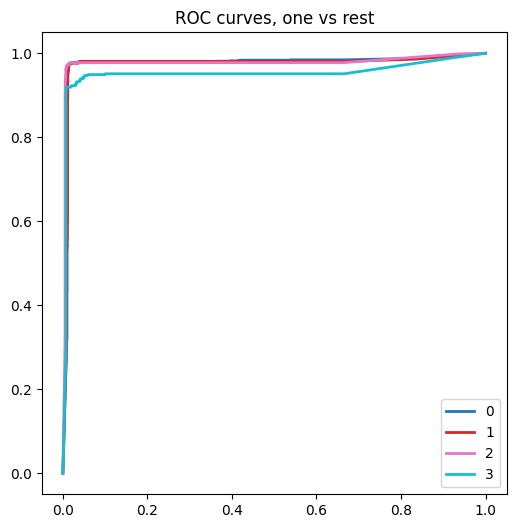

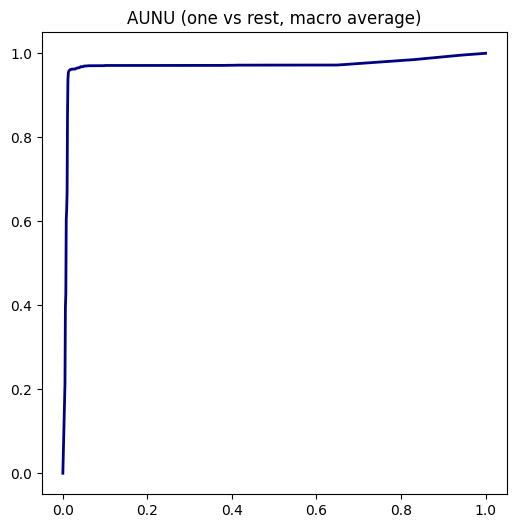

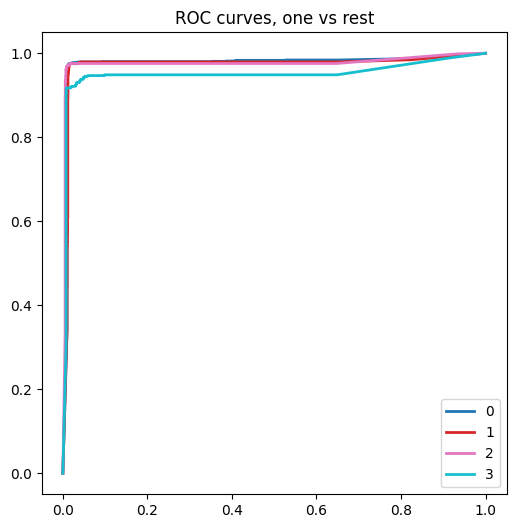

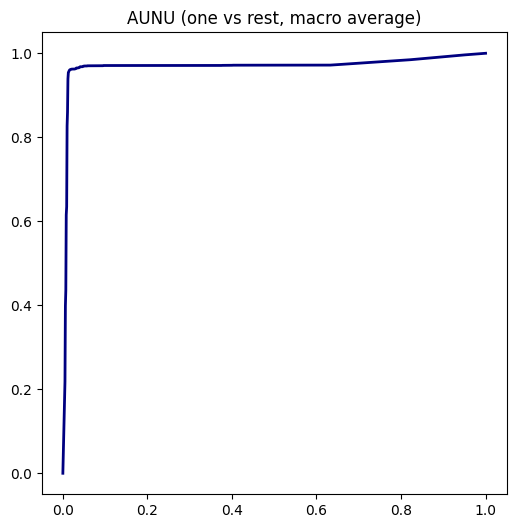

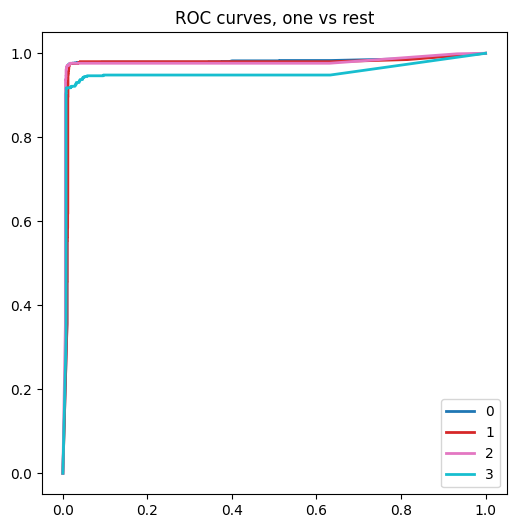

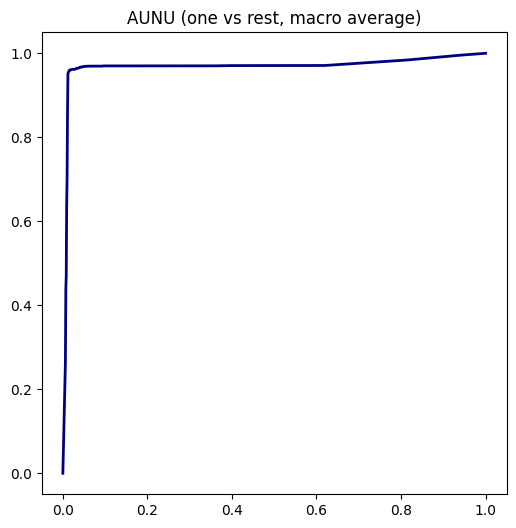

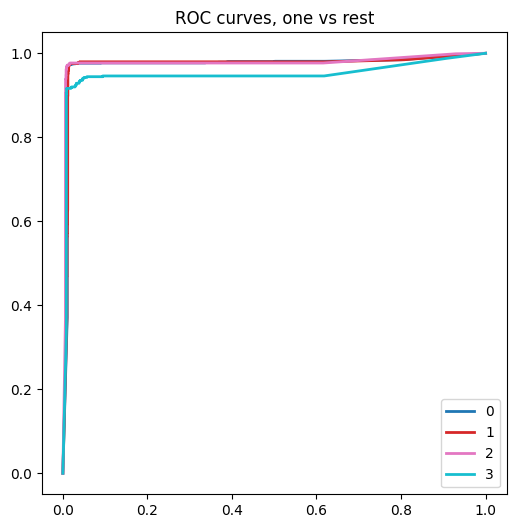

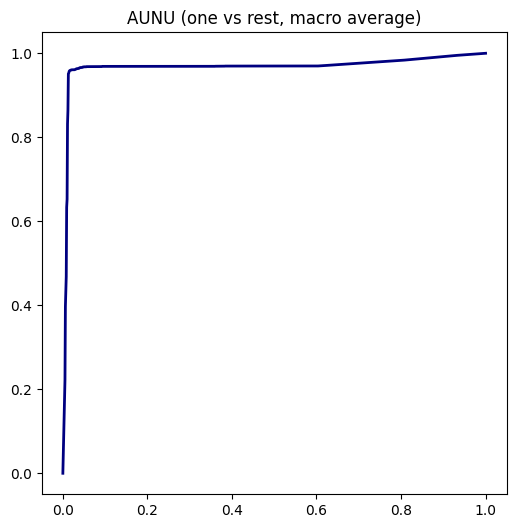

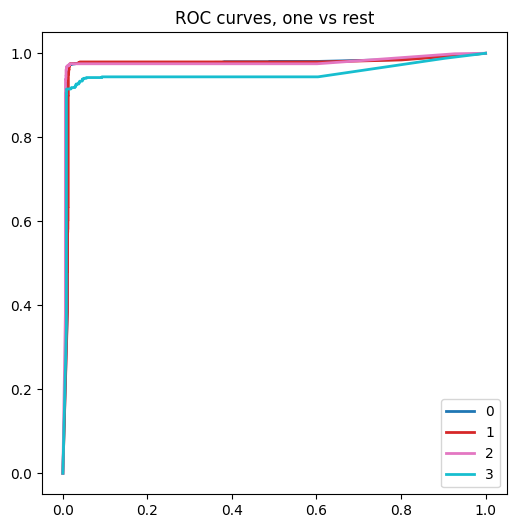

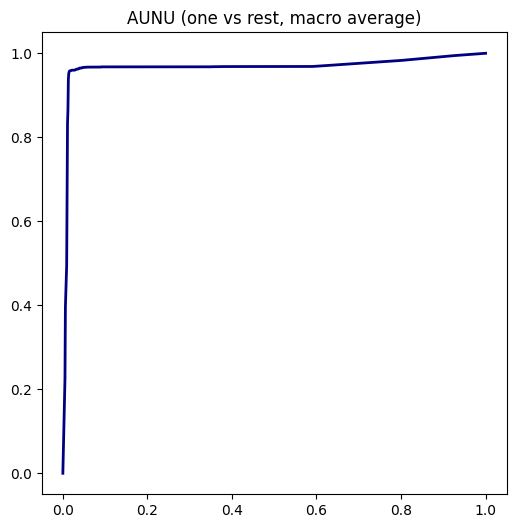

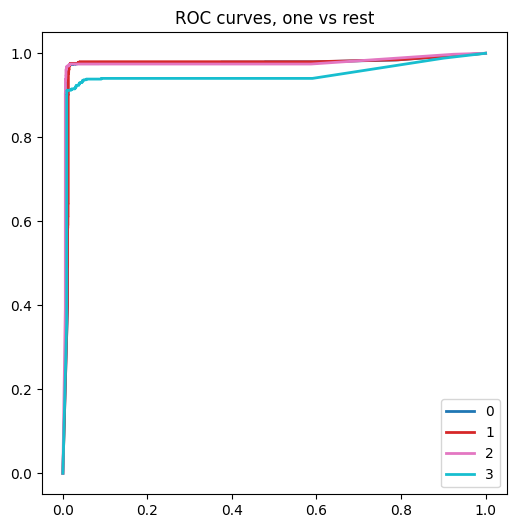

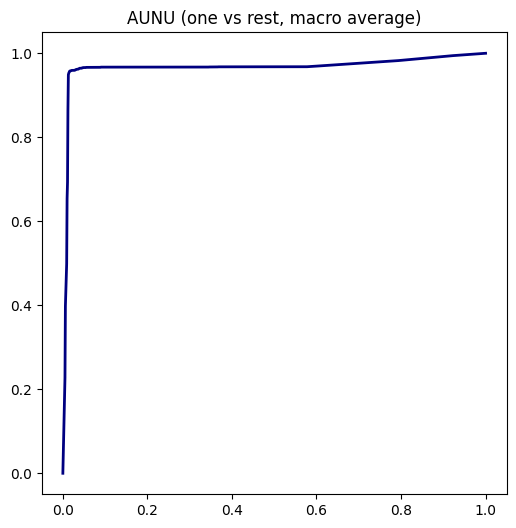

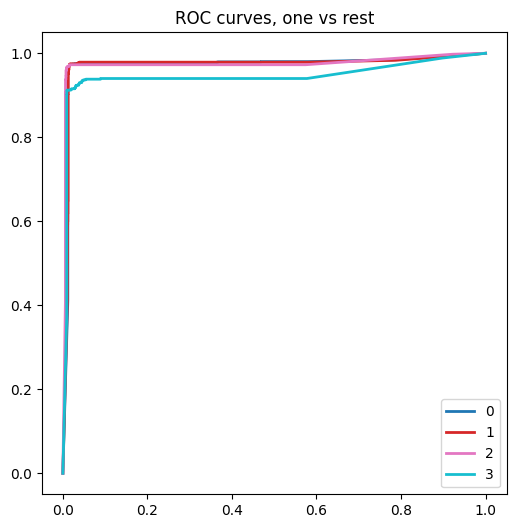

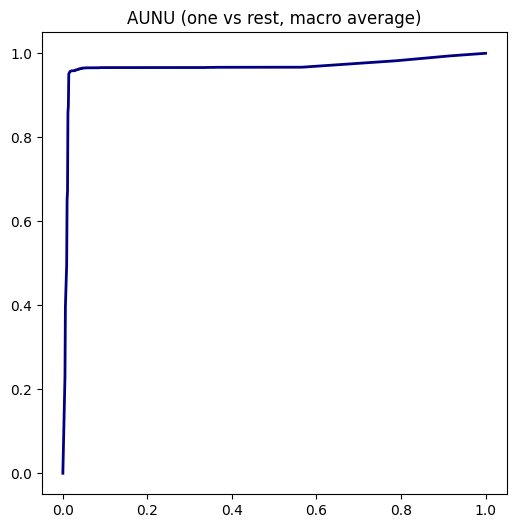

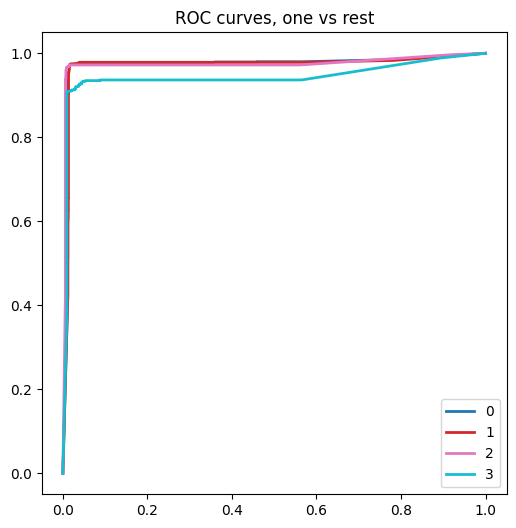

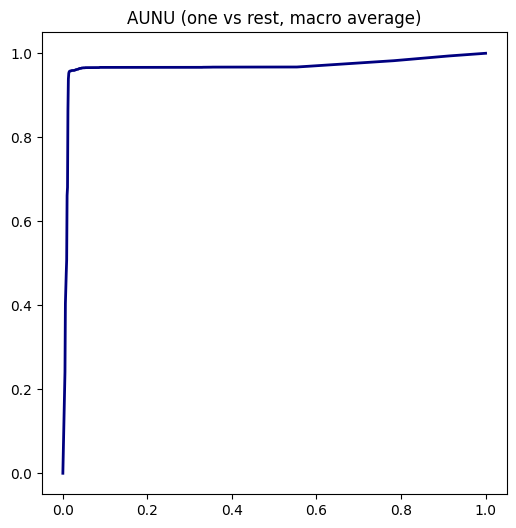

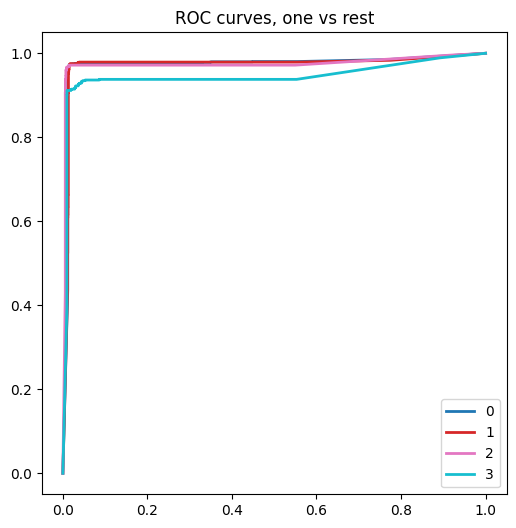

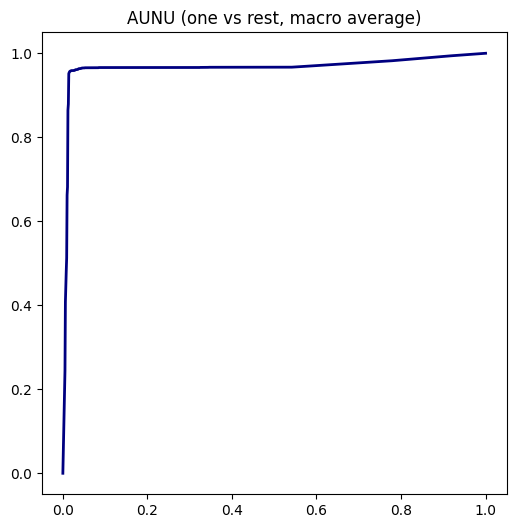

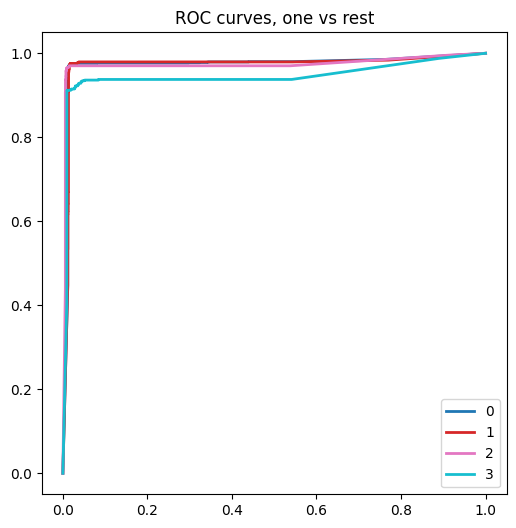

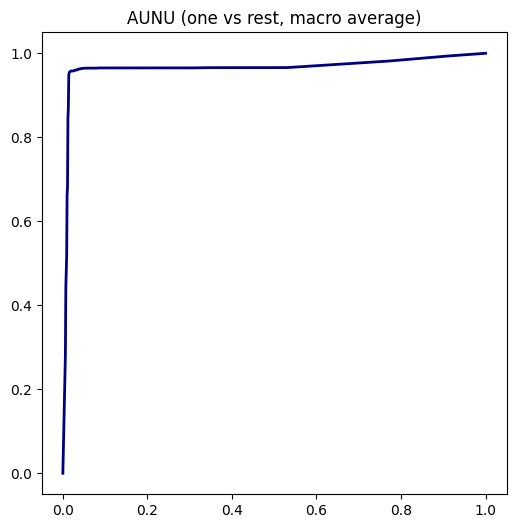

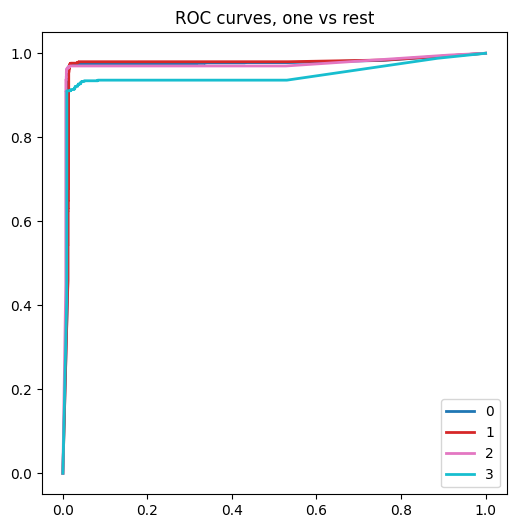

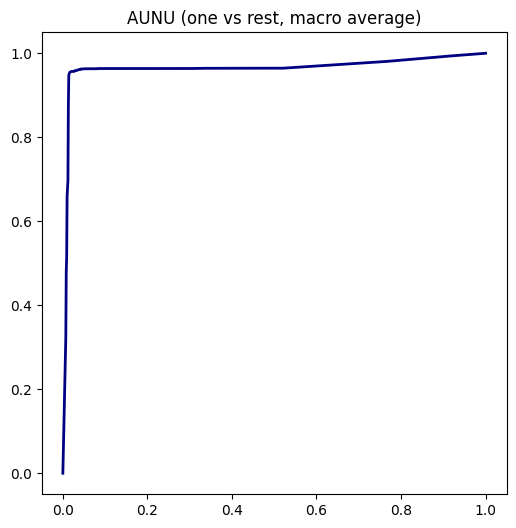

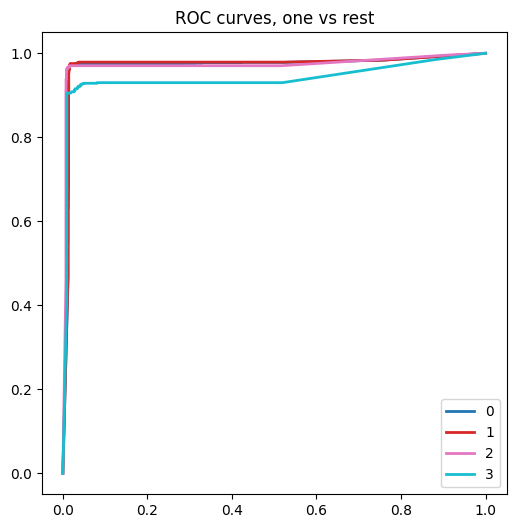

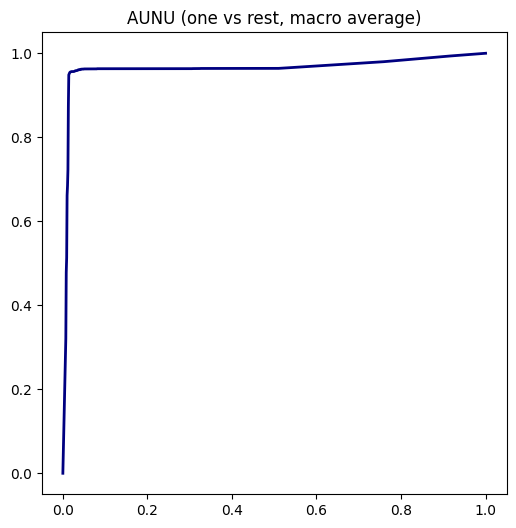

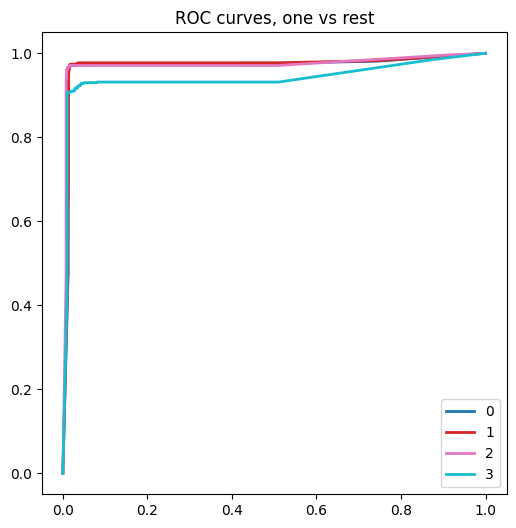

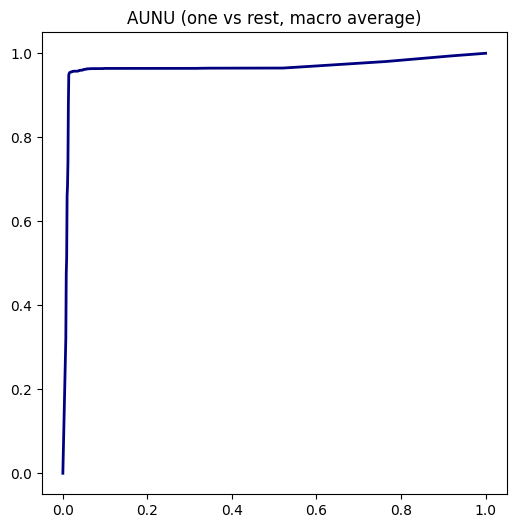

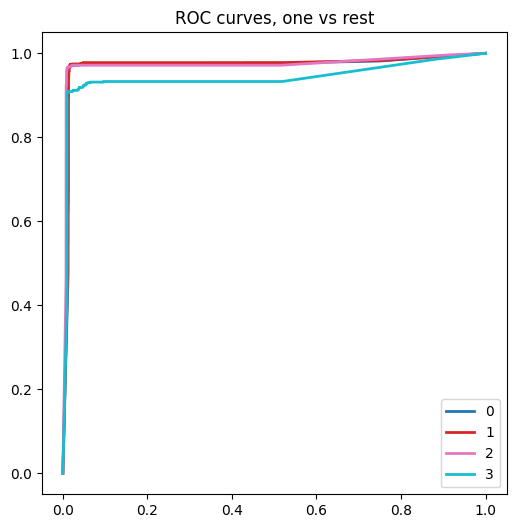

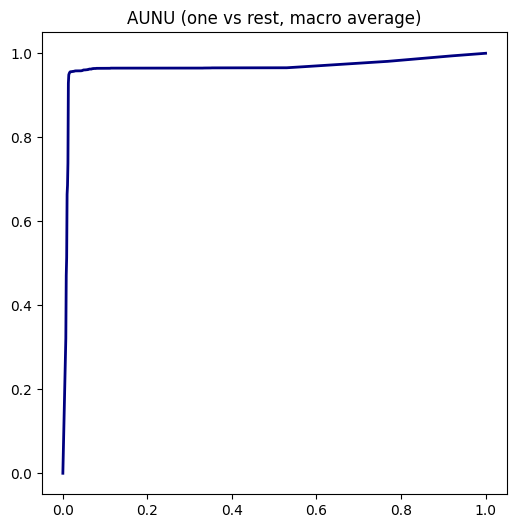

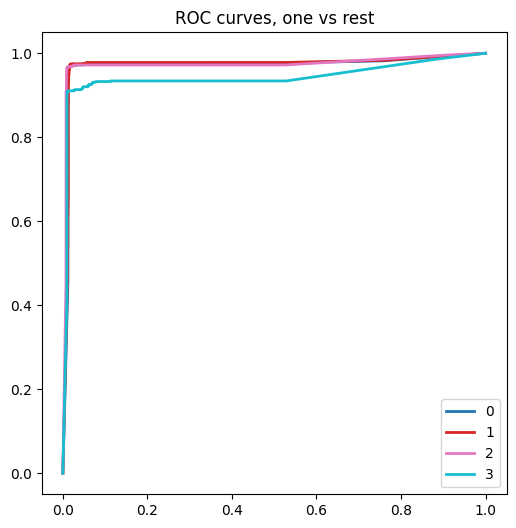

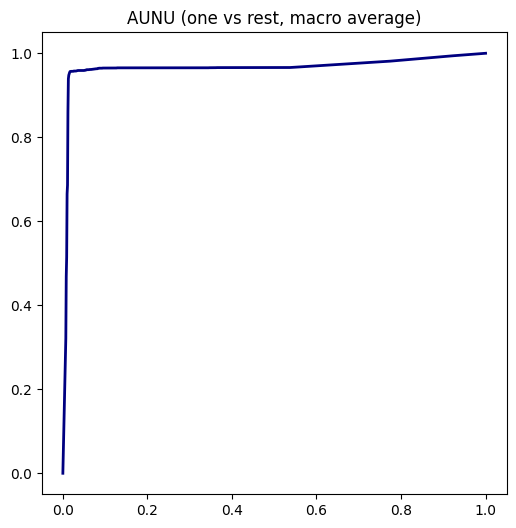

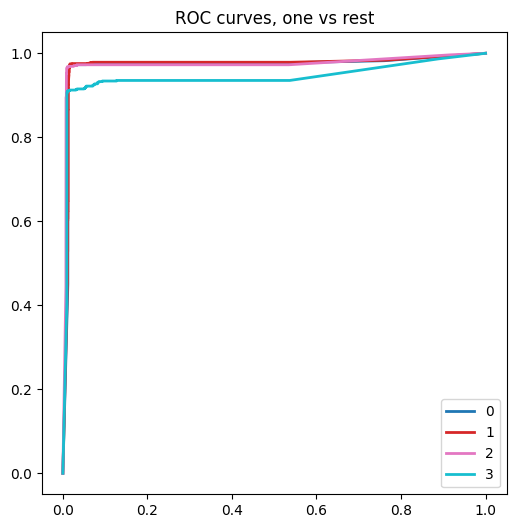

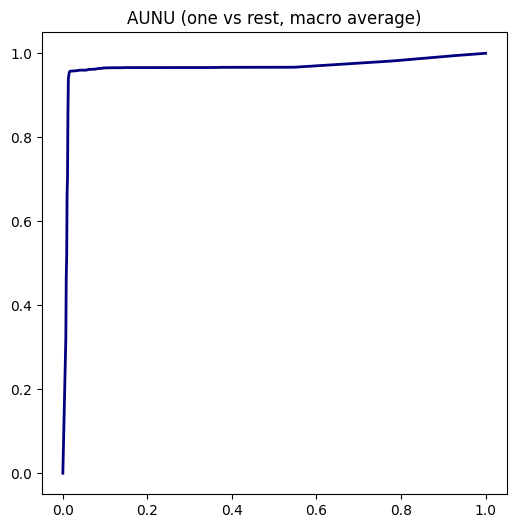

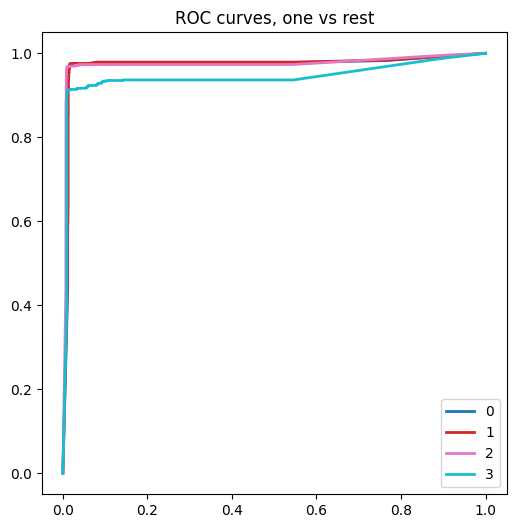

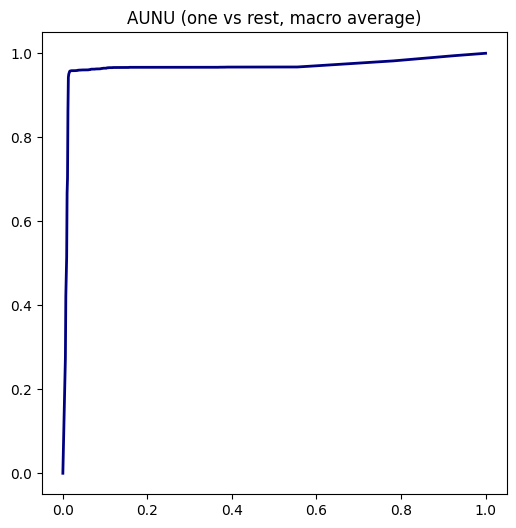

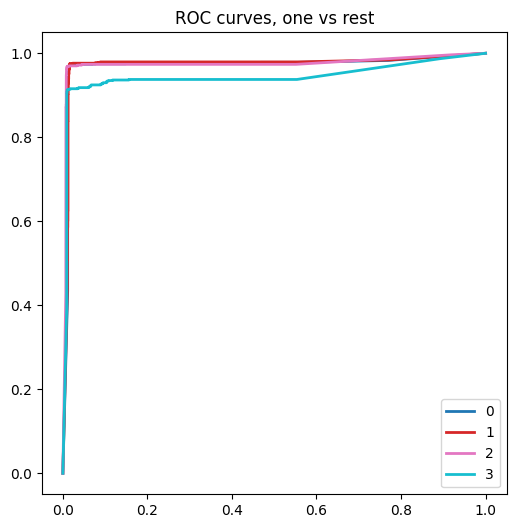

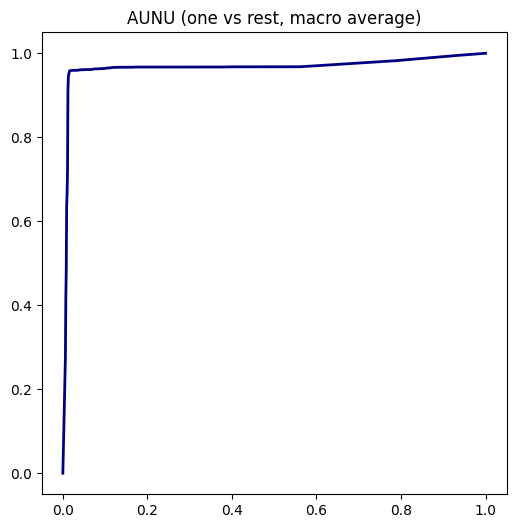

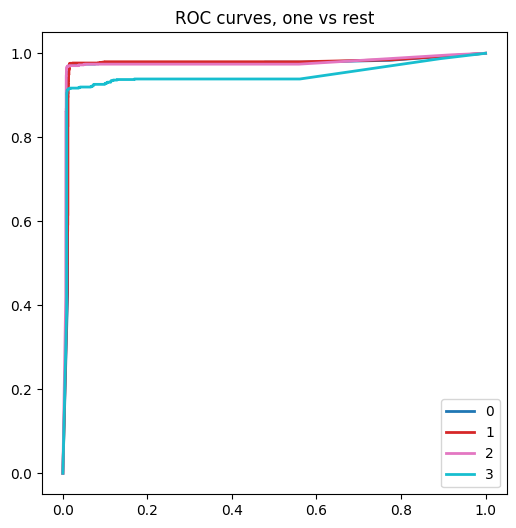

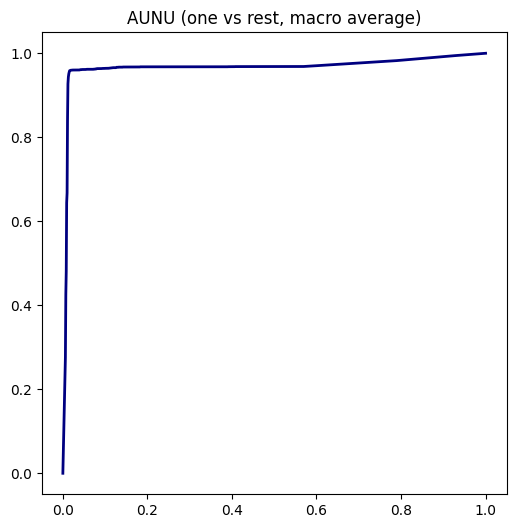

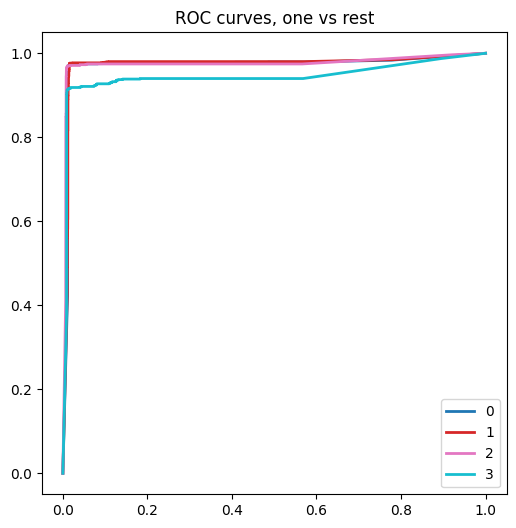

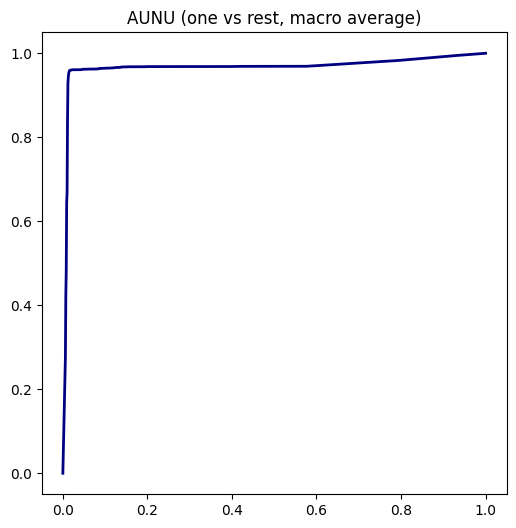

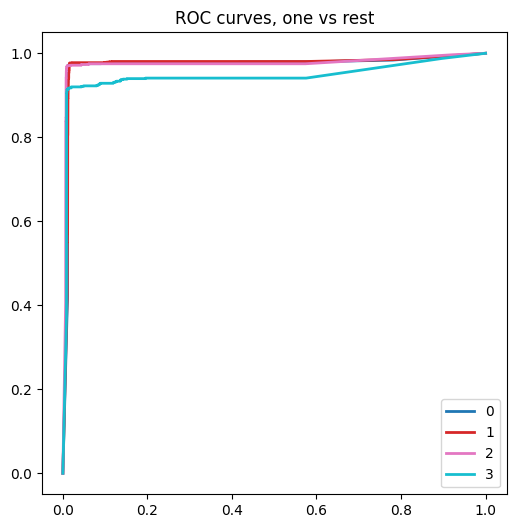

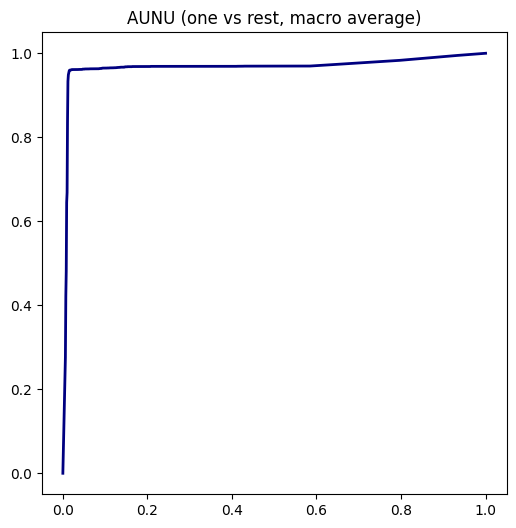

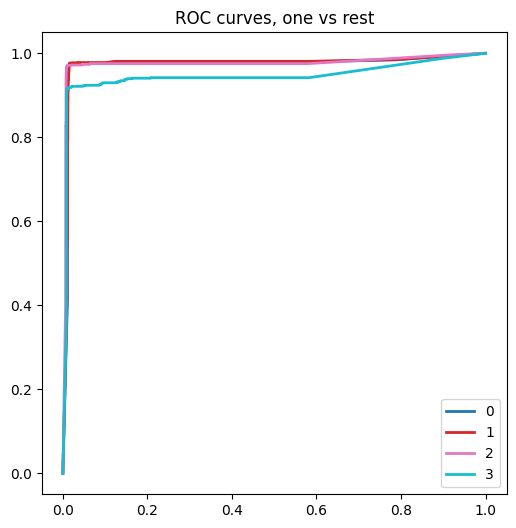

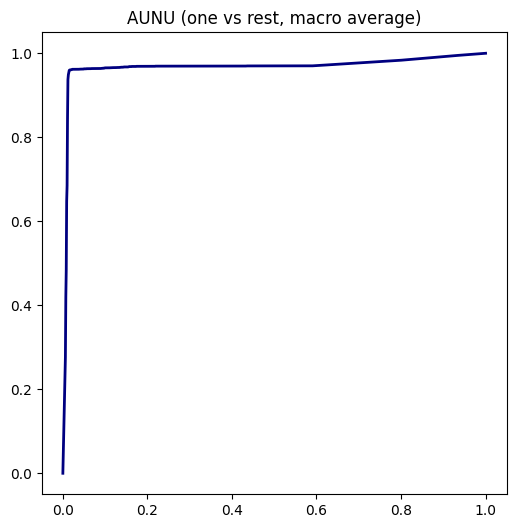

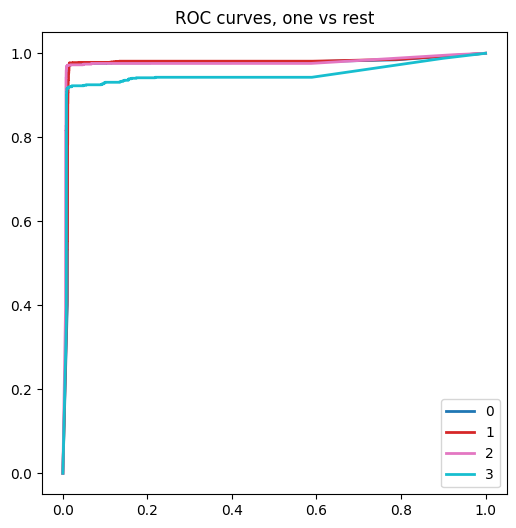

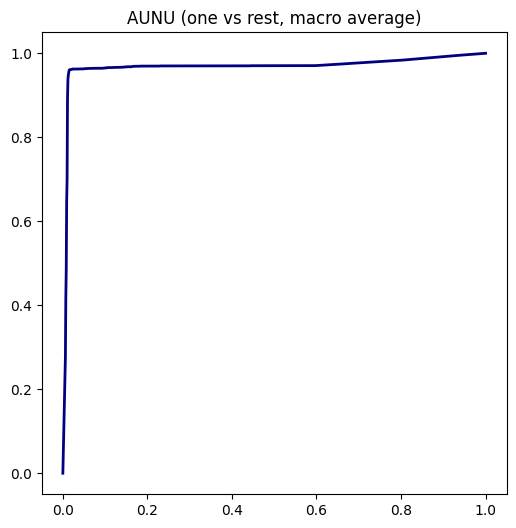

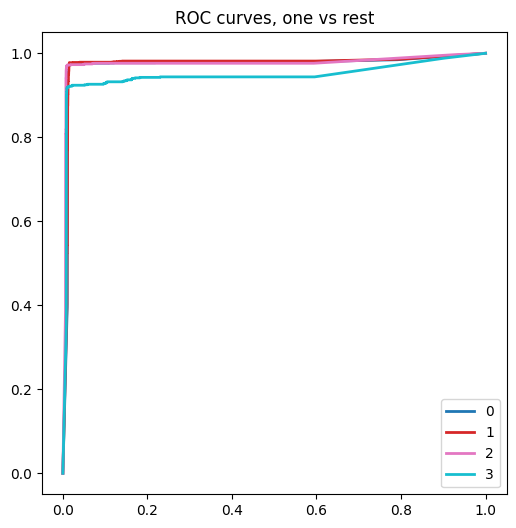

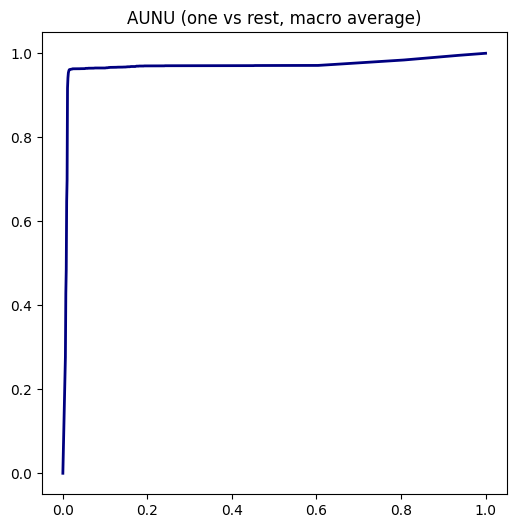

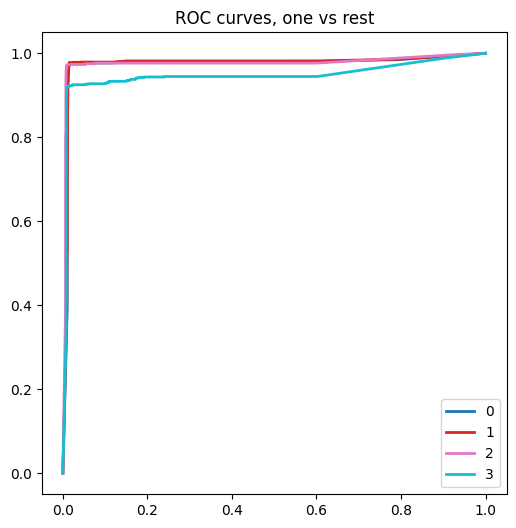

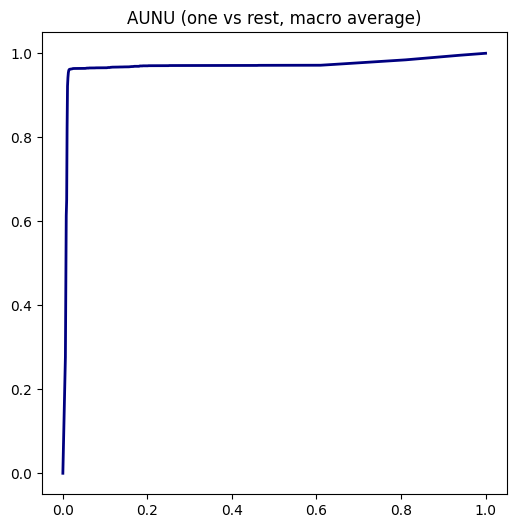

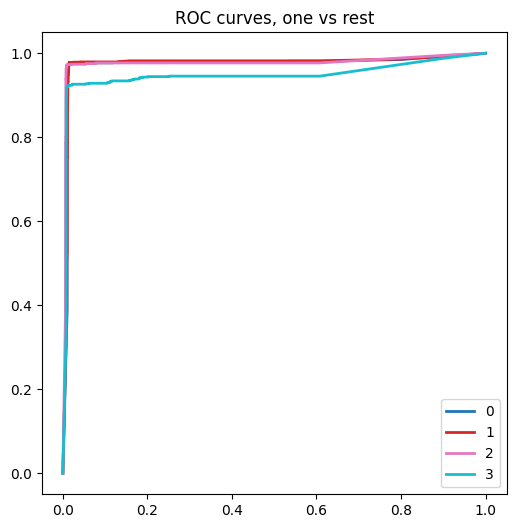

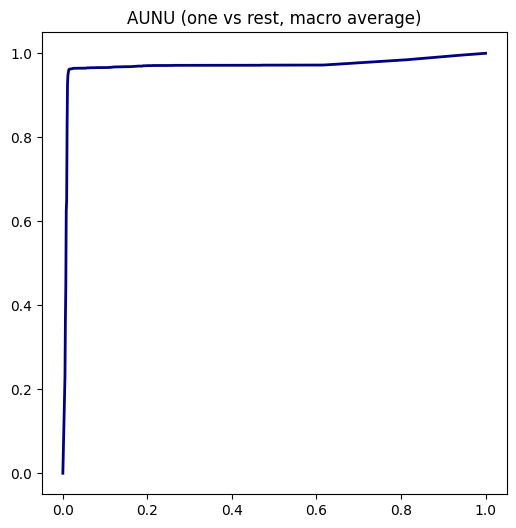

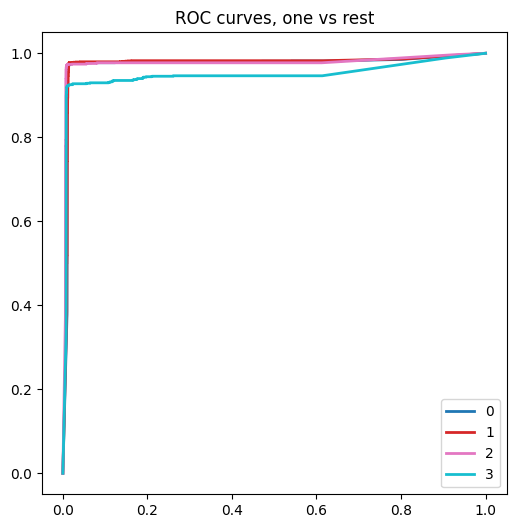

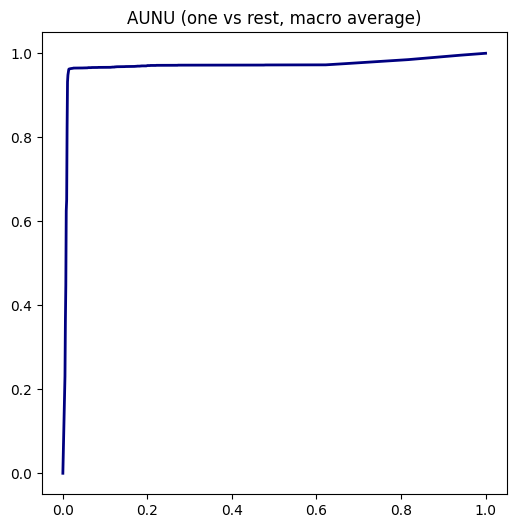

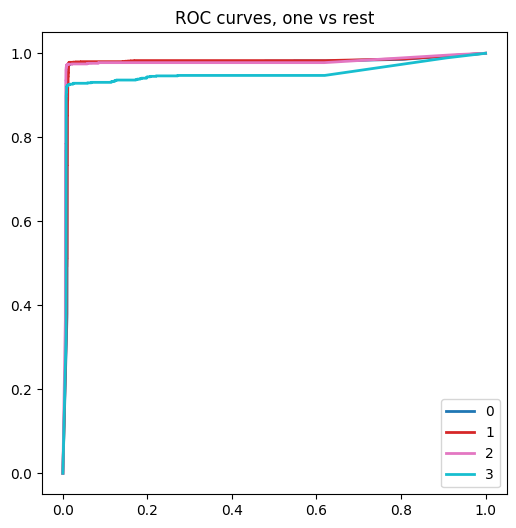

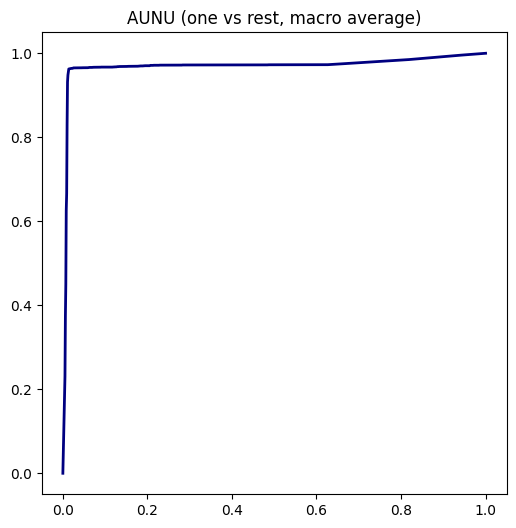

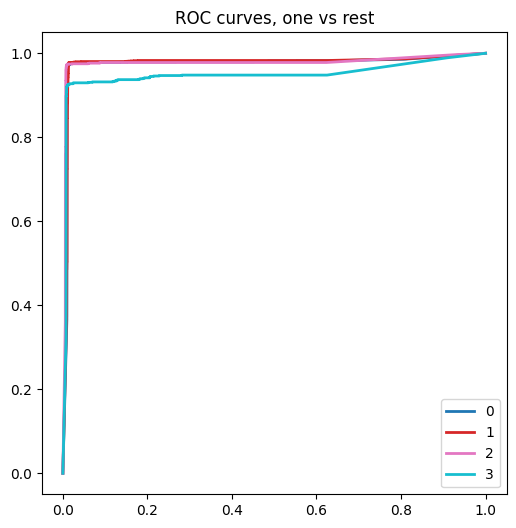

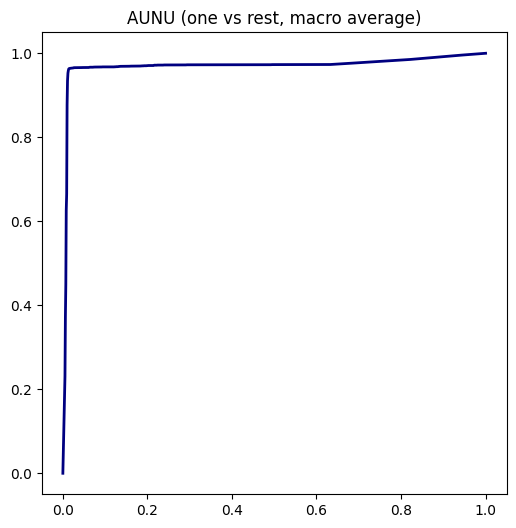

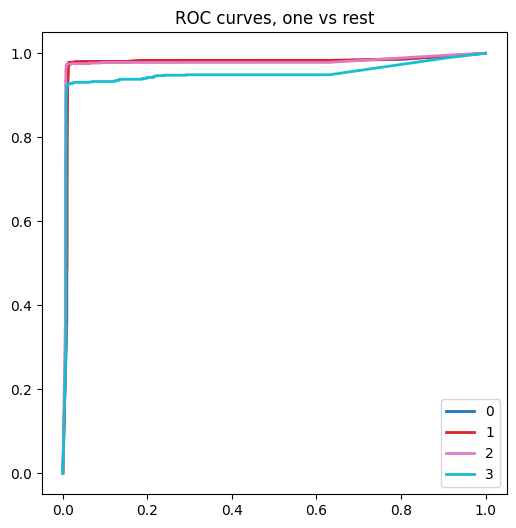

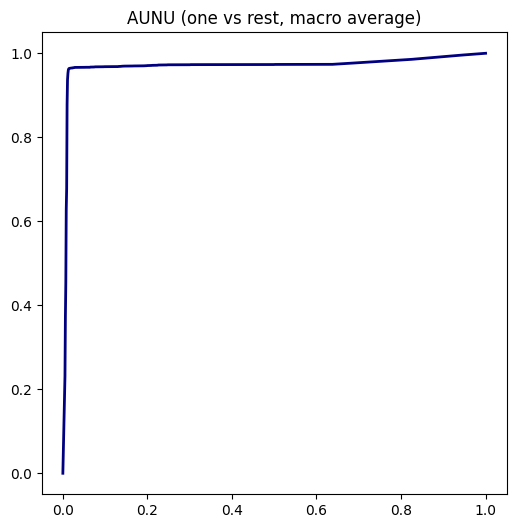

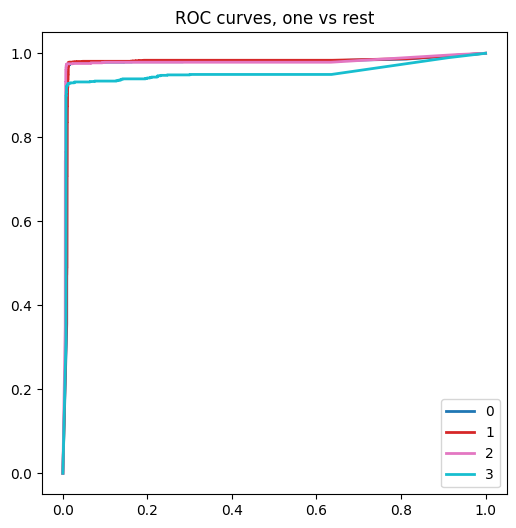

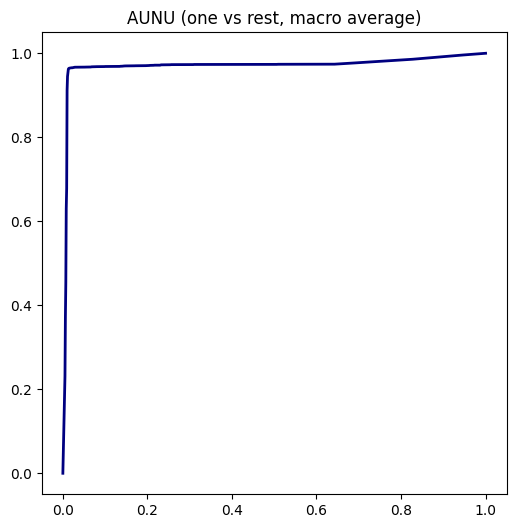

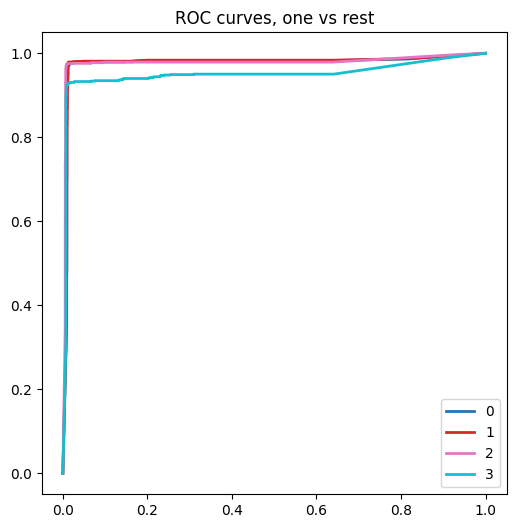

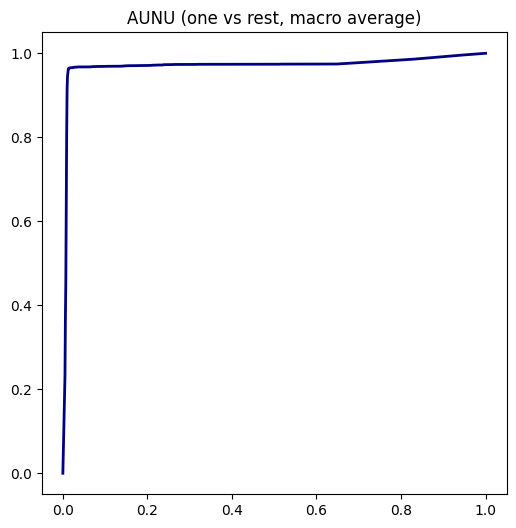

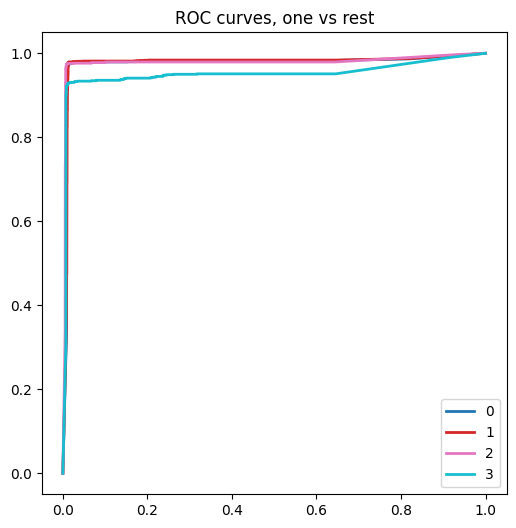

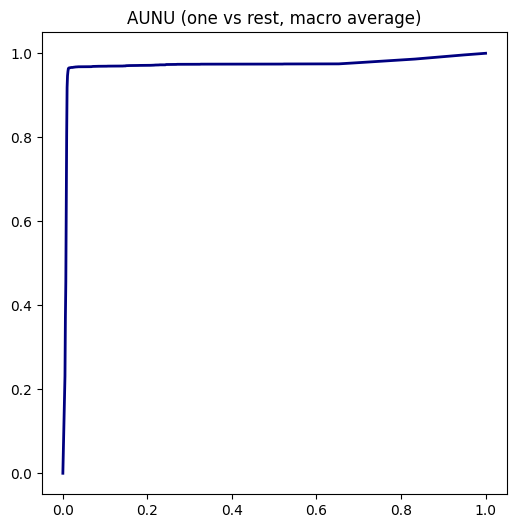

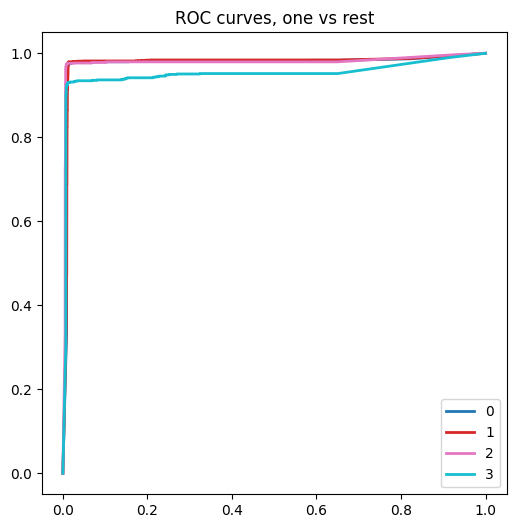

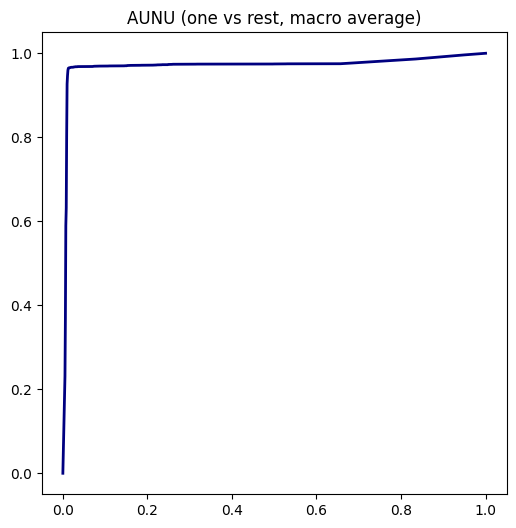

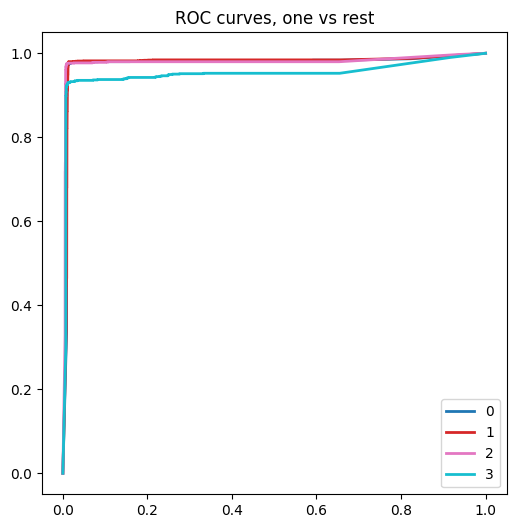

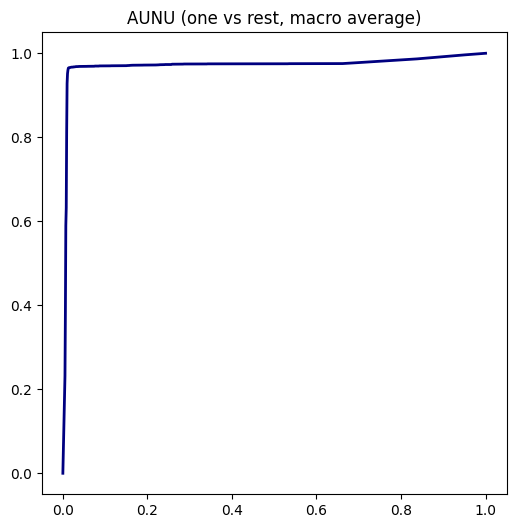

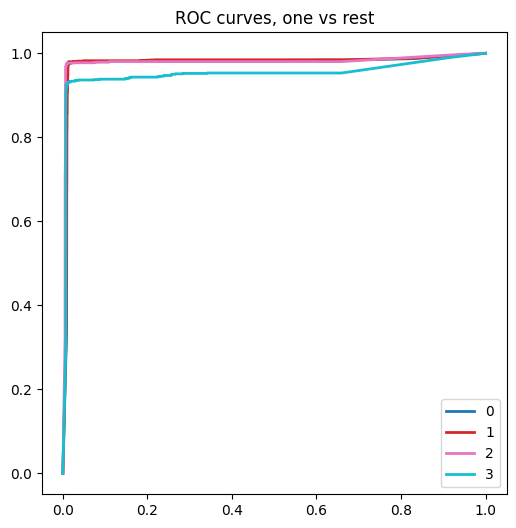

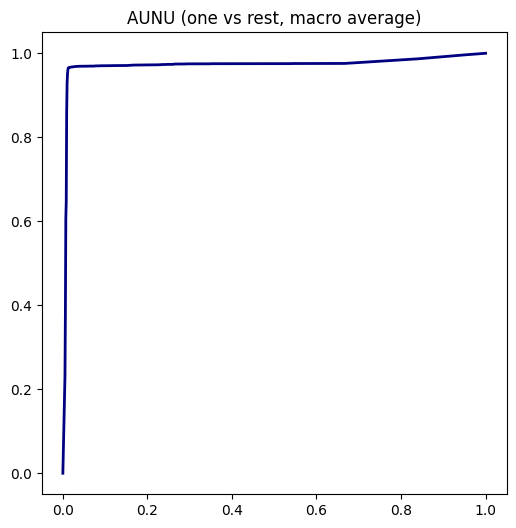

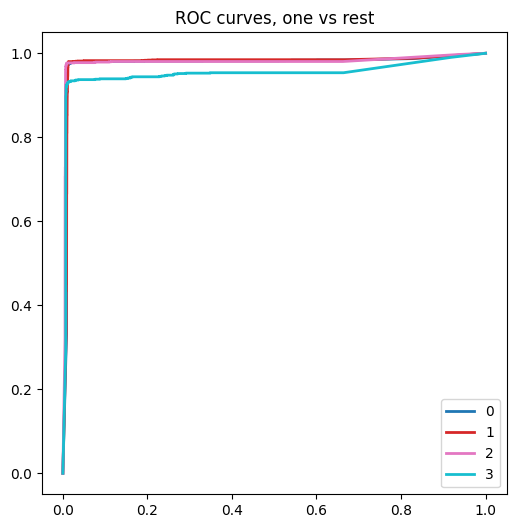

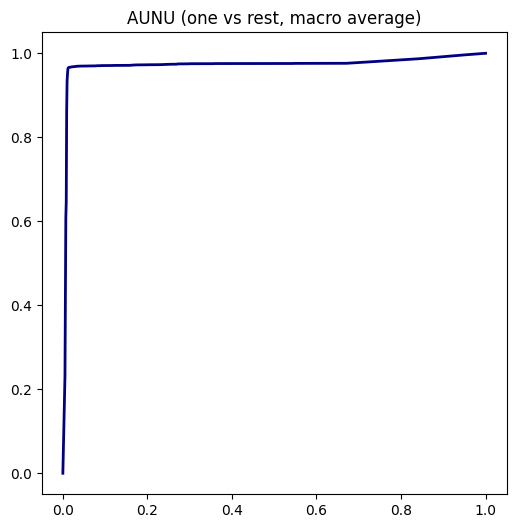

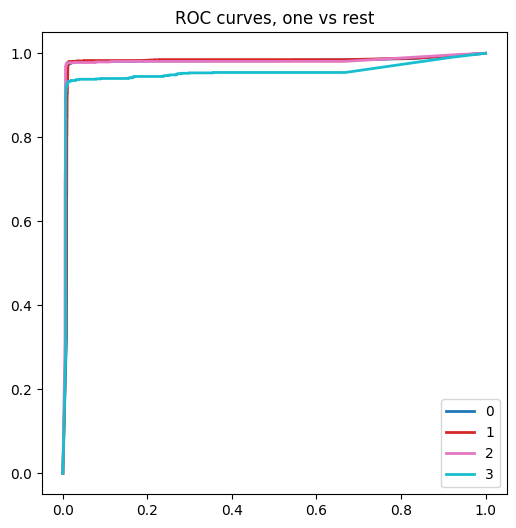

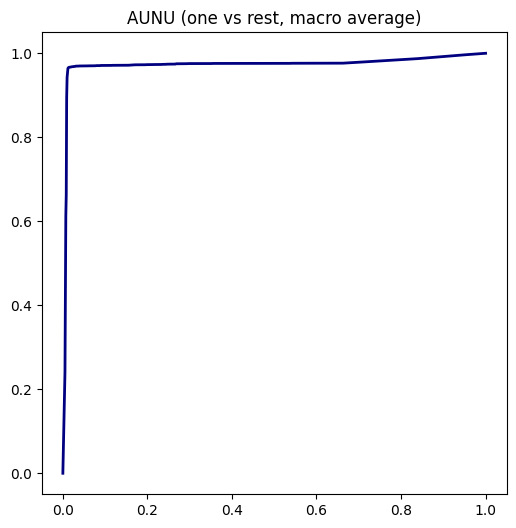

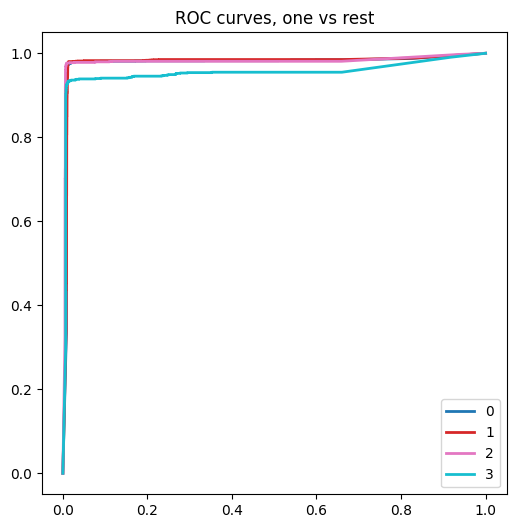

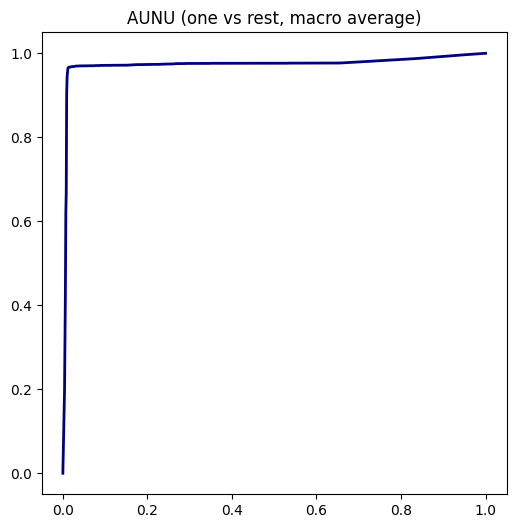

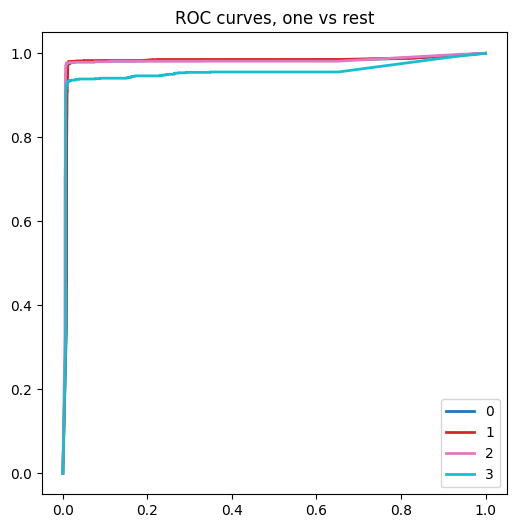

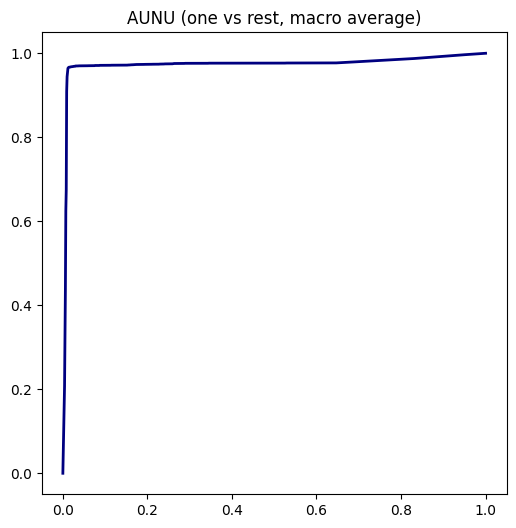

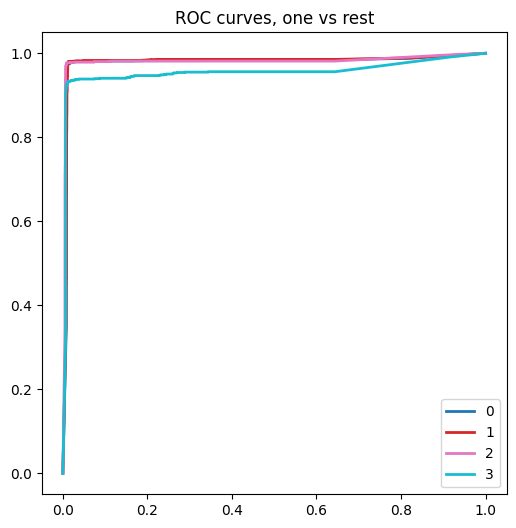

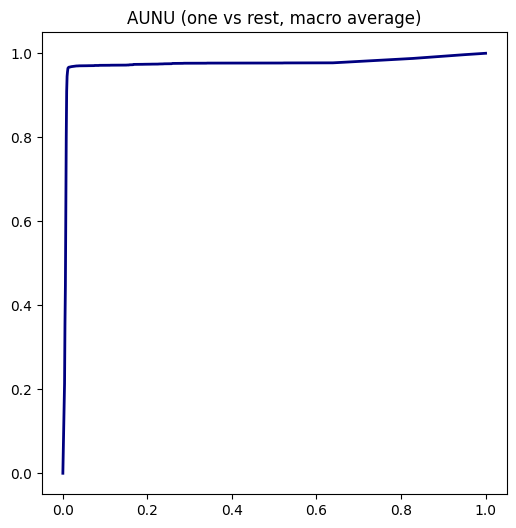

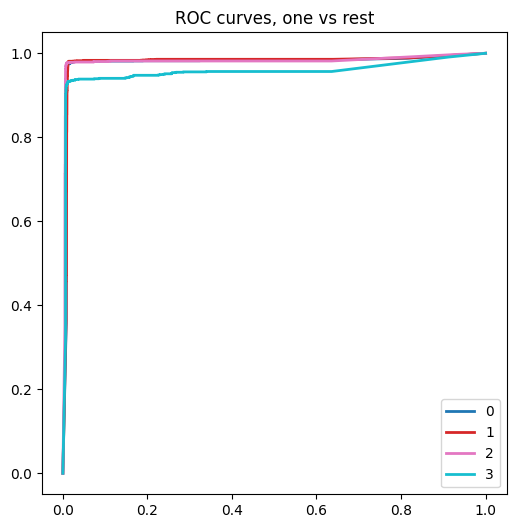

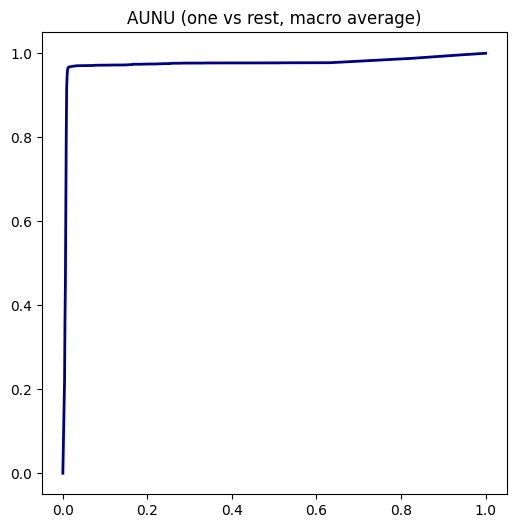

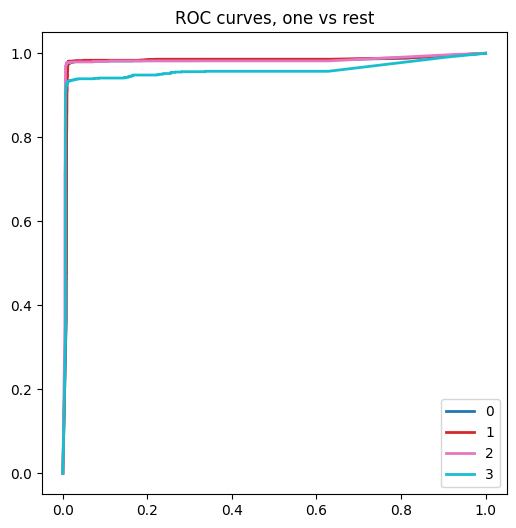

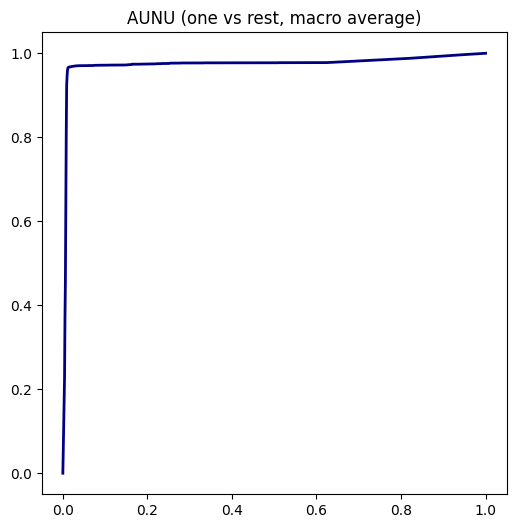

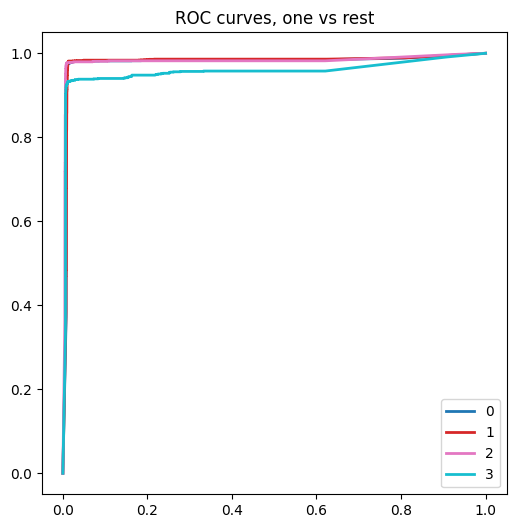

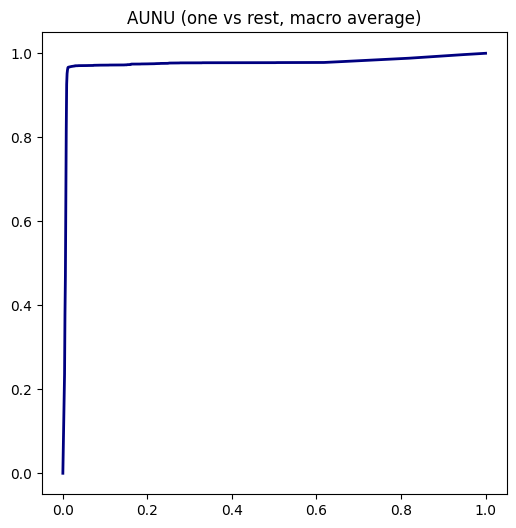

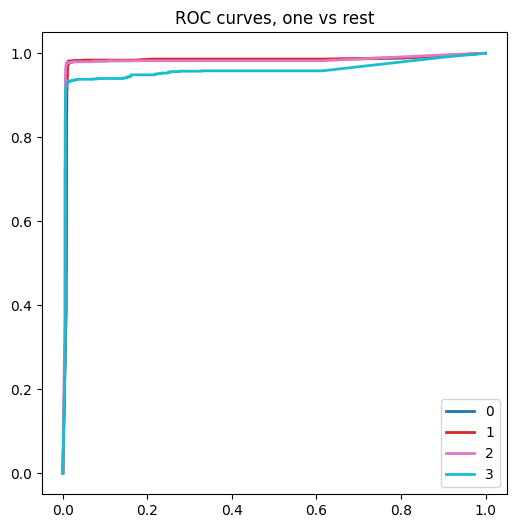

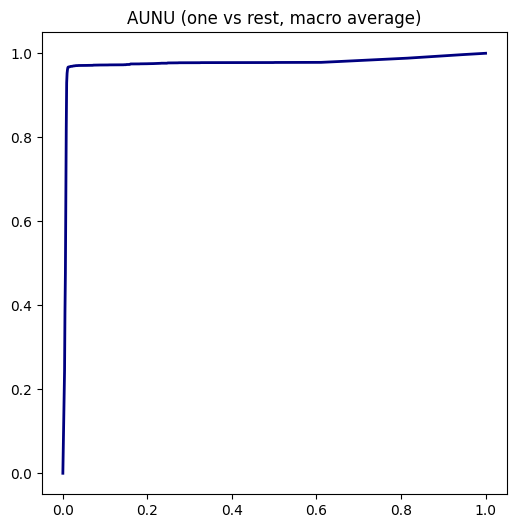

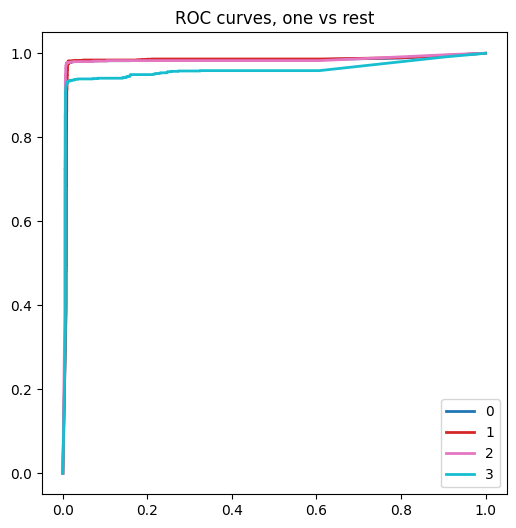

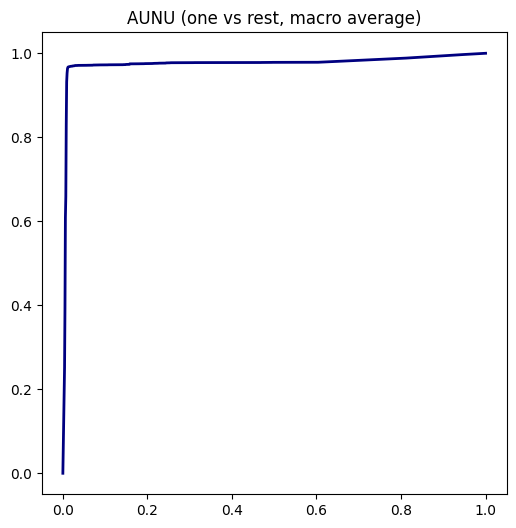

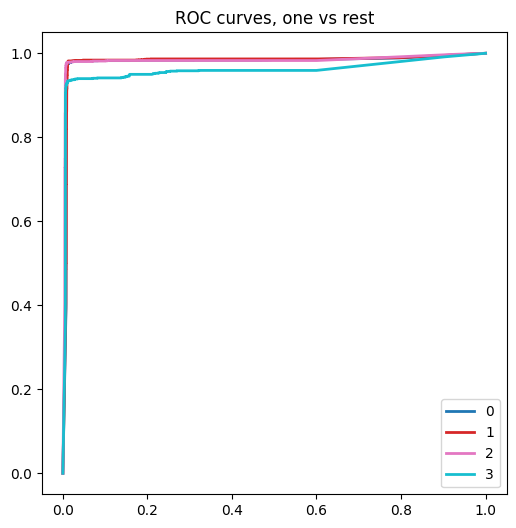

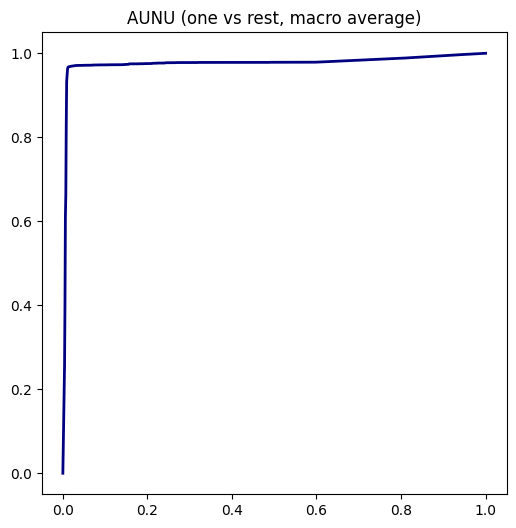

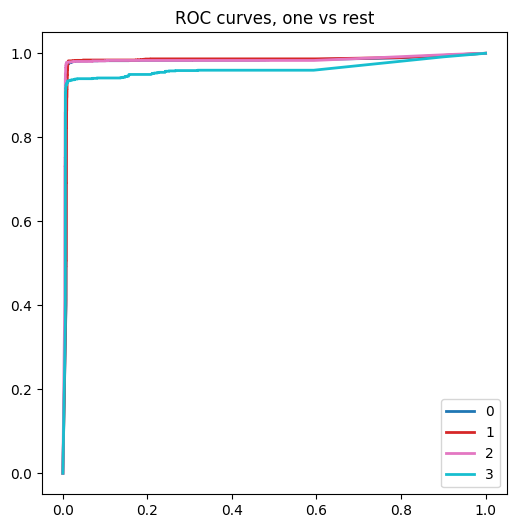

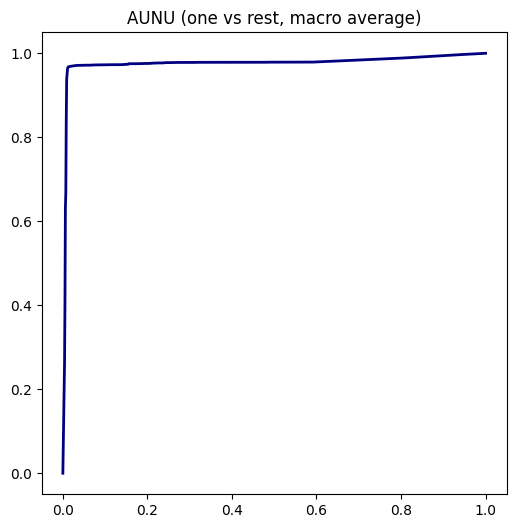

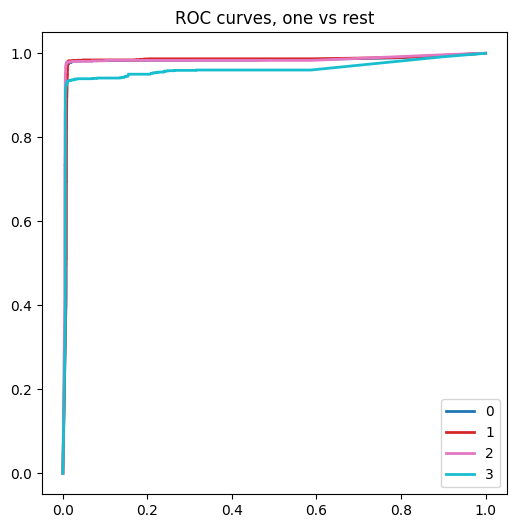

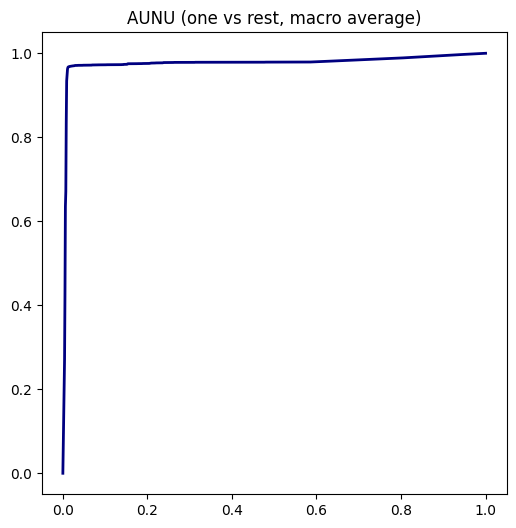

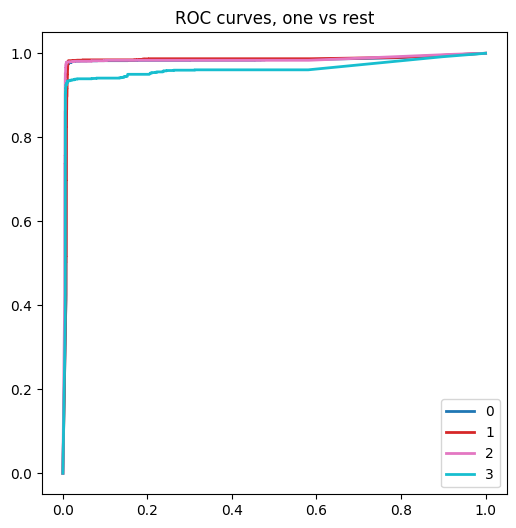

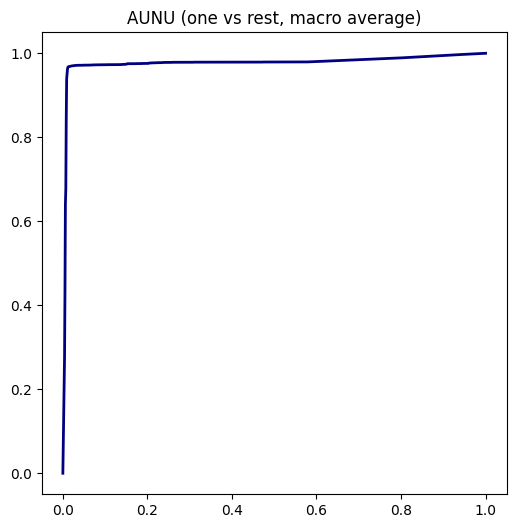

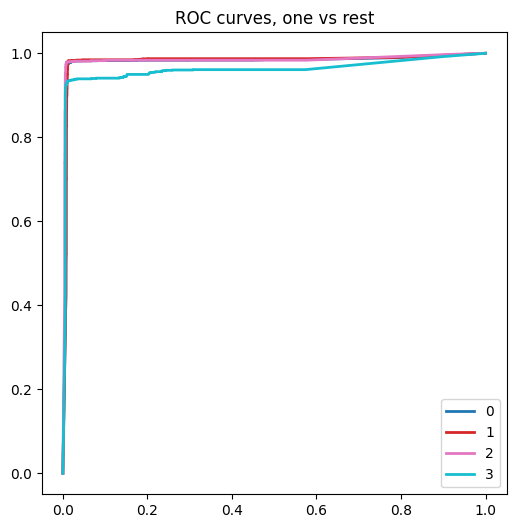

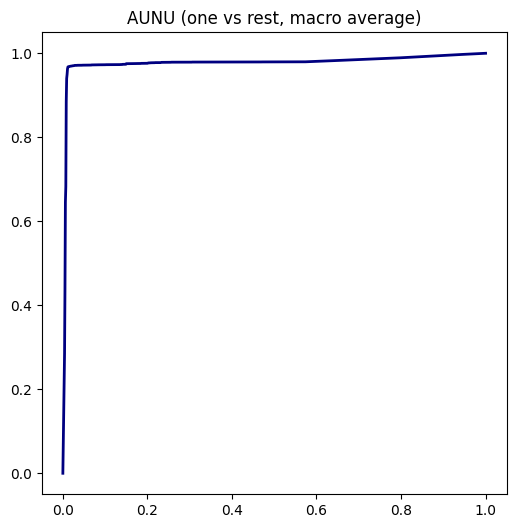

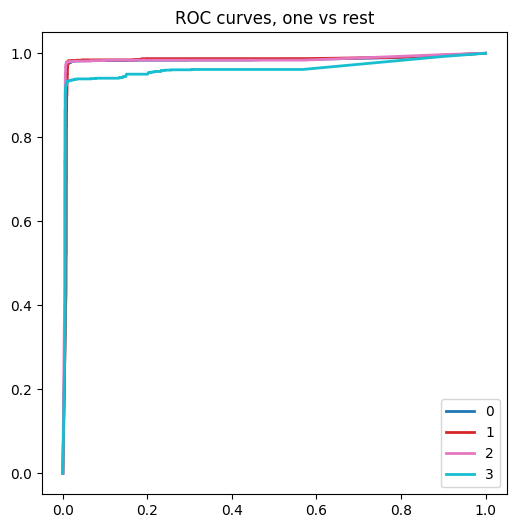

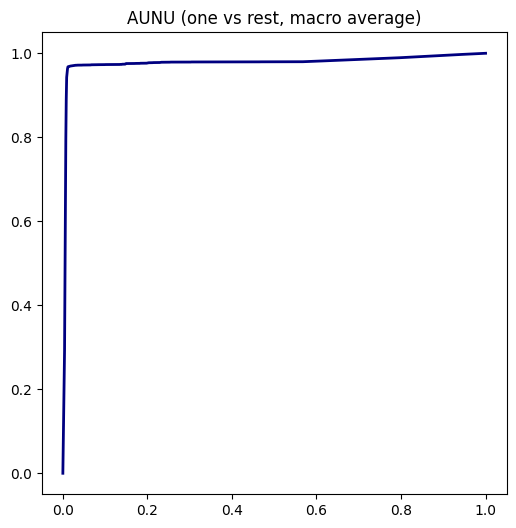

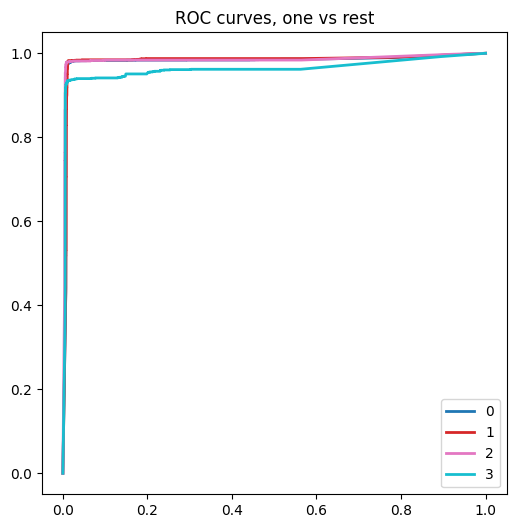

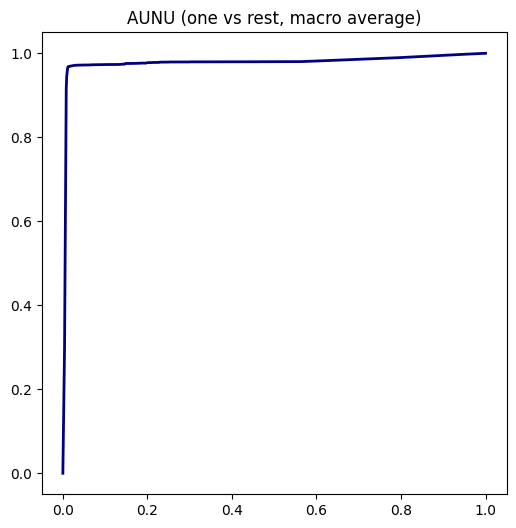

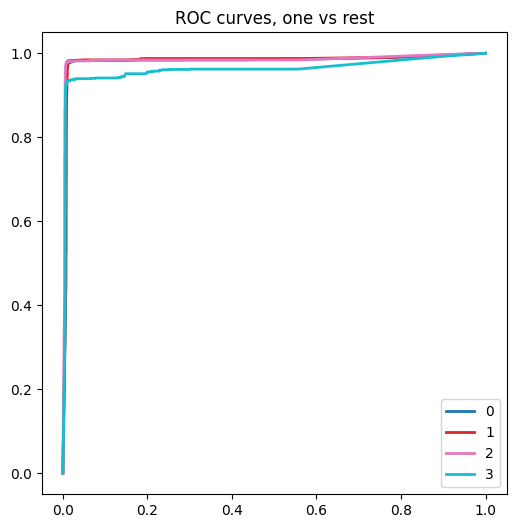

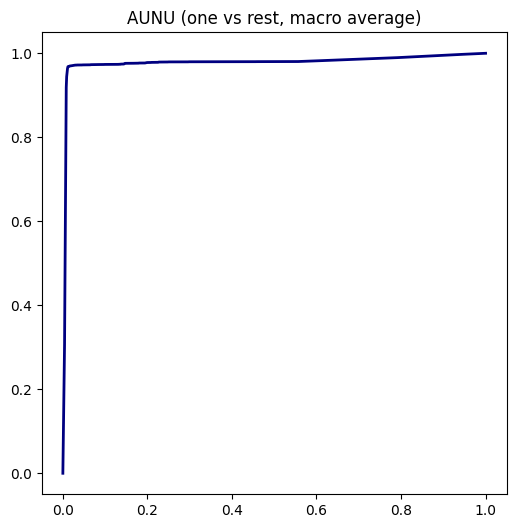

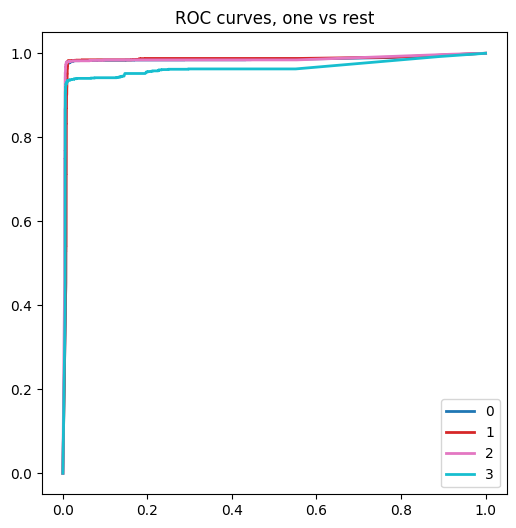

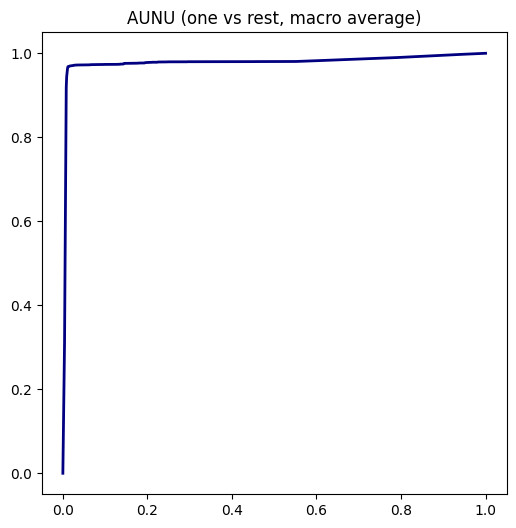

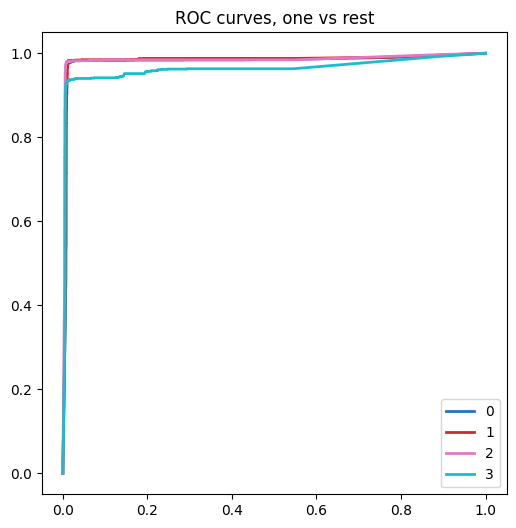

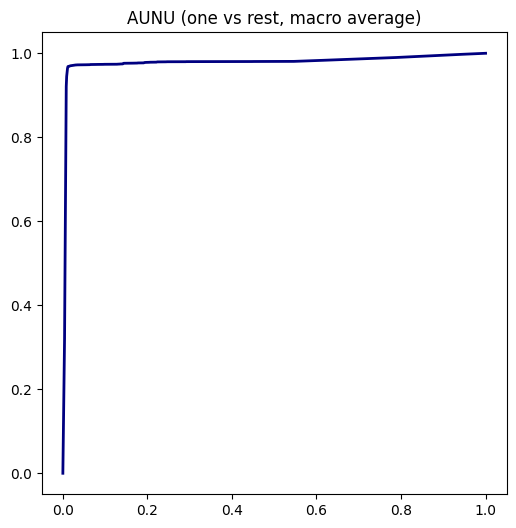

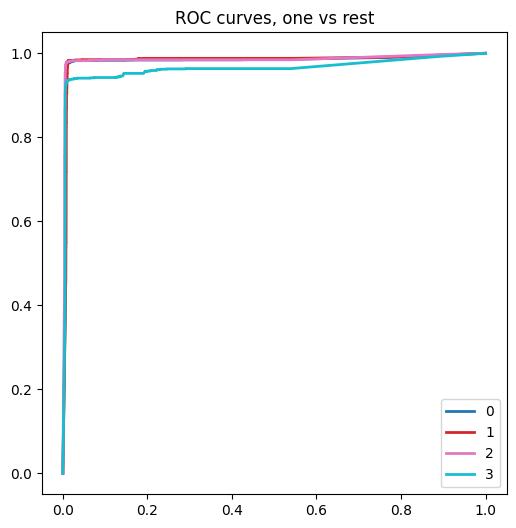

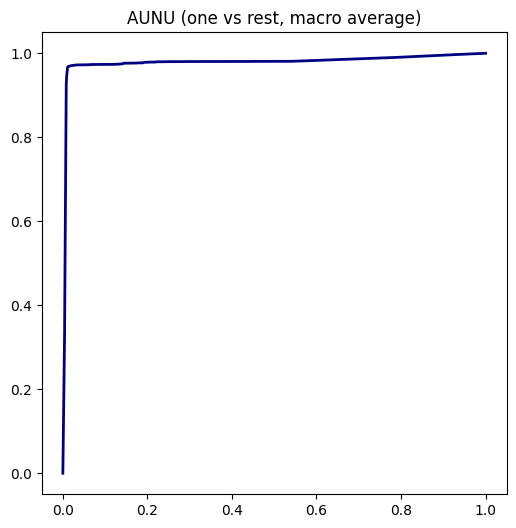

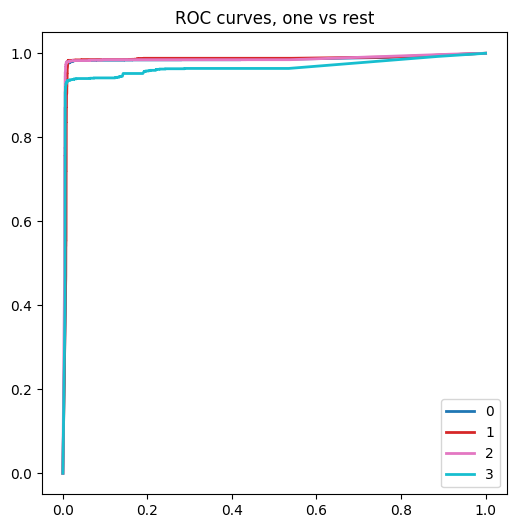

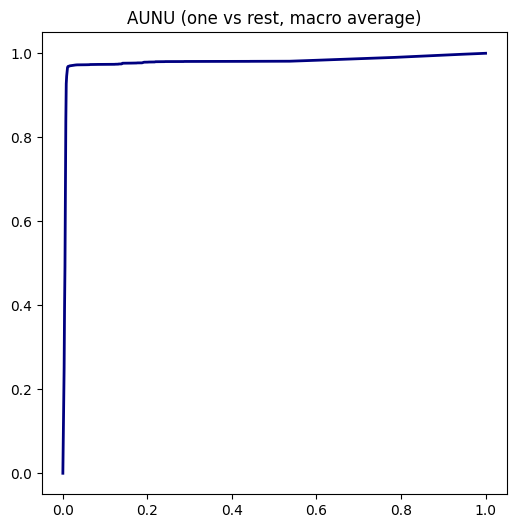

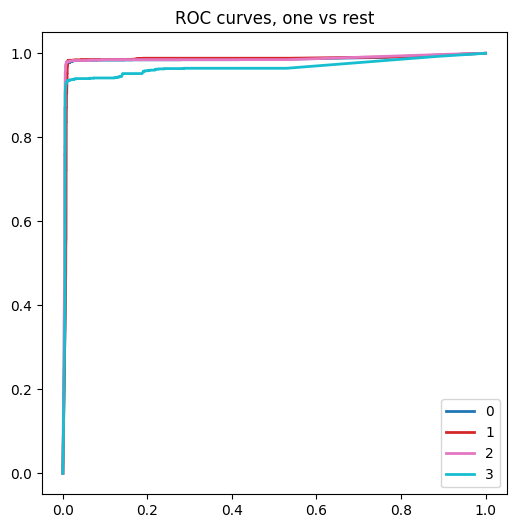

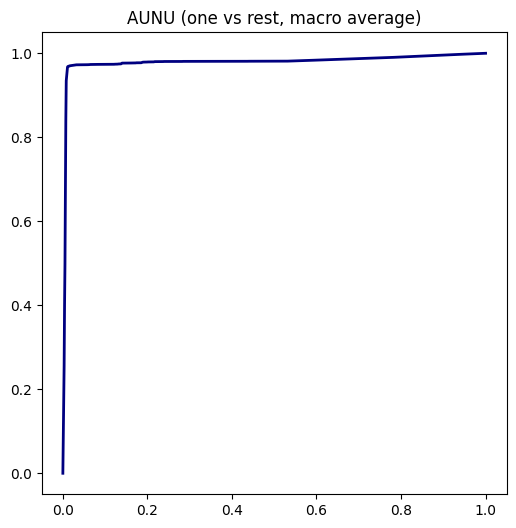

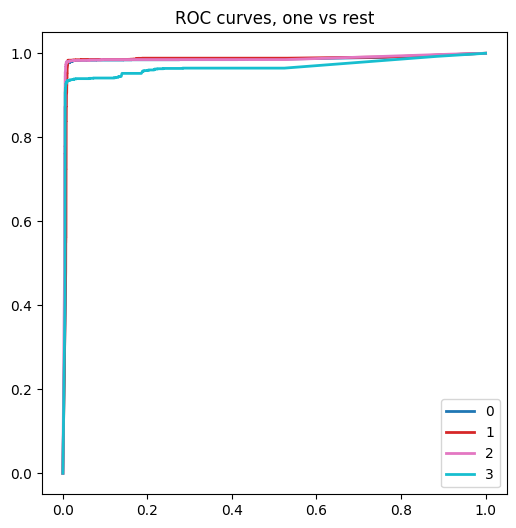

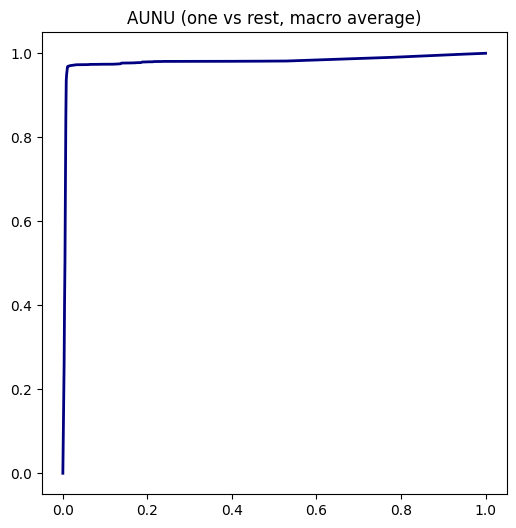

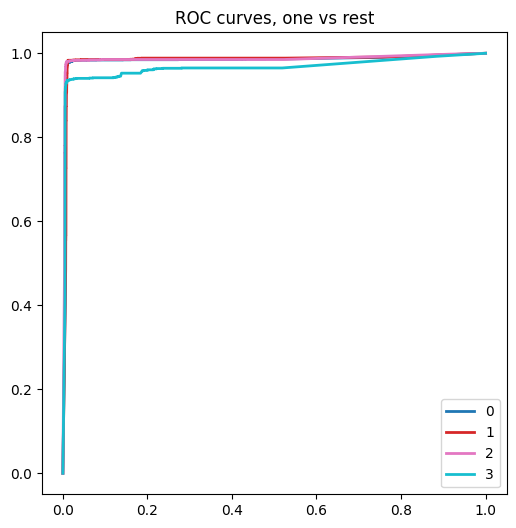

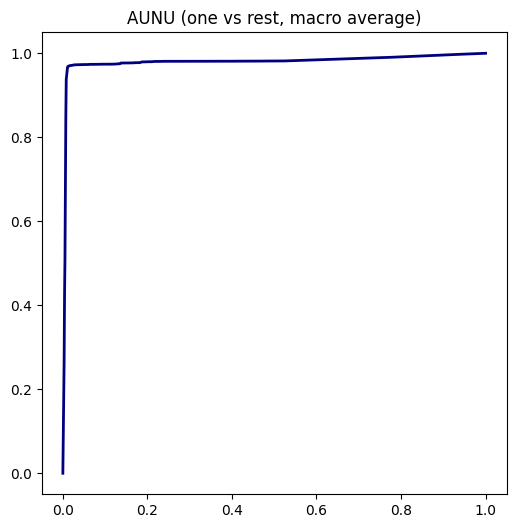

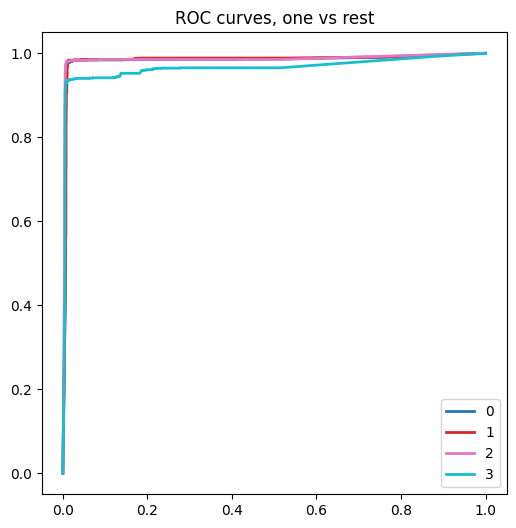

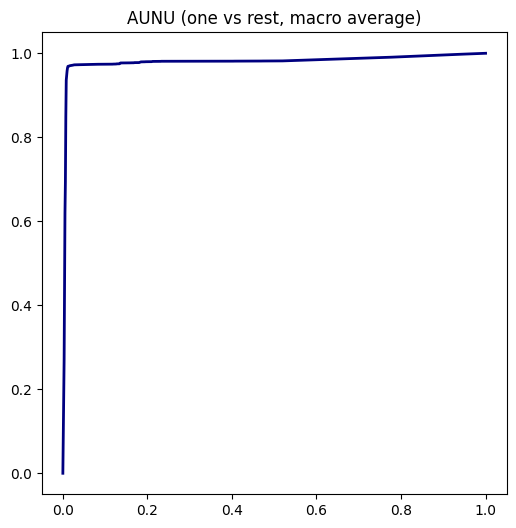

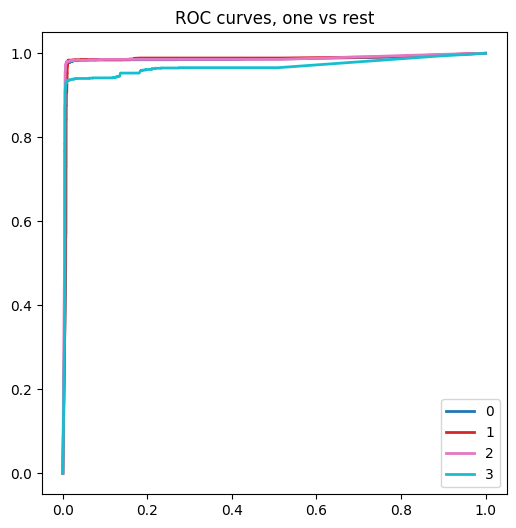

In [56]:
perform_experiments(multiclass_imbalanced_datasets, binary_multiclass_models, REPETITIONS, output_dir_base, TaskType.MULTICLASS)

### Multilabel

In [ ]:
perform_experiments(multilabel_balanced_datasets, multilabel_models, REPETITIONS, output_dir_base, TaskType.MULTILABEL)

In [ ]:
perform_experiments(multilabel_imbalanced_datasets, multilabel_models, REPETITIONS, output_dir_base, TaskType.MULTILABEL)